# Mutational antigenic profiling of WSN HA with S139/1 and C179

This is analysis of antibody selections of the WSN HA mutant virus libraries with two broadly neutralizing HA monoclonal antibodies, **S139/1** and **C179**.

I selected the three biological replicate mutant virus libraries carrying mutant HA's with neutralizing concentrations of S139/1 or C179, infected cells with the neutralized viruses, extracted RNA from the infected cells, reverse-transcribed and amplified the extracted RNA, and deep sequenced the libraries.
In this analysis, I am going to look at data from the S139/1 and C179 selections in addition to selections Mike Doud completed with FI6v3 and H17L19.

### Import modules, define directories

In [1]:
import os
import glob
import math
import time
import pandas as pd
import numpy as np
from colour import Color
from scipy.optimize import curve_fit
from pymodules.new_utils import * # custom modules for this analysis
import matplotlib
import matplotlib.lines as mlines
matplotlib.use('Pdf')
print('Using matplotlib version {0}'.format(matplotlib.__version__))
from matplotlib.ticker import MaxNLocator
import pylab as plt
from IPython.display import display, HTML
import dms_tools2
import dms_tools2.plot
from dms_tools2.ipython_utils import showPDF

print('Using dms_tools2 version {0}'.format(dms_tools2.__version__))

# define directories
fastqdir = './fastq/'
inputdir = './inputs/'
resultsdir = './results/'  
countsdir = os.path.join(resultsdir, 'counts_and_alignments/')
diffseldir = os.path.join(resultsdir, 'differential_selections/')   
corrdir = os.path.join(resultsdir, 'correlations/')
plotsdir = os.path.join(resultsdir, 'plots/')
logodir = os.path.join(resultsdir, 'logoplots/')
pymoldir = os.path.join(resultsdir, 'pymol/')
phidir = os.path.join(resultsdir, 'phi/')
    
# CPUs to use, should not exceed the number you request with slurm
ncpus = 4 

# do we use existing results or generate everything new?
use_existing = 'yes'

/home/jmlee34/.local/lib/python3.4/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Using matplotlib version 2.0.2


/app/python3/3.4.1/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


Using dms_tools2 version 2.0a0


## Overview of selection conditions and sample names

This is the list of antibody selections that I conducted with **S139/1** and **C179** on the WSN HA mutant virus libraries. We are going to analyze sequencing data from these selections.

In [2]:
exp_list = pd.read_csv('{0}/experiment_list.csv'.format(inputdir))
exps = [str(e) for e in exp_list.experiment]
exps = ['0'+e if len(e) == 1 else e for e in exps]
exp_list['experiment'] = exps

In [3]:
exp_dict = dict(zip(exp_list['experiment'], exp_list['name']))
print (exp_dict)

{'11': 'L2-S139-c2', '07': 'L1-C179-c2', '21': 'L3-C179-c4', '02': 'L1-S139-c3', 'L2_FI6v3_c2': 'L2-FI6v3-c2', 'L1_H17L19_c2_r2': 'L1-H17L19-c2-r2', 'L1mockB': 'L1mockB', '19': 'L3-S139-c2', 'L1_mock_r2': 'L1mockB-FI6v3', '09': 'L2-S139-c4', '10': 'L2-S139-c3', 'L3_FI6v3_c2': 'L3-FI6v3-c2', '28': 'L1-S139-c6-r2', '23': 'L3-C179-c2', 'L1mockA': 'L1mockA', '18': 'L3-S139-c3', 'L1_FI6v3_c1_r1': 'L1-FI6v3-c1-r1', '17': 'L3-S139-c4', 'L3_FI6v3_c1': 'L3-FI6v3-c1', 'L2_H17L19_c2': 'L2-H17L19-c2', 'L3mock': 'L3mock', 'L3_H17L19_c2': 'L3-H17L19-c2', 'L1_H17L19_c2_r1': 'L1-H17L19-c2-r1', 'WSN-WTplasmid': 'WTplasmid', '20': 'L3-S139-c1', 'L3_mock': 'L3mock-FI6v3', 'L1_FI6v3_c1_r2': 'L1-FI6v3-c1-r2', '15': 'L2-C179-c2', '25': 'L1-S139-c5-r1', '27': 'L1-S139-c5-r2', '26': 'L1-S139-c6-r1', 'L2_mock': 'L2mock-FI6v3', '05': 'L1-C179-c4', '13': 'L2-C179-c4', '03': 'L1-S139-c2', 'L2mock': 'L2mock', 'L1_FI6v3_c2_r1': 'L1-FI6v3-c2-r1', '29': 'L1-C179-c2-r1', 'L2_H17L19_c3': 'L2-H17L19-c3', 'L1_H17L19_c3_r

## Get FASTQ files

Symbolically link to the FASTQ files on the server.

In [4]:
log = !python ./scripts/symlink_fastq.py
print("Symbolically linked FASTQ files to {0}".format(fastqdir))

Symbolically linked FASTQ files to ./fastq/


## Define the samples

The csv below lists the experiment numbers with their corresponding concentrations of antibodies that I used to neutralize the libraries, and the % infectivity after neutralization, as estimated by qPCR.

The samples are located in four different `fastq` directories based on when they were sequenced. 
There is one set of mock-selected samples (completed by Mike), but these mock-selected samples were sequenced twice: once alongside Mike's FI6v3- and H17L19-selected libraries, and once alongside my C179-selected libraries. 

In [5]:
# Specify Read 1 filenames
R1list = ['{0}_R1_*.fastq.gz'.format(e) for e in exp_list.experiment]
exp_list['R1'] = R1list

In [6]:
# Specify trimming parameters
S139_R1trim = ' '.join(['190', '175', '175', '175', '190', '190'])
S139_R2trim = ' '.join(['180', '180', '180', '180', '190', '190'])
R1trim_map = {'A': S139_R1trim, 'B': 200, 'C': S139_R1trim, 'D': 200}
R2trim_map = {'A': S139_R2trim, 'B': 170, 'C': S139_R2trim, 'D': 170}
exp_list['R1trim'] = exp_list.fastqdir.map(R1trim_map)
exp_list['R2trim'] = exp_list.fastqdir.map(R2trim_map)

In [7]:
display(HTML(exp_list.to_html(index=True)))

In [8]:
samples = exp_list['name'].tolist()
# S139samples = exp_list[exp_list.antibody == 'S139']
# C179samples = exp_list[exp_list.antibody != 'S139'][0:13]
# MDsamples = exp_list[exp_list.antibody != 'S139'][13:]

## Align the deep sequencing data and count mutations

Because the samples were all sequenced on different sets of HiSeq runs, I am going to run a batch analysis using different trimming parameters for each sample.

In [9]:
# Specify global alignment parameters
# file containing wildtype WSN HA sequence
refseq = './inputs/WSN_HA_reference.fa'

# define subamplicon alignment specifications
alignspecs = ' '.join(['1,285,36,37', 
                       '286,570,31,32',
                       '571,855,37,32',
                       '856,1140,31,36',
                       '1141,1425,29,33',
                       '1426,1698,40,43'])

In [10]:
# Alignments for all samples
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(exp_list[['name', 'R1', 'R1trim', 'R2trim']].to_html(index=False)))
exp_list[['name', 'R1', 'R1trim', 'R2trim']].to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}
        
print('Completed dms2_batch_bcsubamp.')

Here is the batch file that we write to CSV format to use as input:



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


In [11]:
countsplotprefix = os.path.join(countsdir, 'summary')

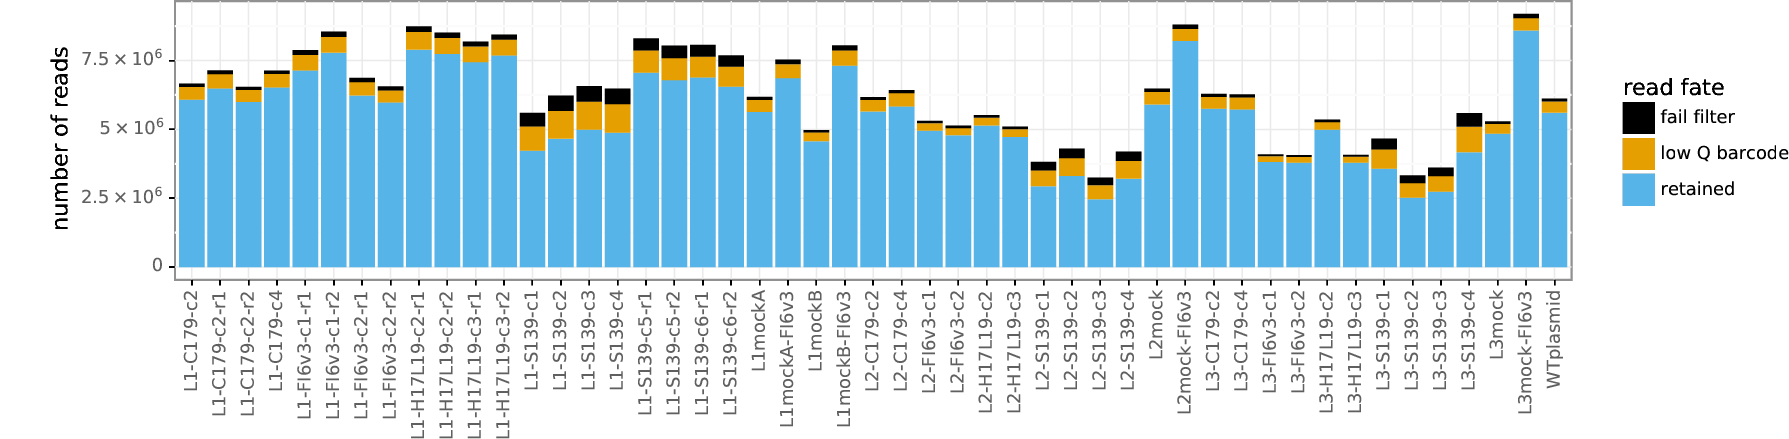

In [13]:
showPDF(countsplotprefix + '_readstats.pdf')

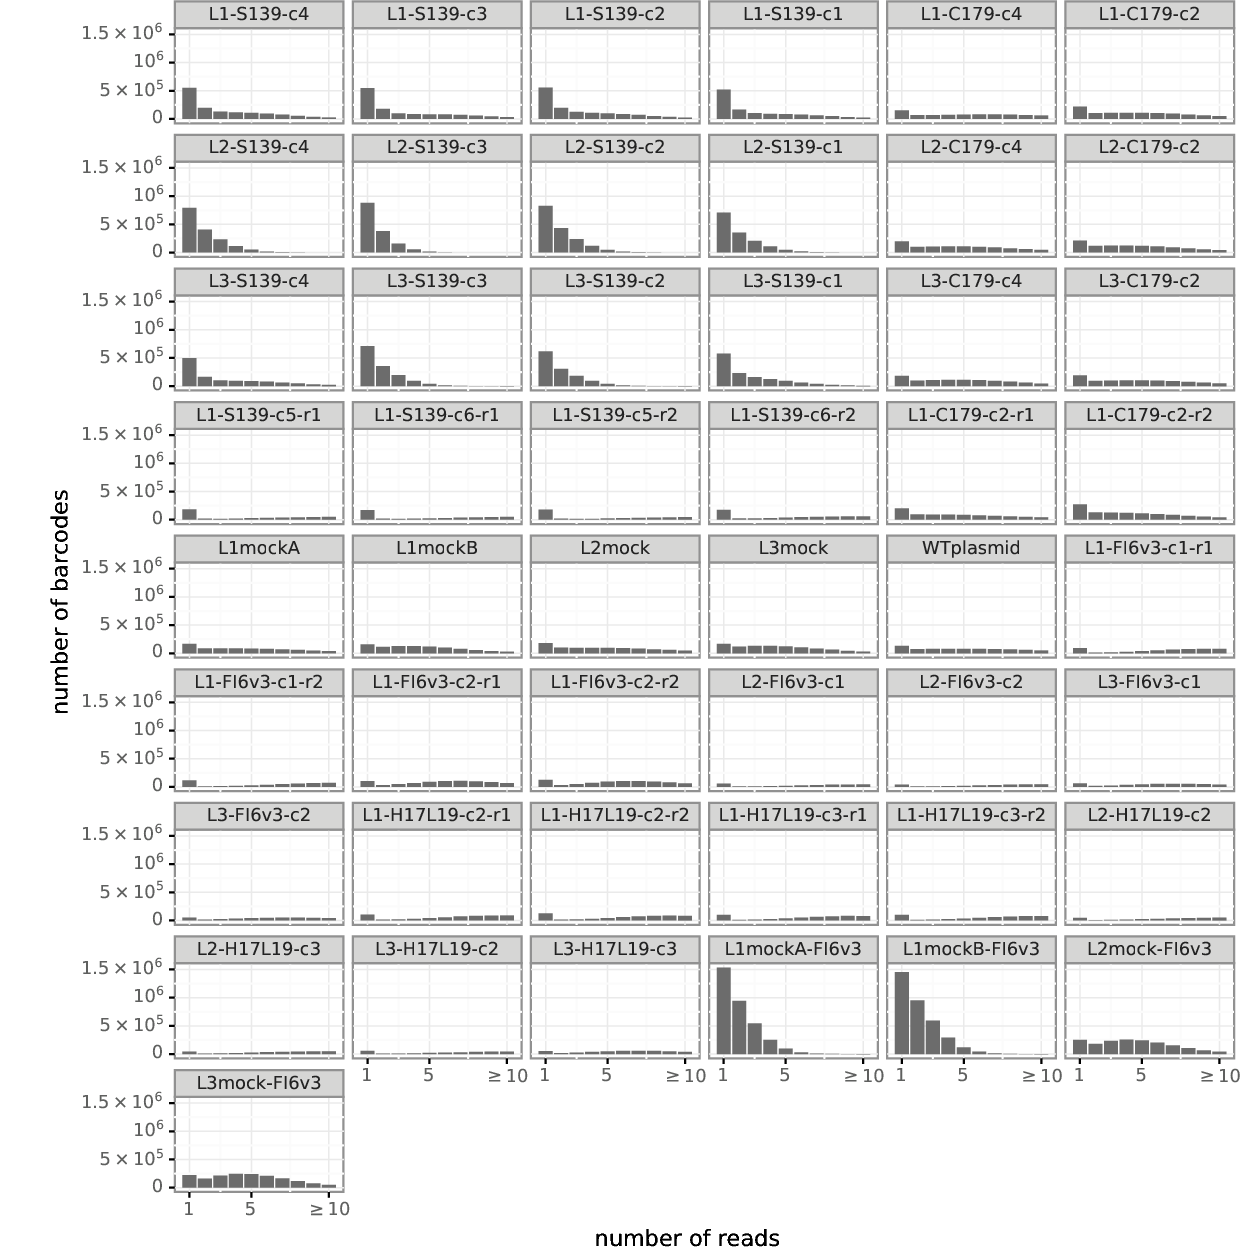

In [14]:
showPDF(countsplotprefix + '_readsperbc.pdf')

Overall read depth for the C179-associated samples is very good. Some of the S139-selected samples look like they are oversequenced, while others look like they could have been sequenced to greater depth. Mike's two L1mock samples also look a little undersequenced.

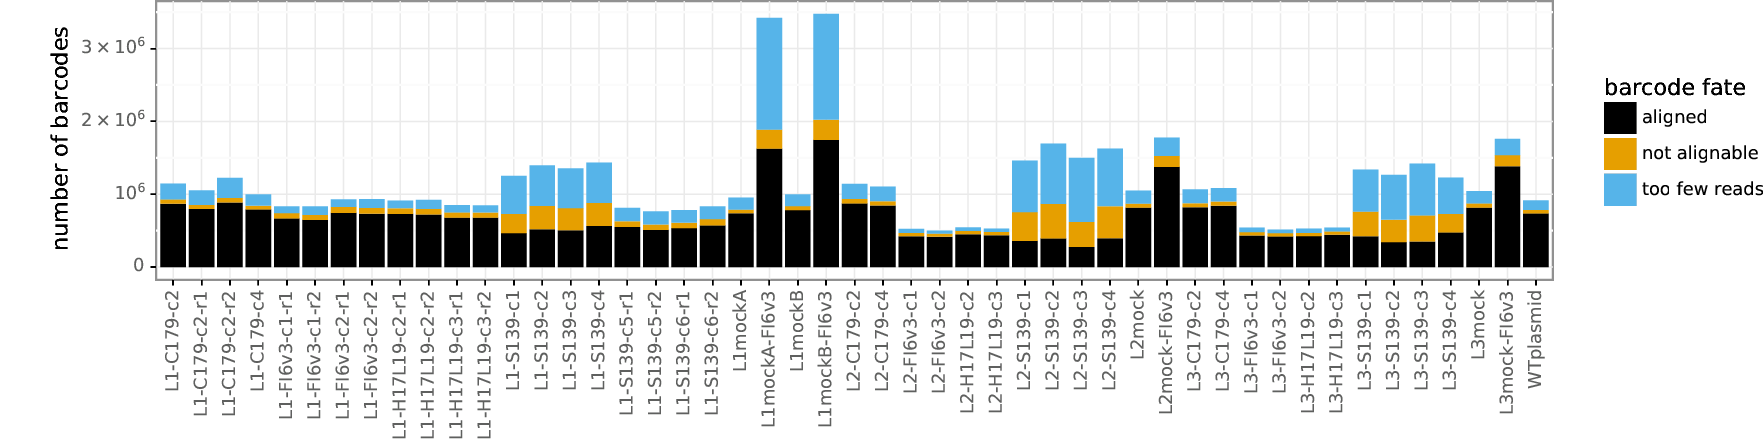

In [15]:
showPDF(countsplotprefix + '_bcstats.pdf')

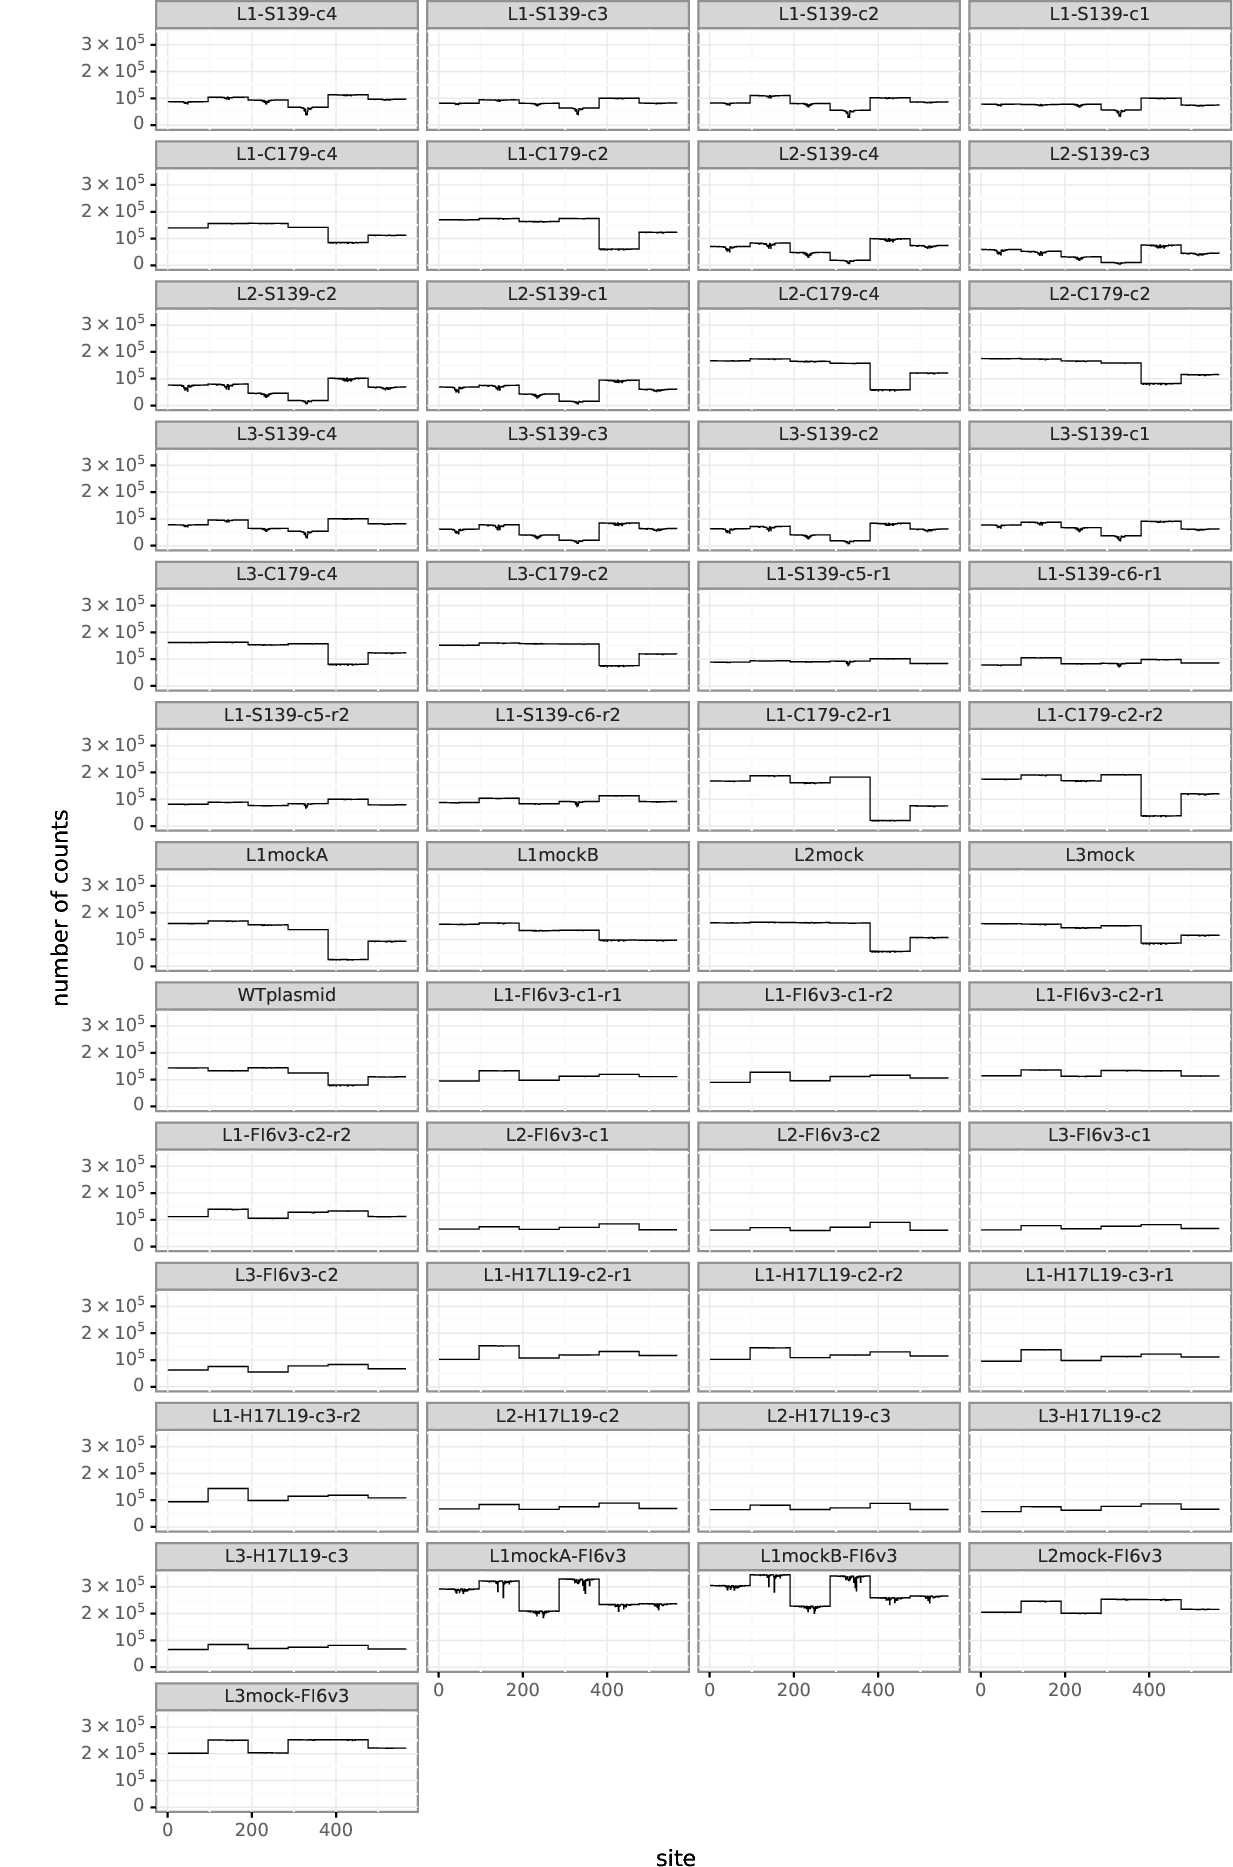

In [16]:
showPDF(countsplotprefix + '_depth.pdf')

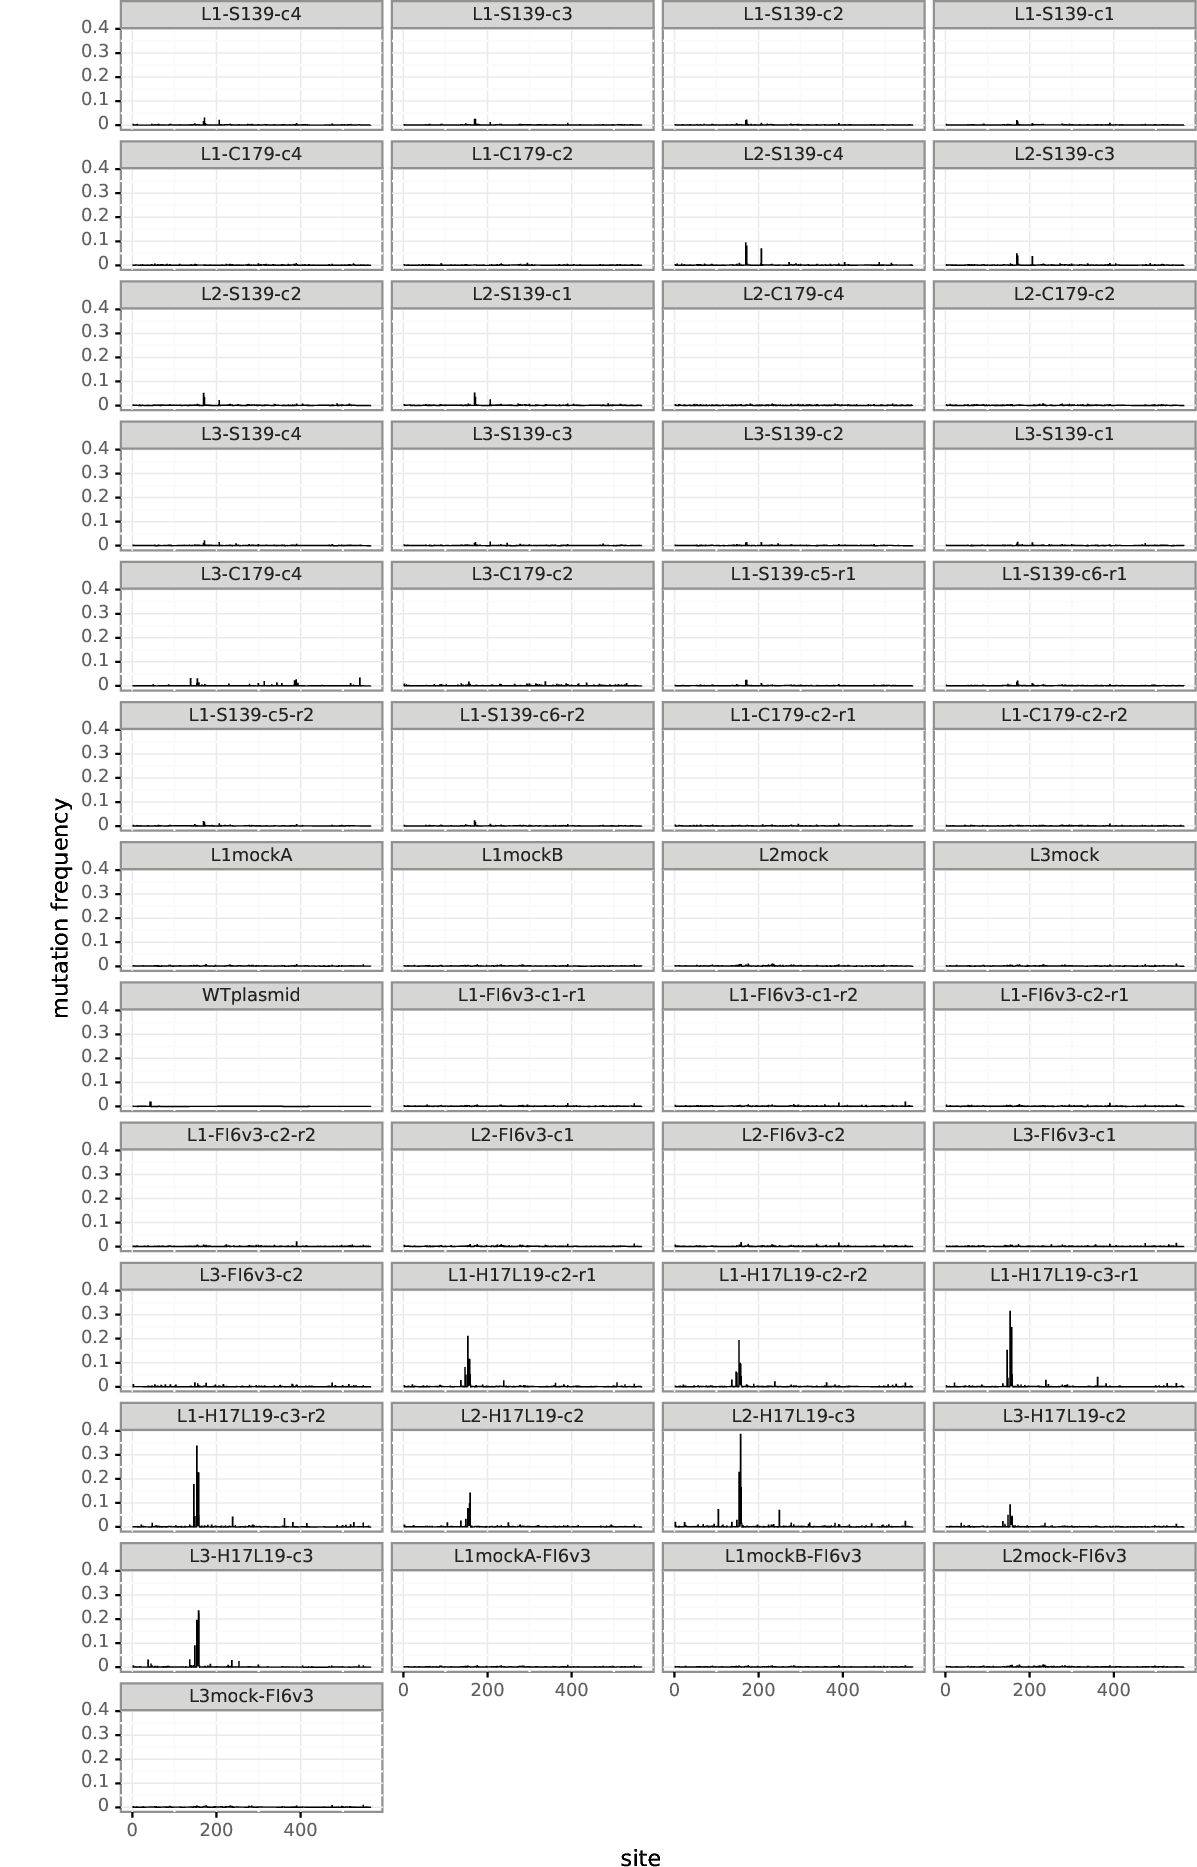

In [17]:
showPDF(countsplotprefix + '_mutfreq.pdf')

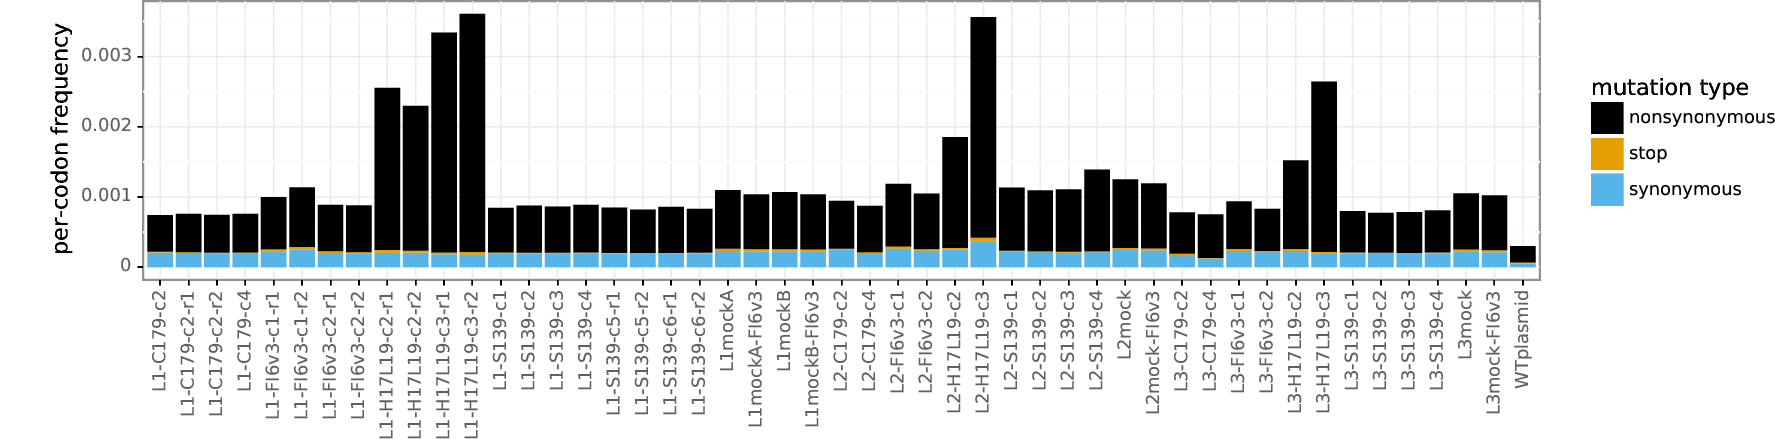

In [18]:
showPDF(countsplotprefix + '_codonmuttypes.pdf')

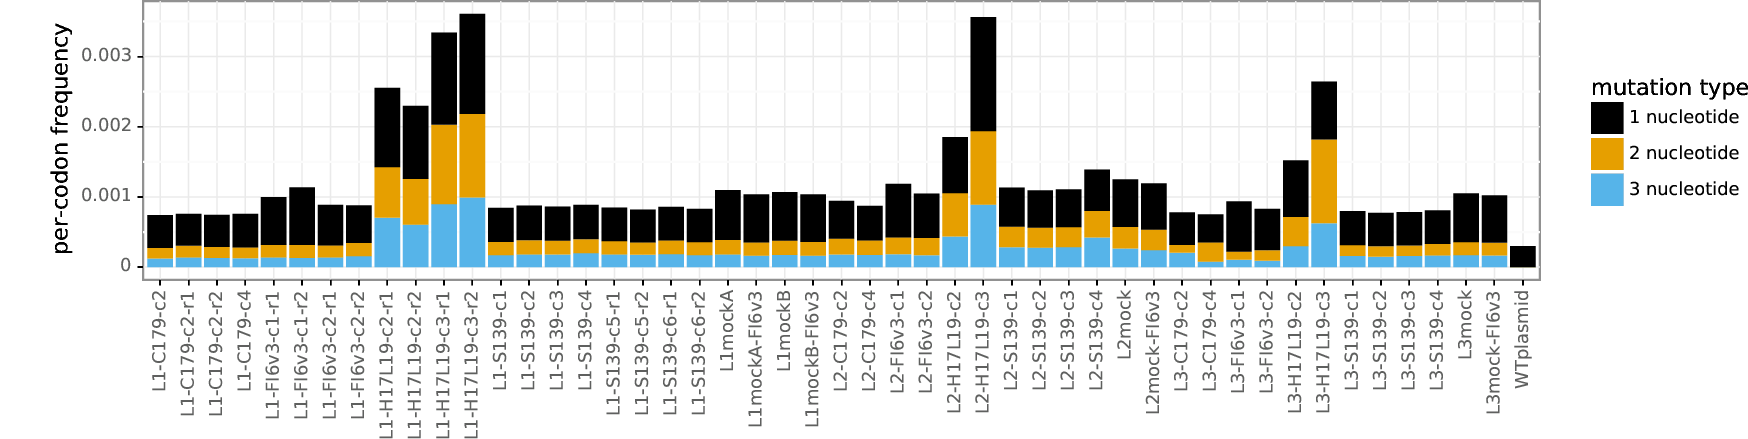

In [19]:
showPDF(countsplotprefix + '_codonntchanges.pdf')

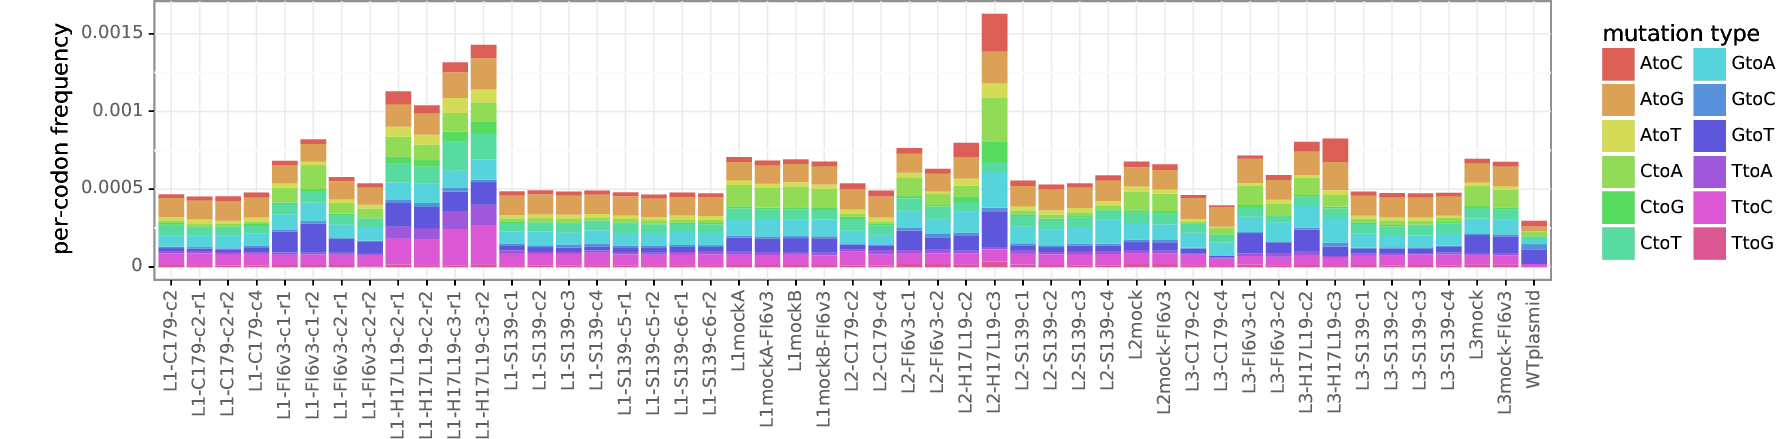

In [20]:
showPDF(countsplotprefix + '_singlentchanges.pdf')

Some of Mike's samples show signs of oxidative damage (enrichment of `G to T` and `C to A` mutations). My selected samples do not show much oxidative damage, although interestingly, the mock-selected samples, which I prepped from Mike's initial full-length amplicon reaction, does show some signs of oxidative damage compared to the selected libraries.

# Compute differential selection

Here I am going to compute differential selection for the various selection conditions by defining selection groups as well as their associated replicates, selection name, mock library, and error control correction.

For the S139/1- and C179-selected libraries, I am going to use the mock-selected codon counts from the libraries I sequenced in parallel with the C179 selections. For Mike's FI6v3- and H17L19-selected libraries, I am going to use the mock-selected codon counts from the libraries that he sequenced in parallel with these selections. These mock-selected codon counts are designated by `-FI6v3` attached to the sample name.

For error control correction for all samples, I will use the codon counts from the WT plasmid that I sequenced alongside my C179-selected libraries.

In [21]:
diffselbatchfile = os.path.join(diffseldir, 'batch.csv')

diffselbatch = pd.DataFrame.from_records([
         # S139 at c4
         ('S139-c4', 'replicate-1', 'L1-S139-c4', 'L1mockA'), 
         ('S139-c4', 'replicate-2', 'L2-S139-c4', 'L2mock'),
         ('S139-c4', 'replicate-3', 'L3-S139-c4', 'L3mock'),
         # S139 at c3
         ('S139-c3', 'replicate-1', 'L1-S139-c3', 'L1mockA'),
         ('S139-c3', 'replicate-2', 'L2-S139-c3', 'L2mock'),
         ('S139-c3', 'replicate-3', 'L3-S139-c3', 'L3mock'),
         # S139 at c2
         ('S139-c2', 'replicate-1', 'L1-S139-c2', 'L1mockA'),  
         ('S139-c2', 'replicate-2', 'L2-S139-c2', 'L2mock'),        
         ('S139-c2', 'replicate-3', 'L3-S139-c2', 'L3mock'),   
         # S139 at c1
         ('S139-c1', 'replicate-1', 'L1-S139-c1', 'L1mockA'), 
         ('S139-c1', 'replicate-2', 'L2-S139-c1', 'L2mock'), 
         ('S139-c1', 'replicate-3', 'L3-S139-c1', 'L3mock'), 
         # S139 at c5
         ('S139-c5', 'replicate-1a', 'L1-S139-c5-r1', 'L1mockA'), 
         ('S139-c5', 'replicate-1b', 'L1-S139-c5-r2', 'L1mockB'),
         # S139 at c6
         ('S139-c6', 'replicate-1a', 'L1-S139-c6-r1', 'L1mockA'), 
         ('S139-c6', 'replicate-1b', 'L1-S139-c6-r2', 'L1mockB'),
         # C179
         ('C179', 'replicate-1a', 'L1-C179-c4', 'L1mockA'), 
         ('C179', 'replicate-1b', 'L1-C179-c2', 'L1mockA'),
         ('C179', 'replicate-1c', 'L1-C179-c2-r1', 'L1mockA'),
         ('C179', 'replicate-1d', 'L1-C179-c2-r2', 'L1mockB'),
         ('C179', 'replicate-2a', 'L2-C179-c4', 'L2mock'), 
         ('C179', 'replicate-2b', 'L2-C179-c2', 'L2mock'),
         ('C179', 'replicate-3a', 'L3-C179-c4', 'L3mock'),
         ('C179', 'replicate-3b', 'L3-C179-c2', 'L3mock'),
         # FI6v3
         ('FI6v3', 'replicate-1a', 'L1-FI6v3-c1-r1', 'L1mockA-FI6v3'), 
         ('FI6v3', 'replicate-1b', 'L1-FI6v3-c1-r2', 'L1mockB-FI6v3'),
         ('FI6v3', 'replicate-1c', 'L1-FI6v3-c2-r1', 'L1mockA-FI6v3'),
         ('FI6v3', 'replicate-1d', 'L1-FI6v3-c2-r2', 'L1mockB-FI6v3'),
         ('FI6v3', 'replicate-2a', 'L2-FI6v3-c1', 'L2mock-FI6v3'), 
         ('FI6v3', 'replicate-2b', 'L2-FI6v3-c2', 'L2mock-FI6v3'),
         ('FI6v3', 'replicate-3a', 'L3-FI6v3-c1', 'L3mock-FI6v3'),
         ('FI6v3', 'replicate-3b', 'L3-FI6v3-c2', 'L3mock-FI6v3'),
         # H17L19
         ('H17L19', 'replicate-1a', 'L1-H17L19-c2-r1', 'L1mockA-FI6v3'), 
         ('H17L19', 'replicate-1b', 'L1-H17L19-c2-r2', 'L1mockB-FI6v3'),
         ('H17L19', 'replicate-1c', 'L1-H17L19-c3-r1', 'L1mockA-FI6v3'),
         ('H17L19', 'replicate-1d', 'L1-H17L19-c3-r2', 'L1mockB-FI6v3'),
         ('H17L19', 'replicate-2a', 'L2-H17L19-c2', 'L2mock-FI6v3'), 
         ('H17L19', 'replicate-2b', 'L2-H17L19-c3', 'L2mock-FI6v3'),
         ('H17L19', 'replicate-3a', 'L3-H17L19-c2', 'L3mock-FI6v3'),
         ('H17L19', 'replicate-3b', 'L3-H17L19-c3', 'L3mock-FI6v3')
        ],       
        columns=['group', 'name', 'sel', 'mock']
        )
diffselbatch['err'] = 'WTplasmid' # all samples have the same error control

print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(diffselbatch.to_html(index=False)))

diffselbatch.to_csv(diffselbatchfile, index=False)

Here is the batch file that we write to CSV format to use as input:


In [22]:
log = !dms2_batch_diffsel \
        --summaryprefix summary \
        --batchfile {diffselbatchfile} \
        --outdir {diffseldir} \
        --indir {countsdir} \
        --use_existing {use_existing}

In [23]:
!ls {diffseldir}/summary*C179*.csv

./results/differential_selections//summary_C179-meanmutdiffsel.csv
./results/differential_selections//summary_C179-meansitediffsel.csv
./results/differential_selections//summary_C179-medianmutdiffsel.csv
./results/differential_selections//summary_C179-mediansitediffsel.csv


In [24]:
!ls {diffseldir}/summary*FI6v3*.csv

./results/differential_selections//summary_FI6v3-meanmutdiffsel.csv
./results/differential_selections//summary_FI6v3-meansitediffsel.csv
./results/differential_selections//summary_FI6v3-medianmutdiffsel.csv
./results/differential_selections//summary_FI6v3-mediansitediffsel.csv


In [25]:
!ls {diffseldir}/summary*H17L19*.csv

./results/differential_selections//summary_H17L19-meanmutdiffsel.csv
./results/differential_selections//summary_H17L19-meansitediffsel.csv
./results/differential_selections//summary_H17L19-medianmutdiffsel.csv
./results/differential_selections//summary_H17L19-mediansitediffsel.csv


### Show the correlation of mutation differential selection and positive site differential selection between the different replicates  


mutdiffsel correlations:


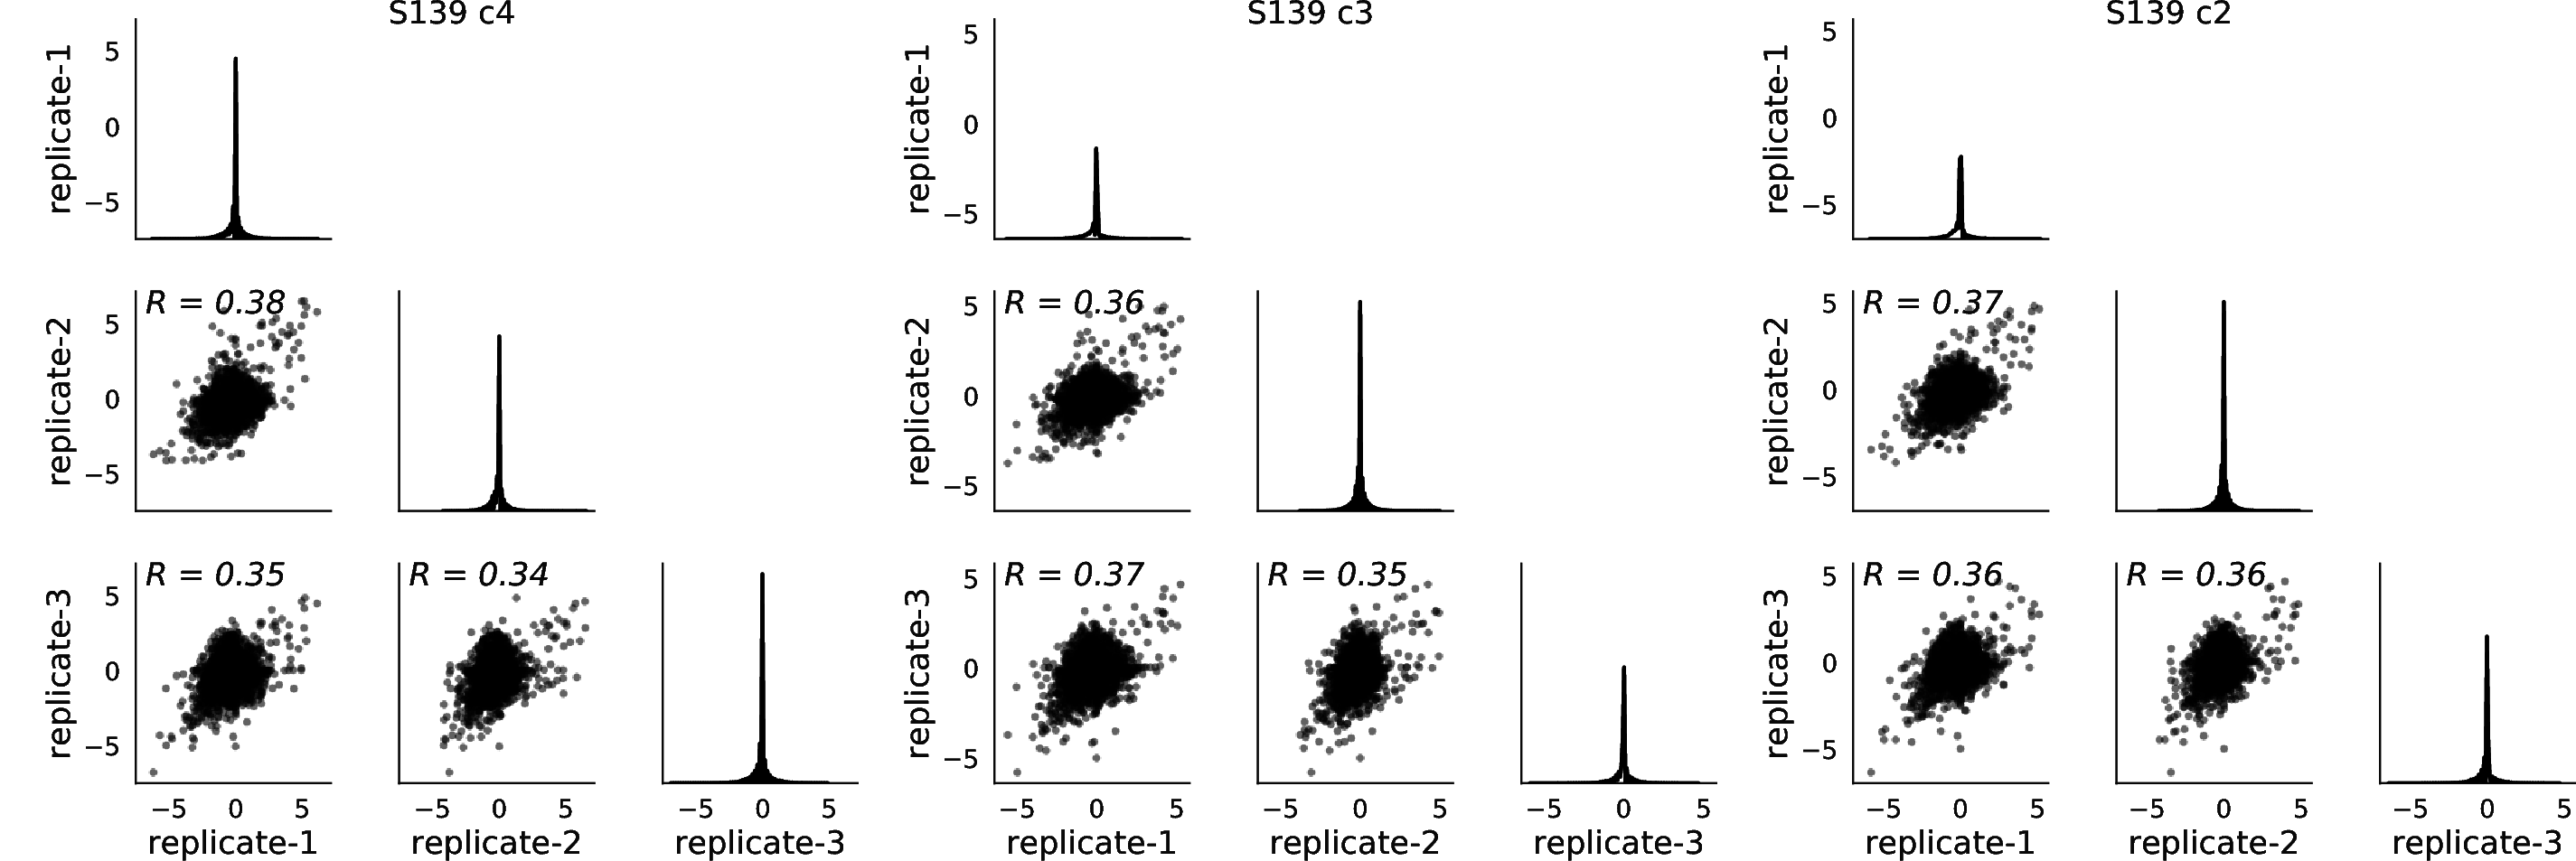

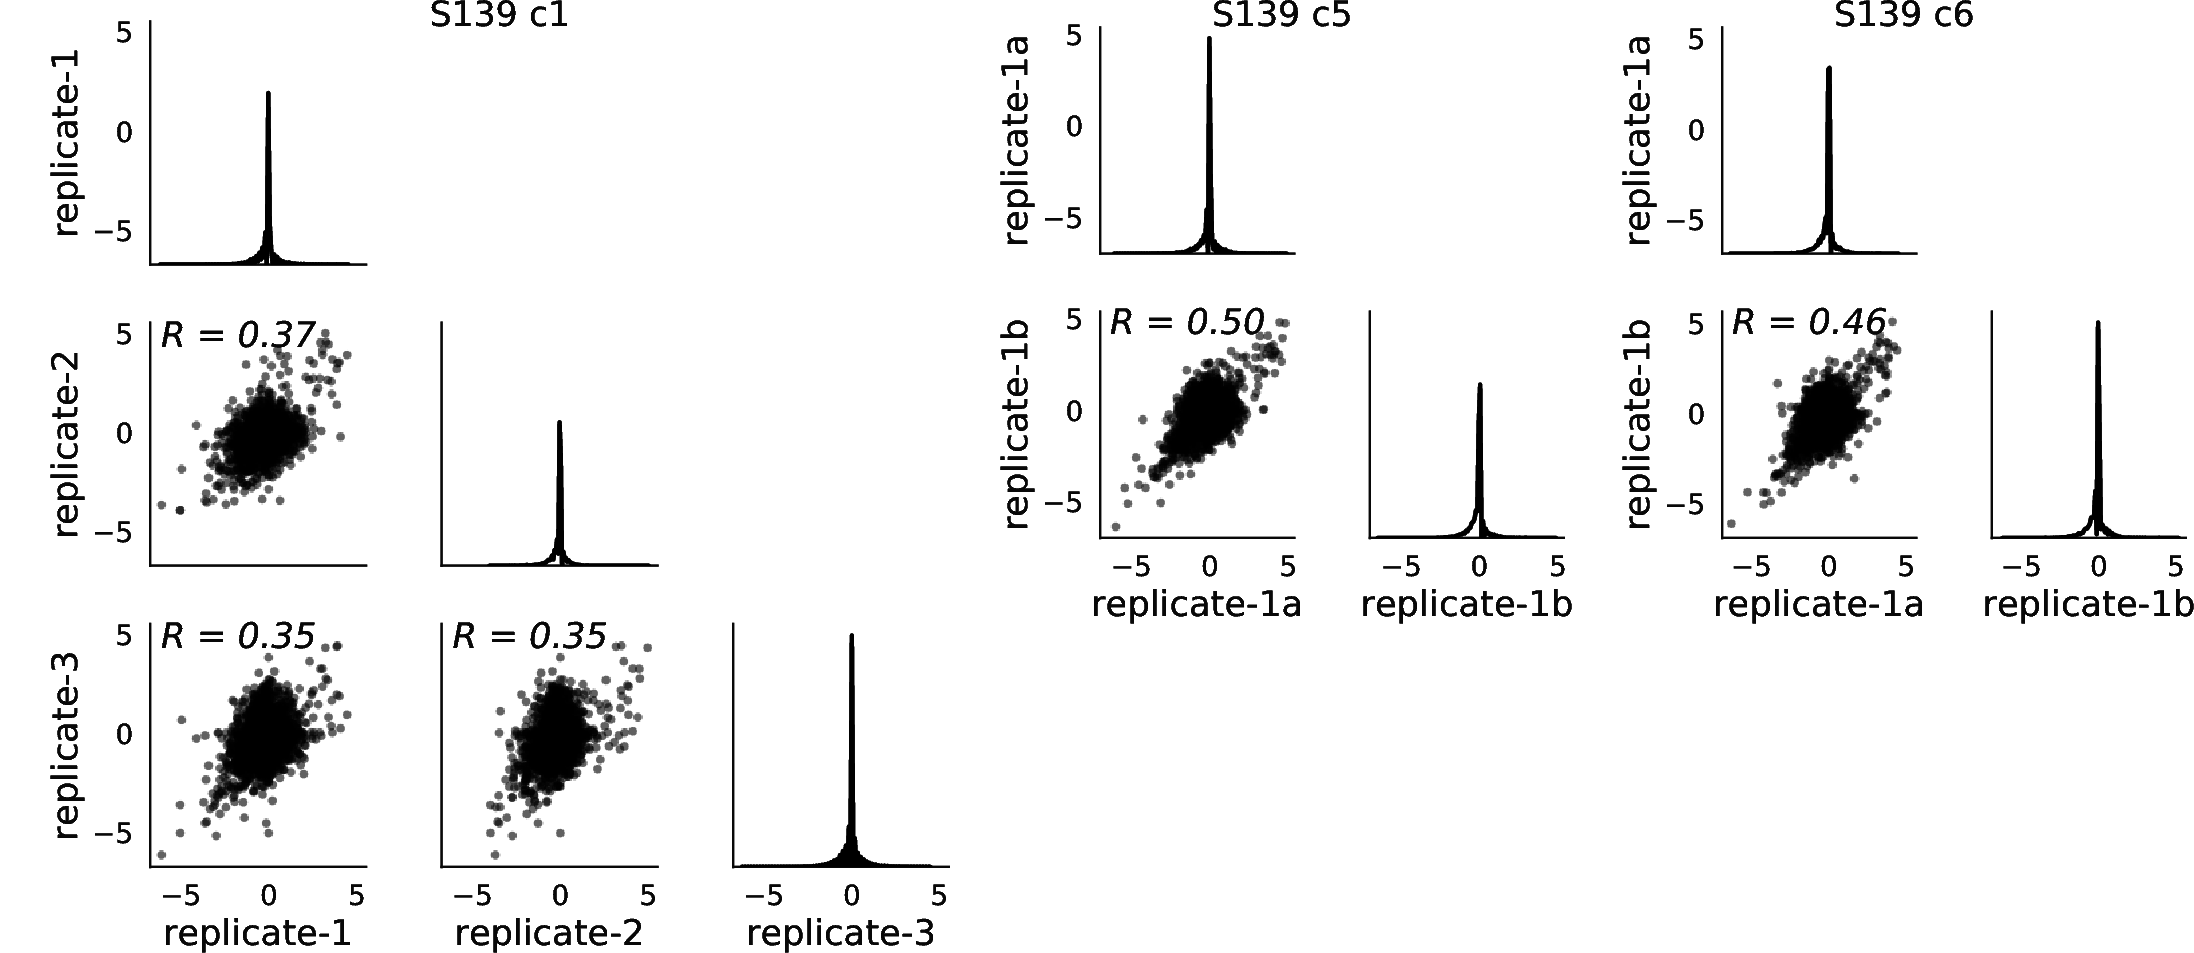

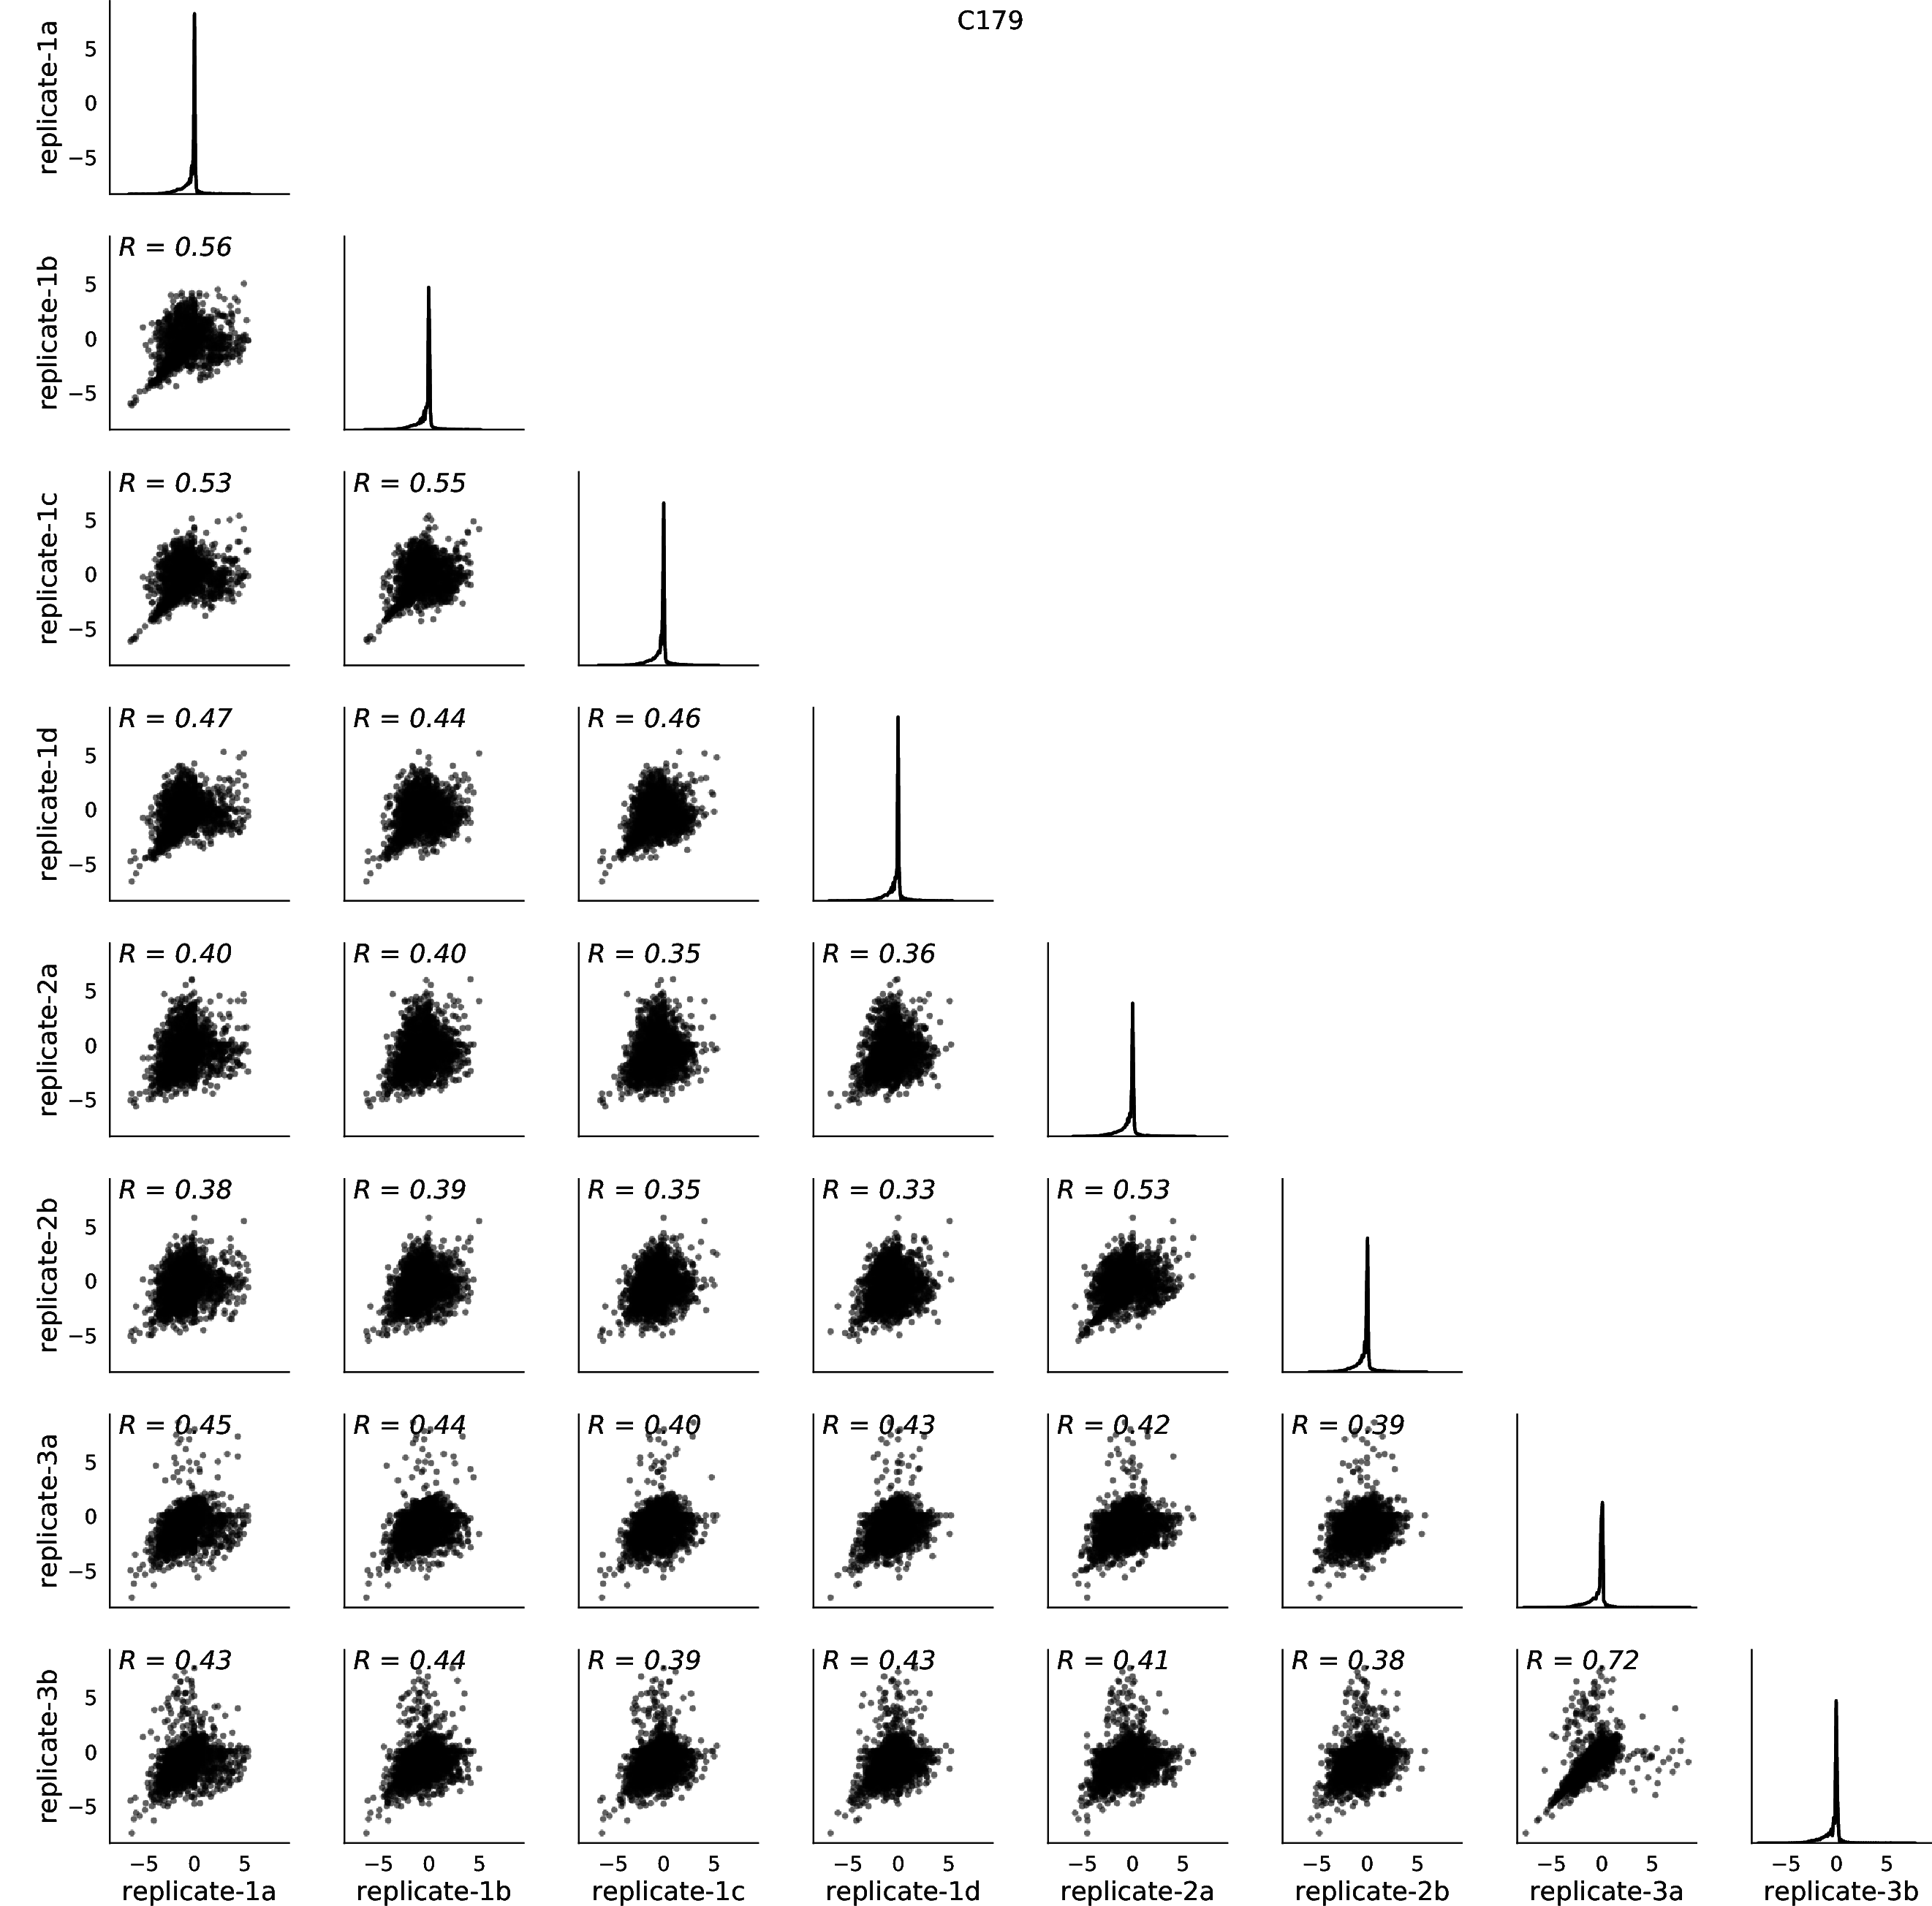

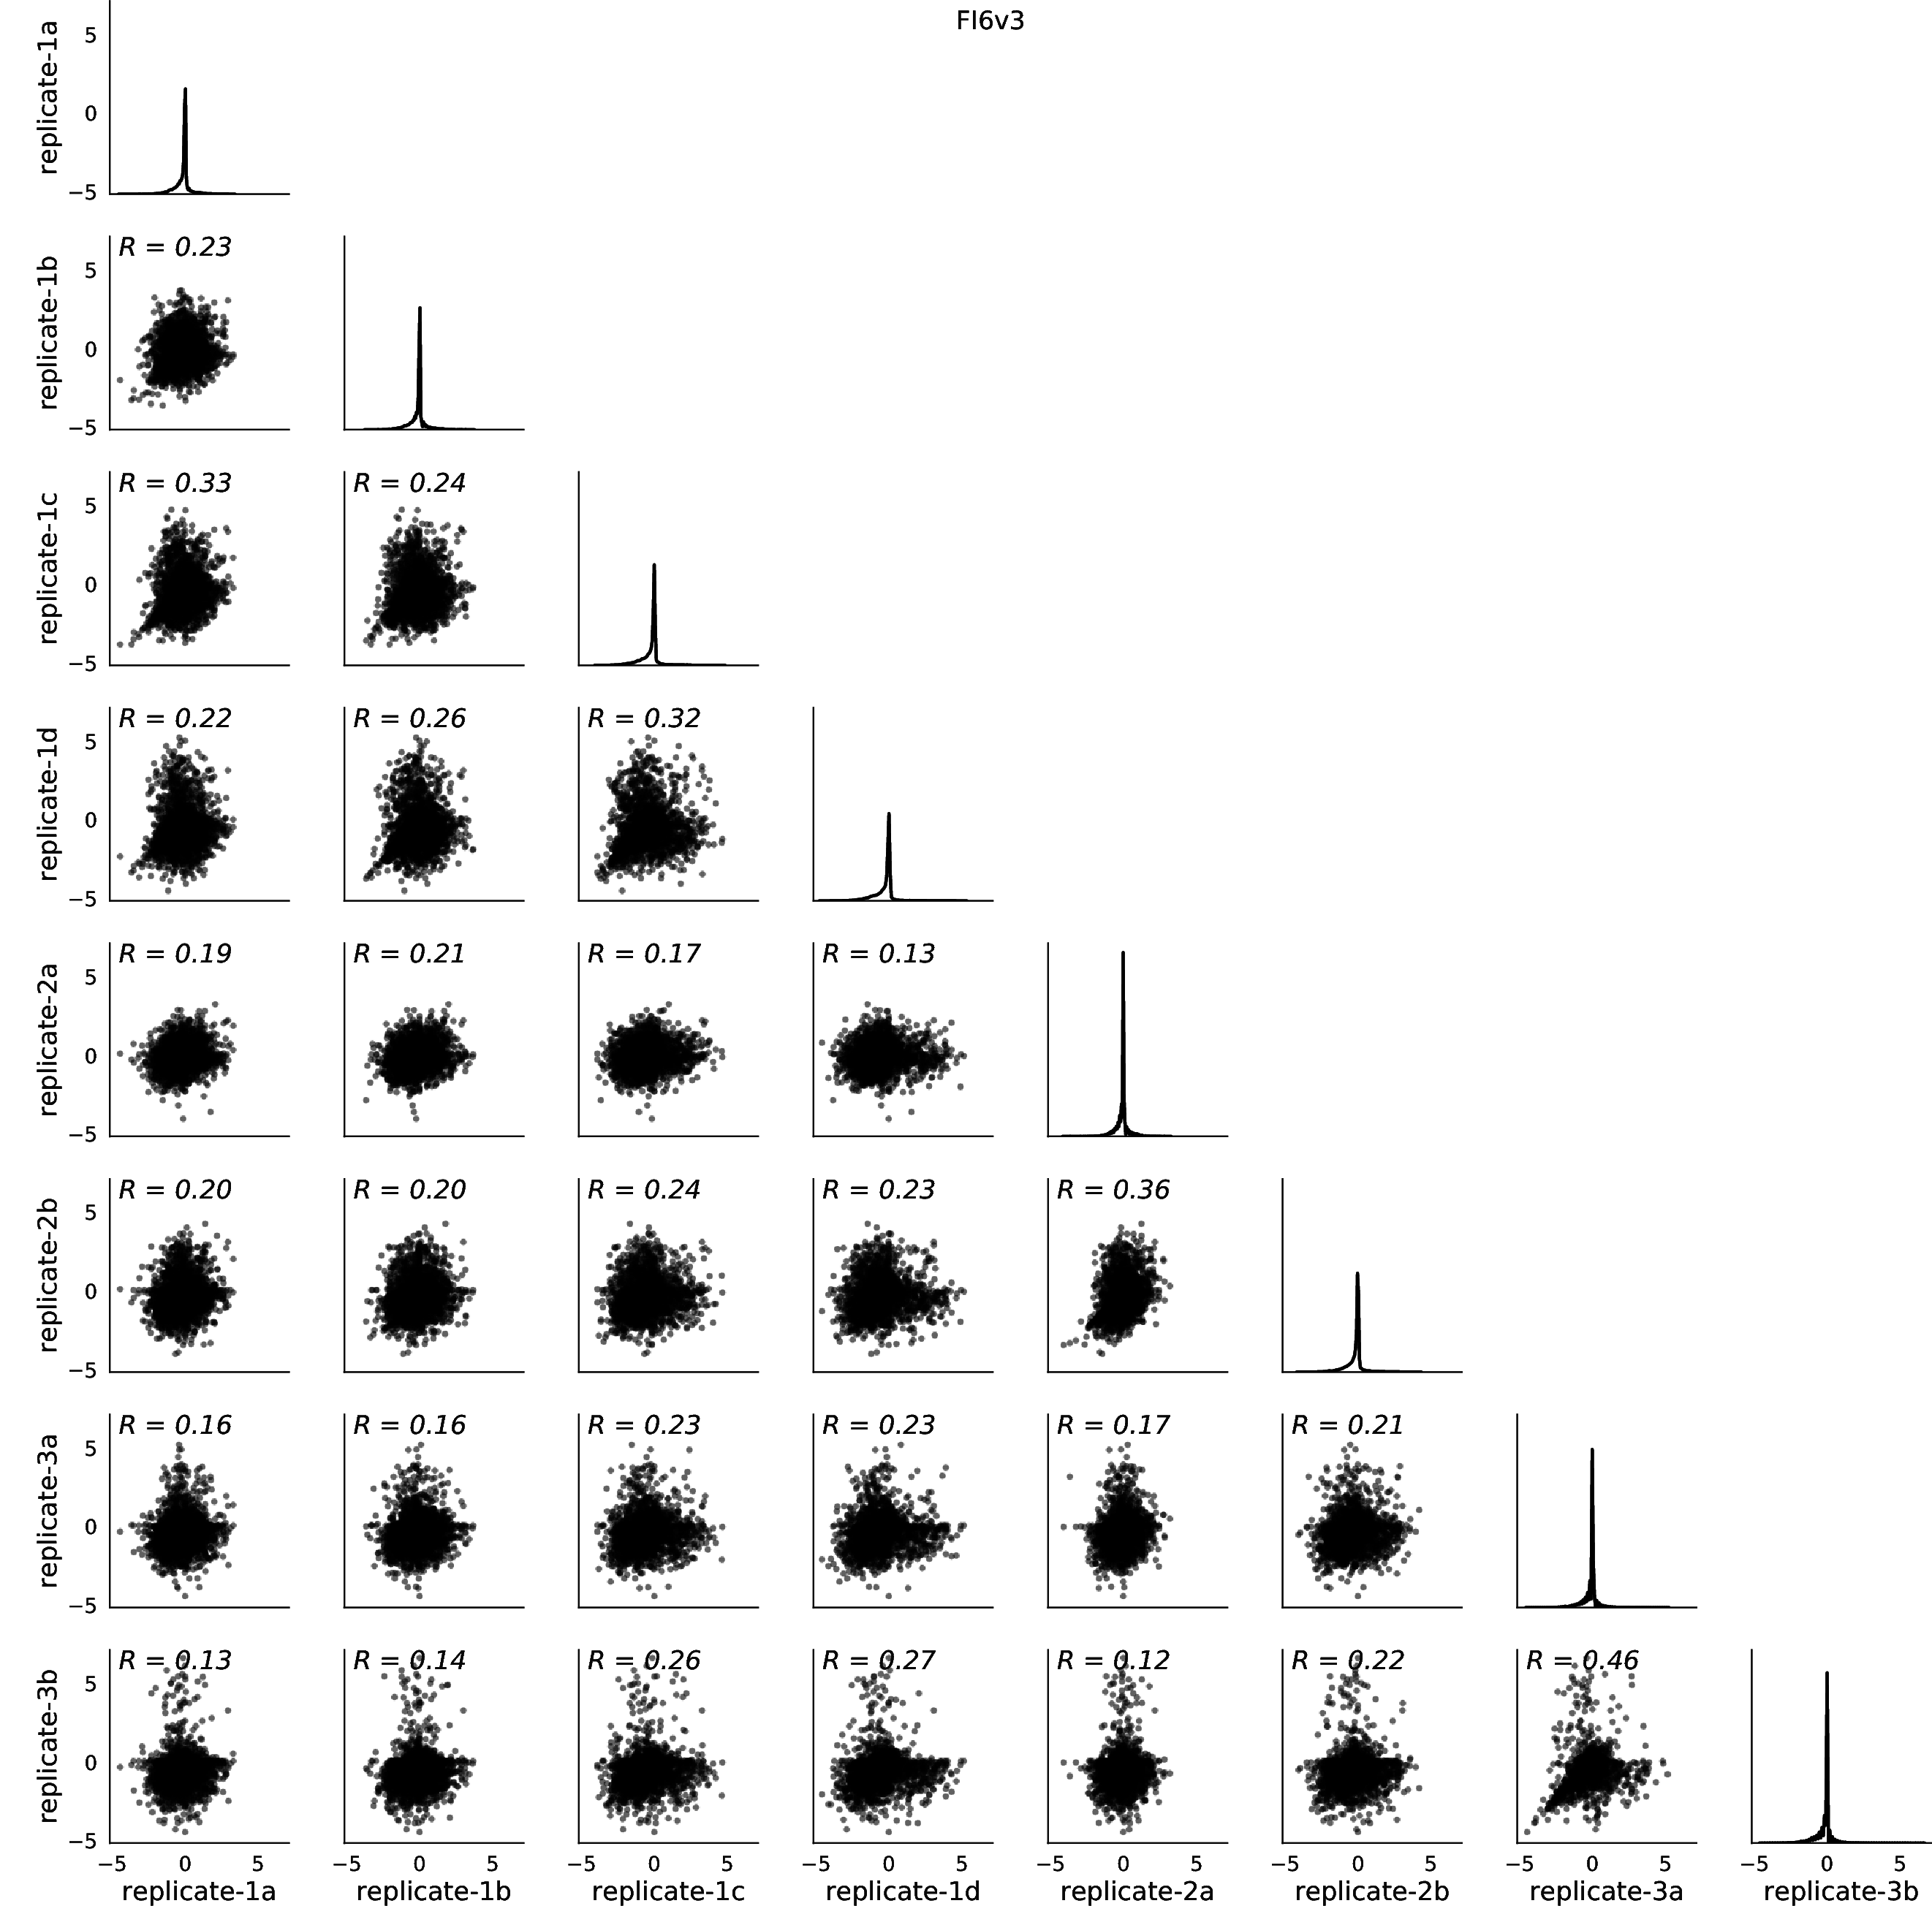

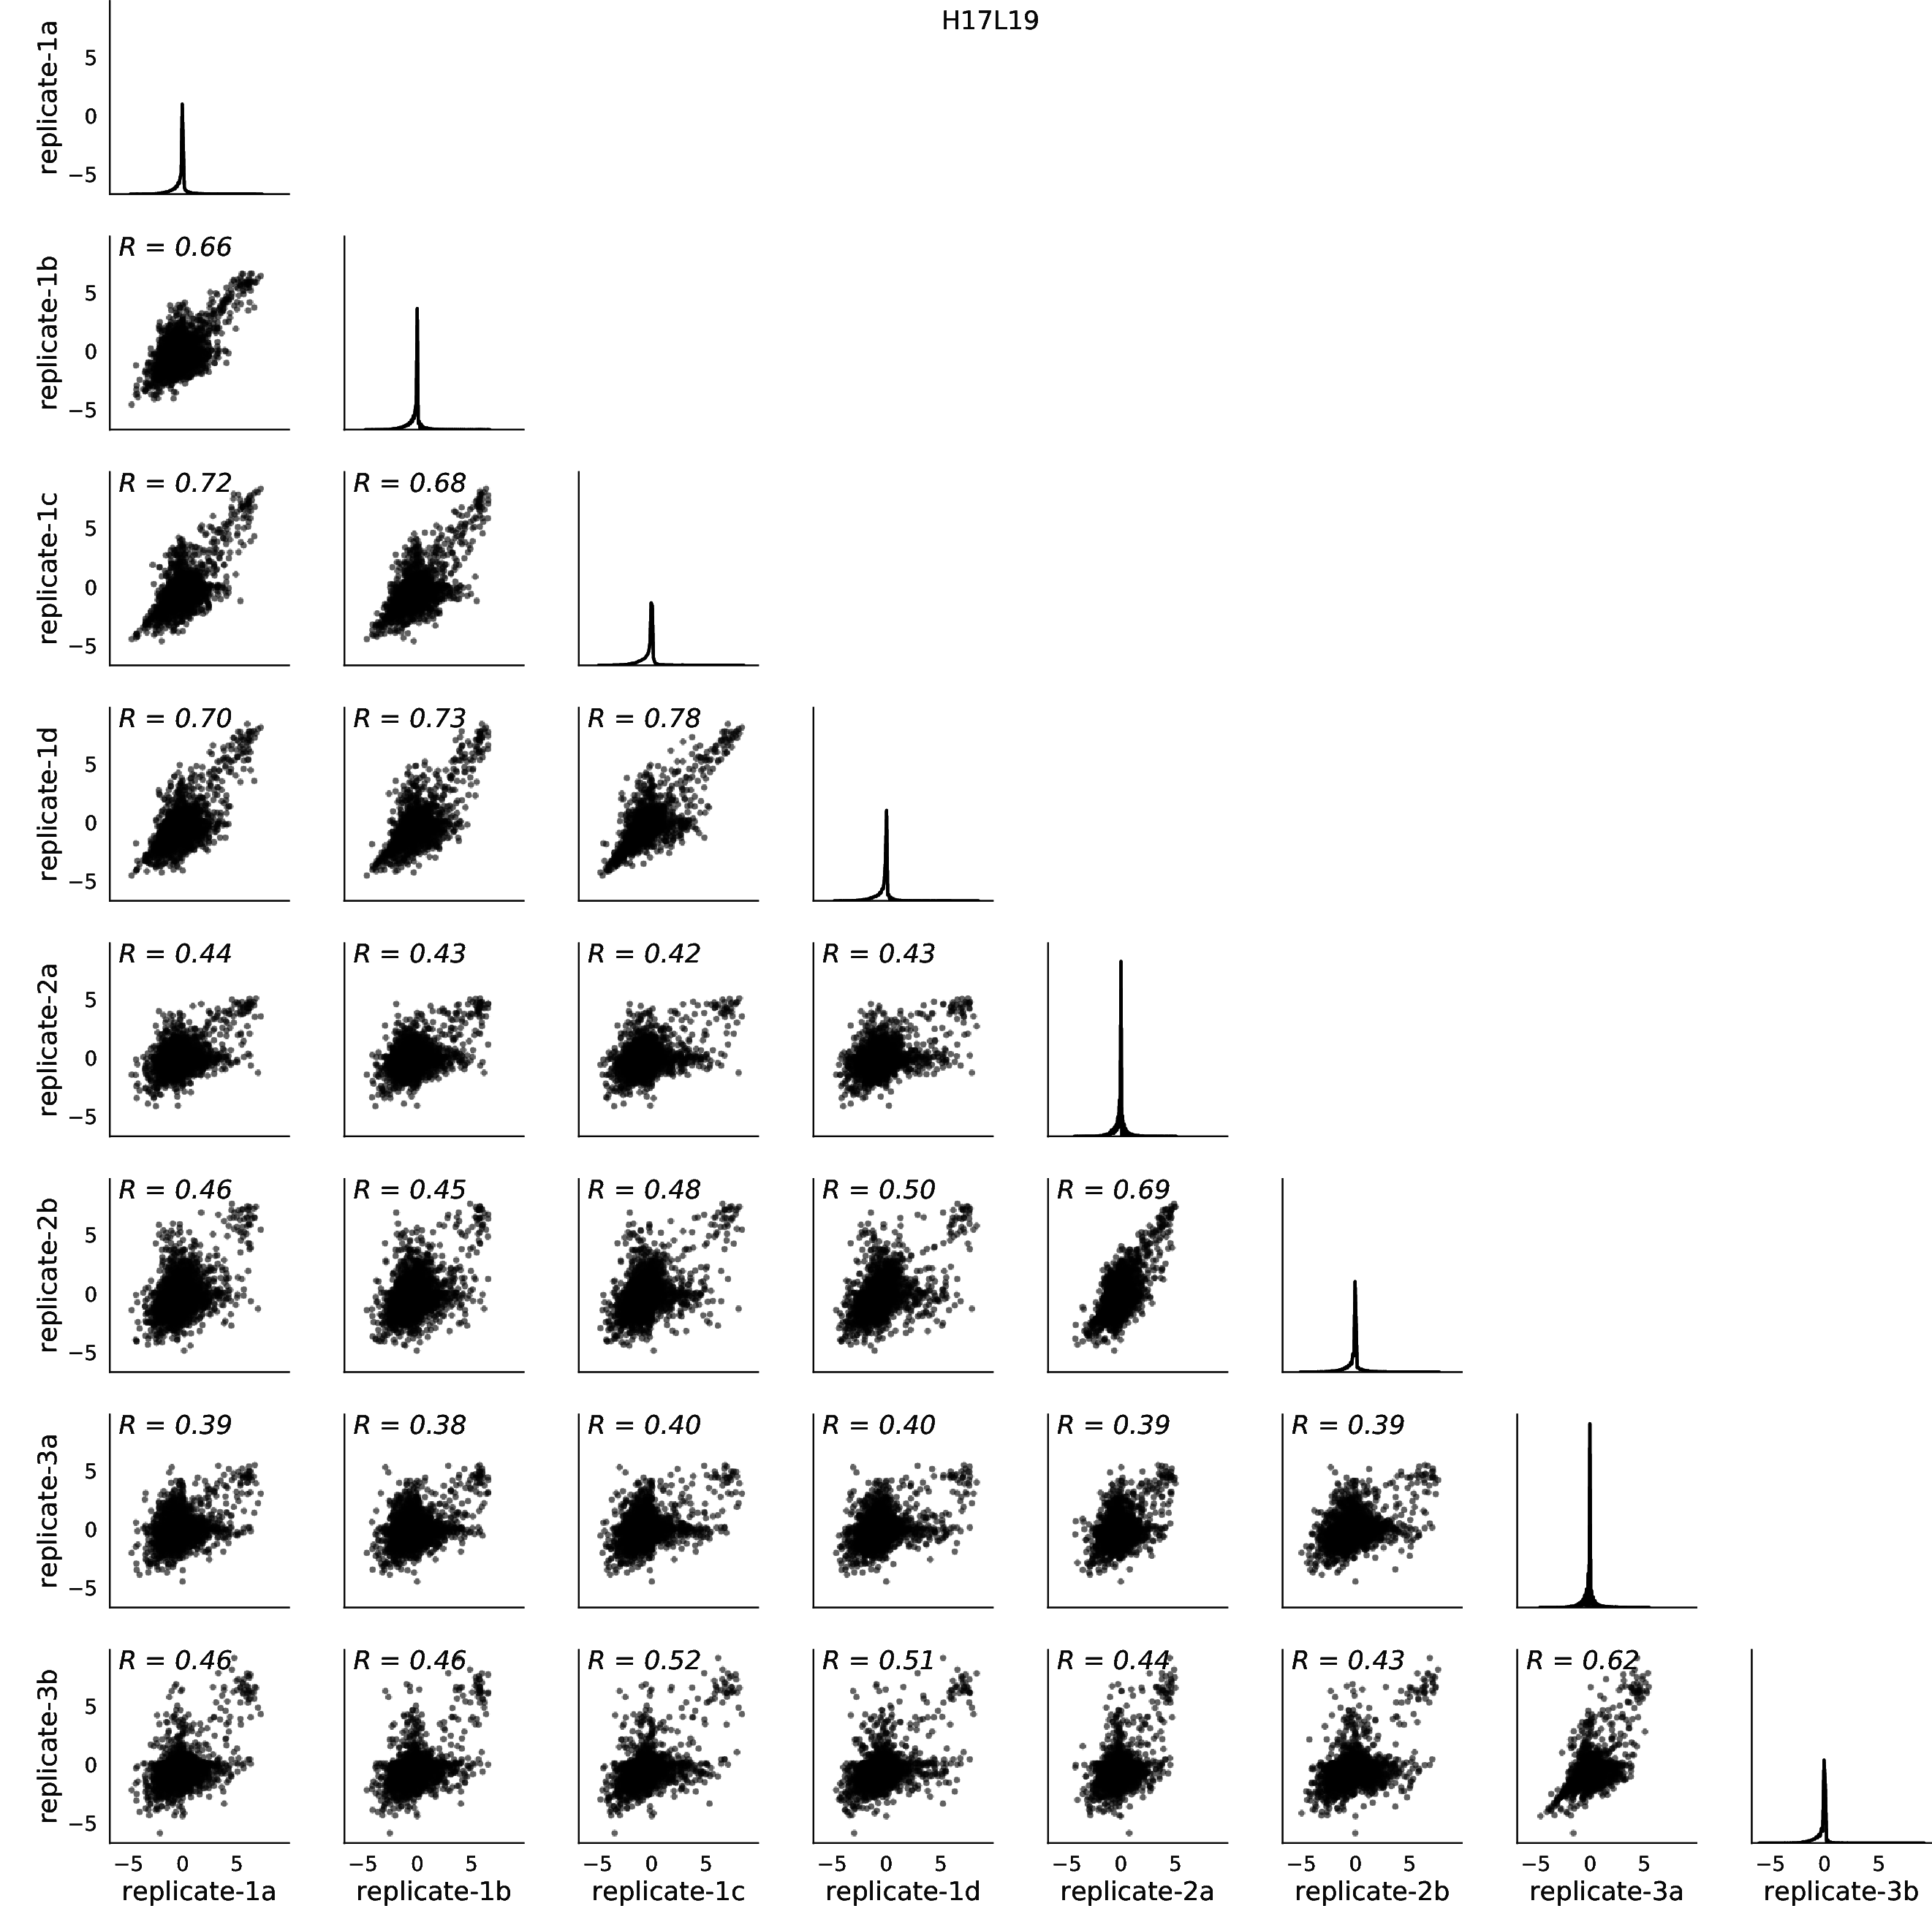


positivesitediffsel correlations:


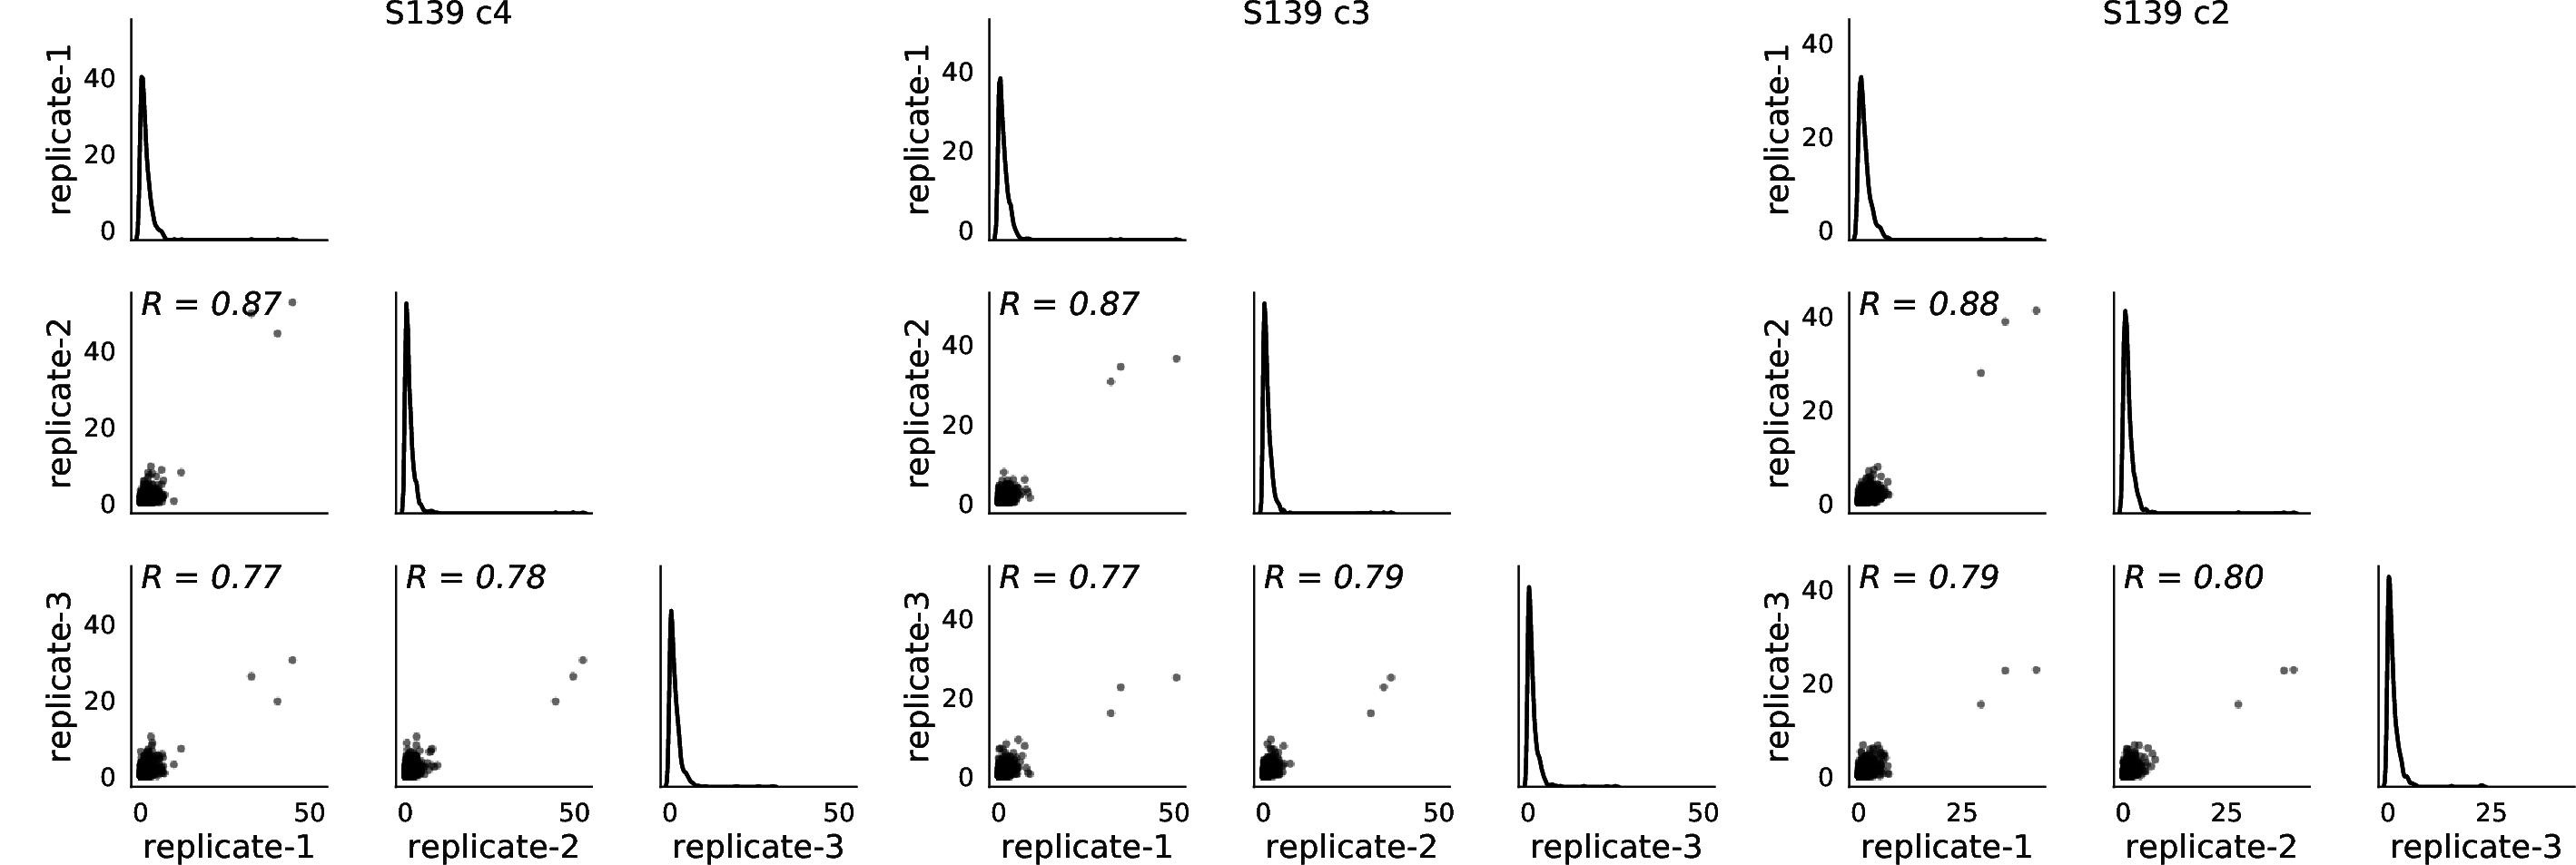

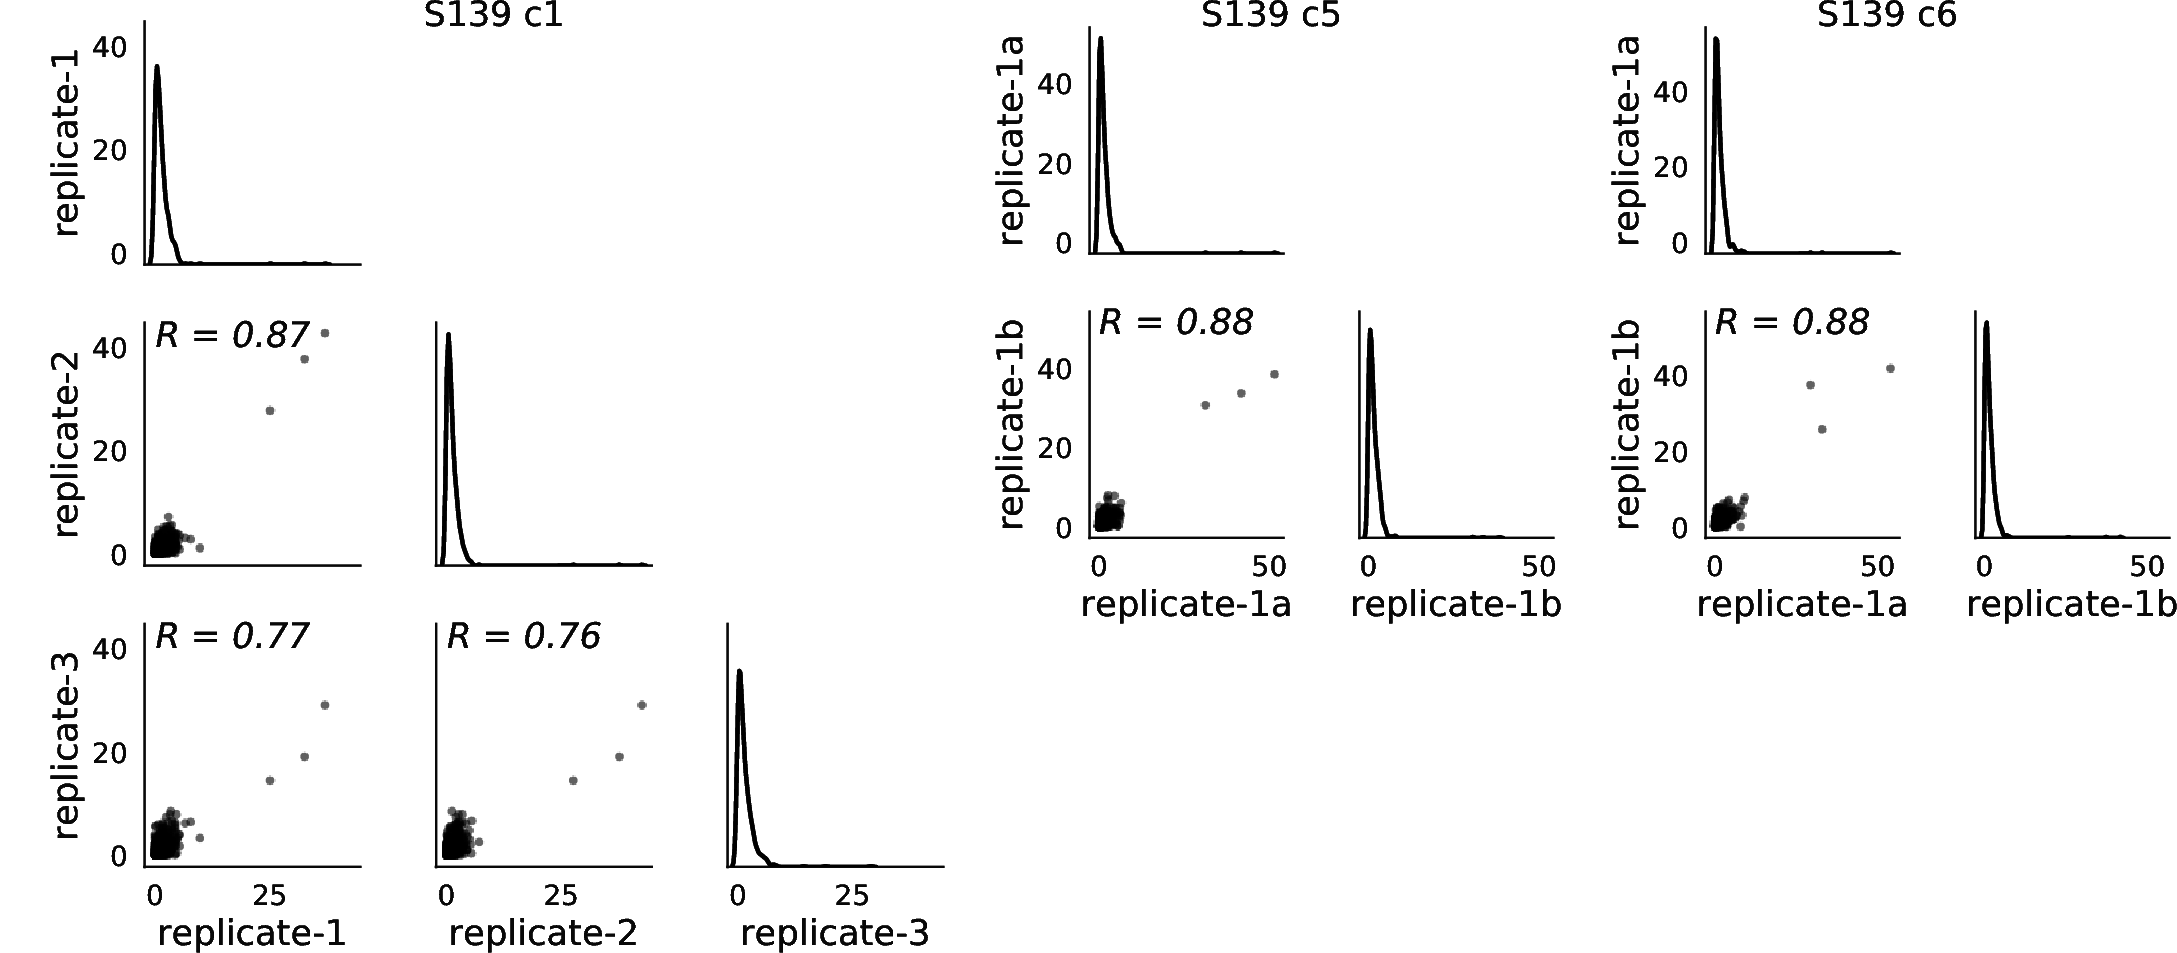

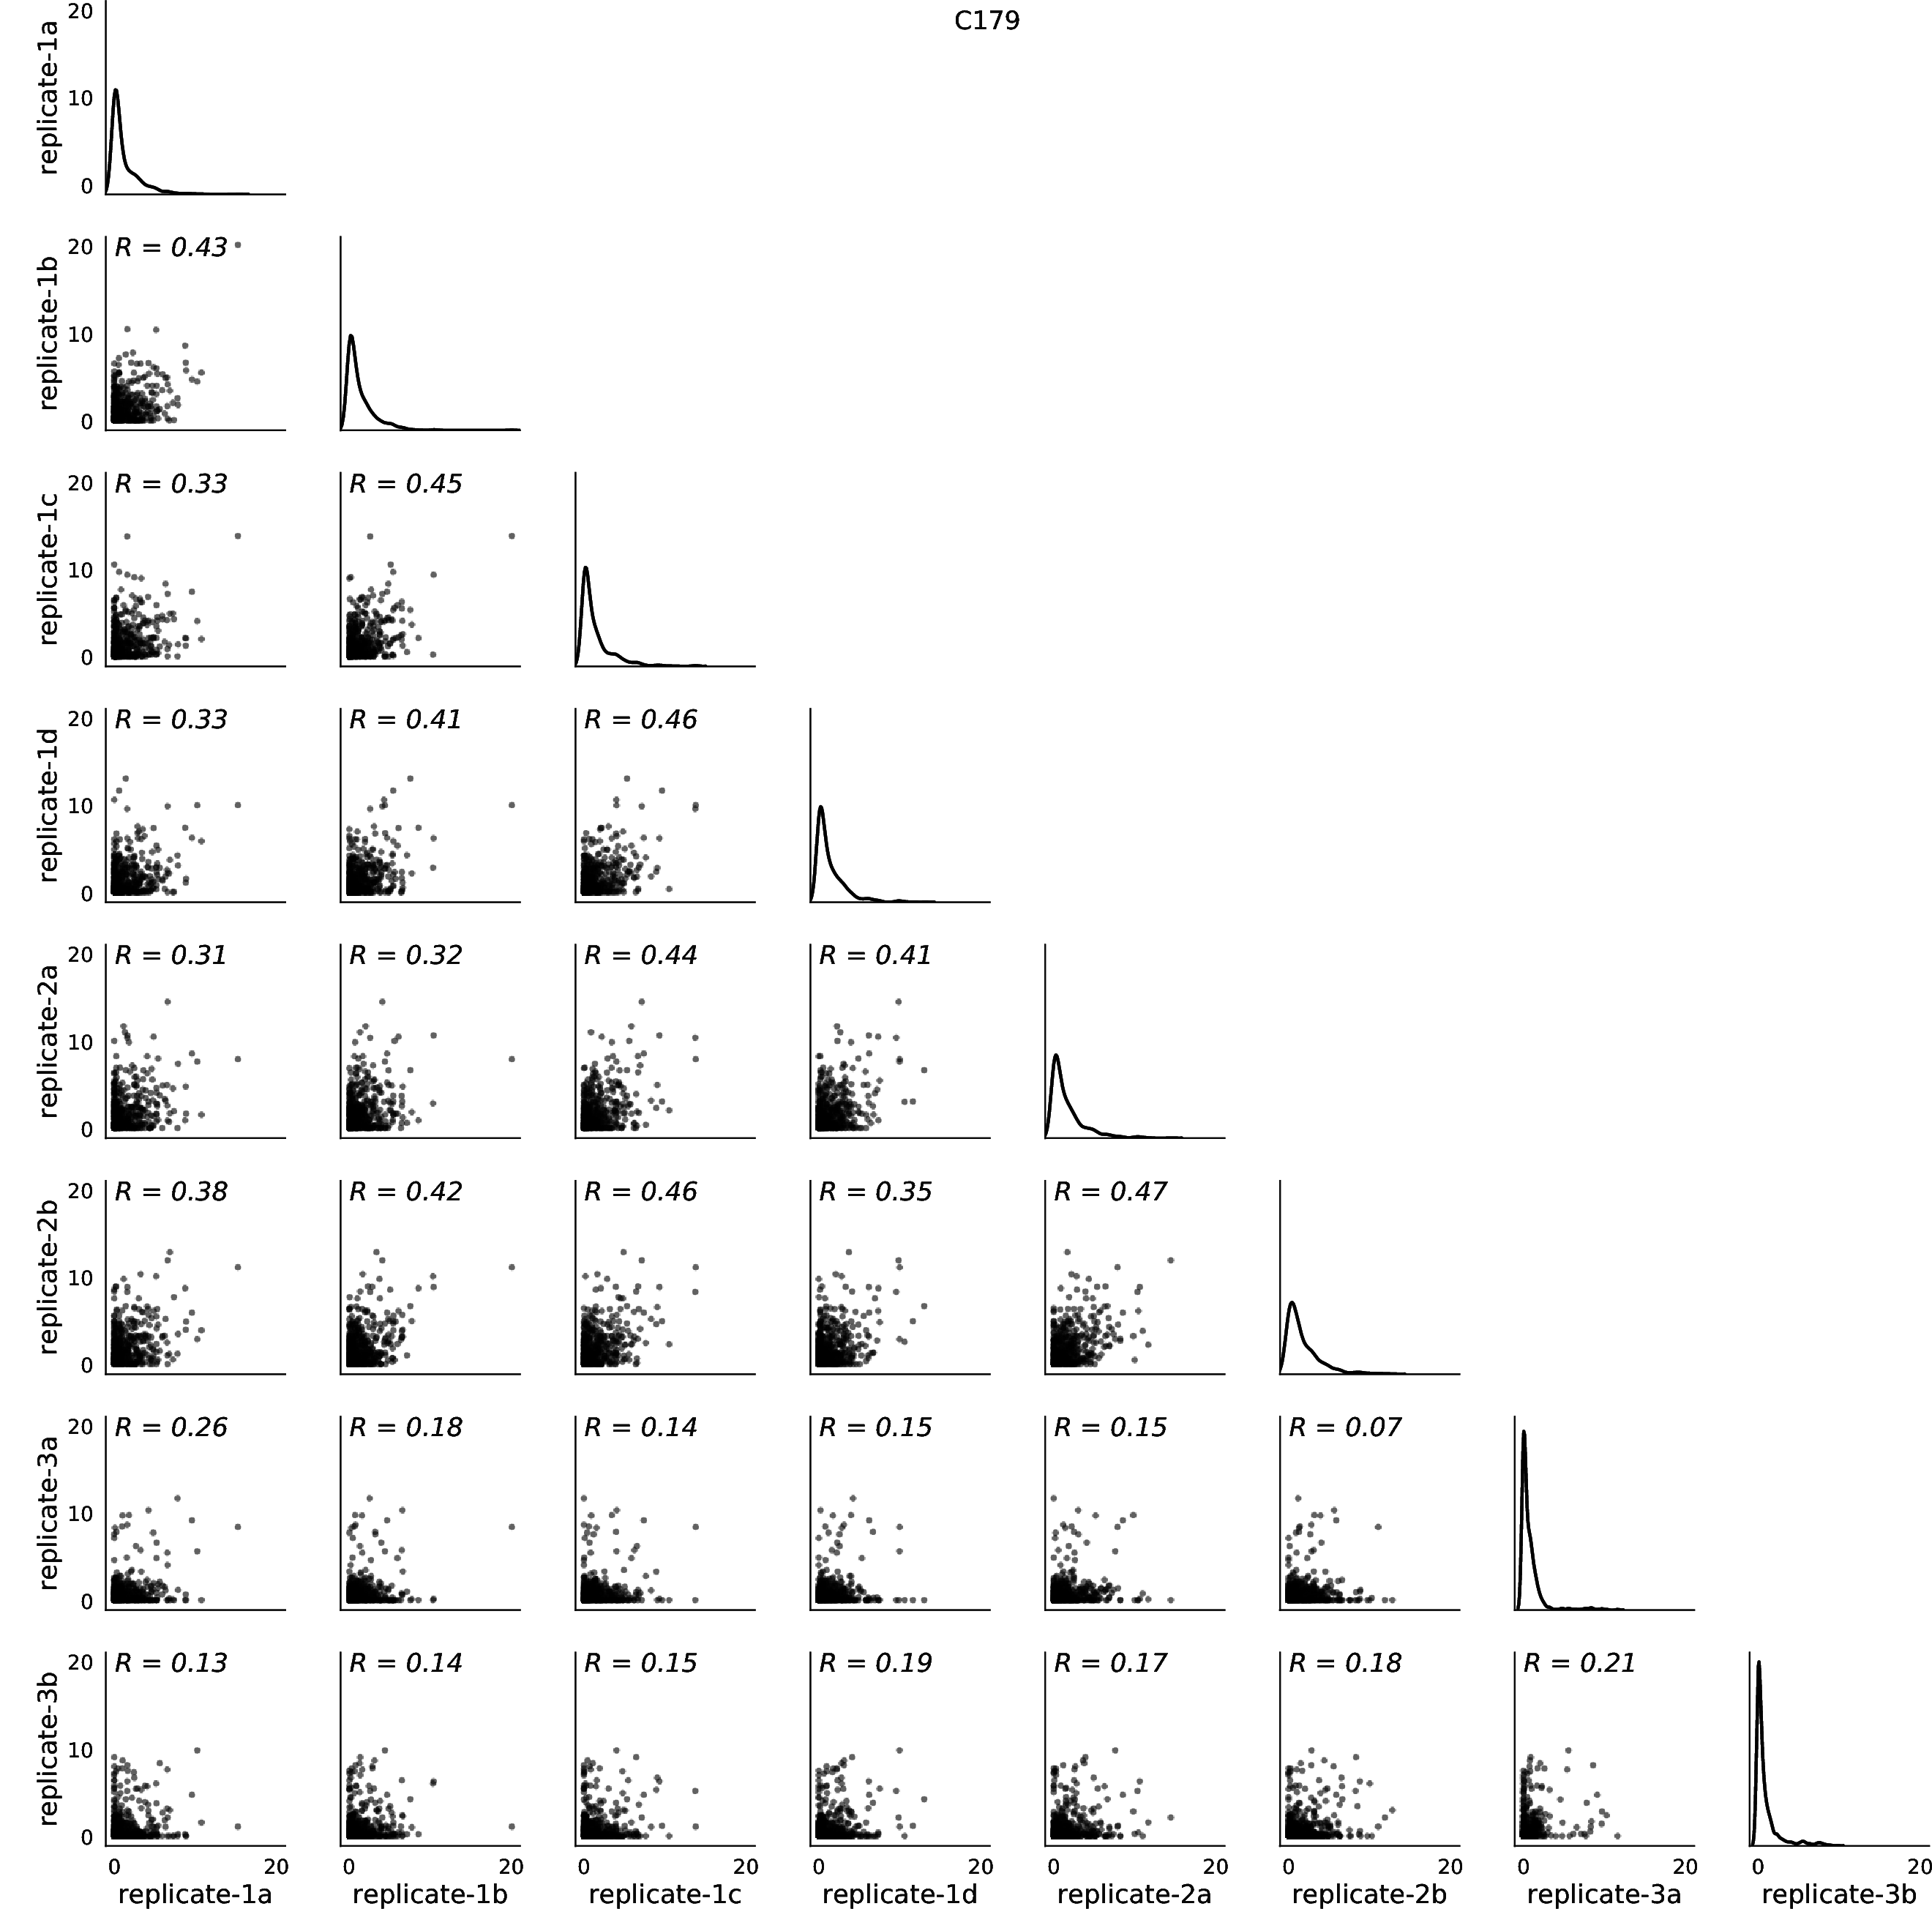

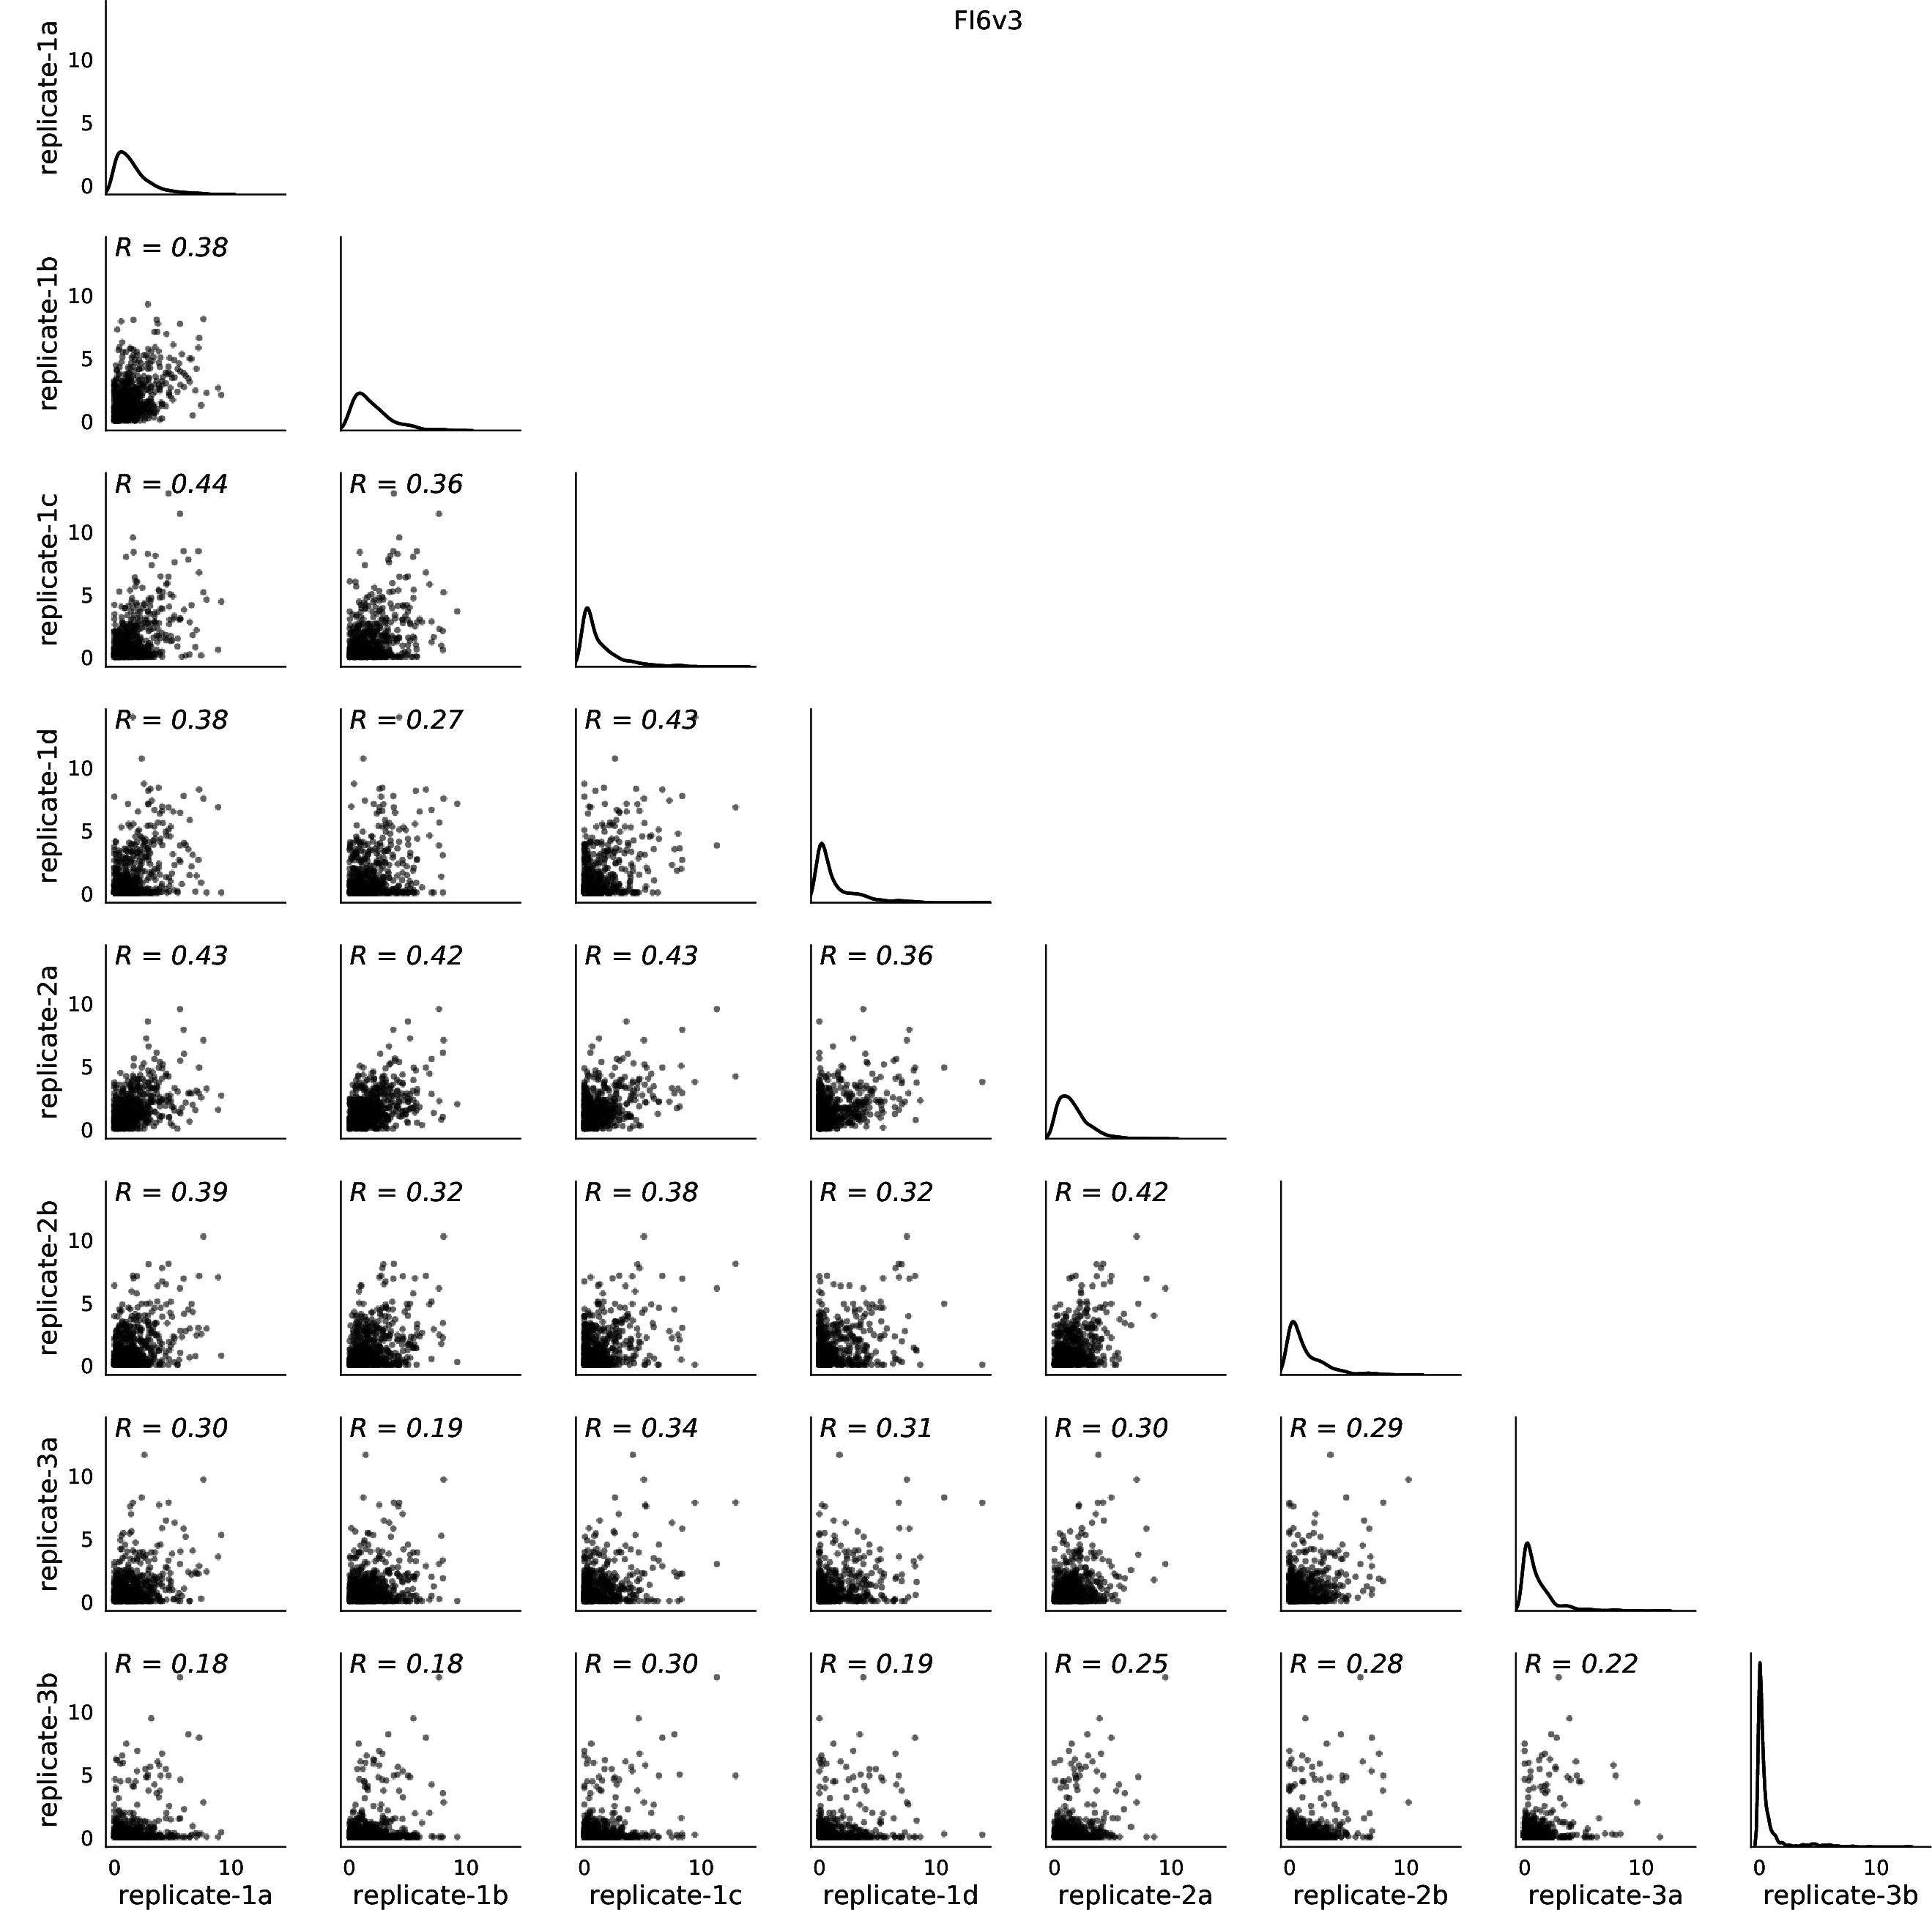

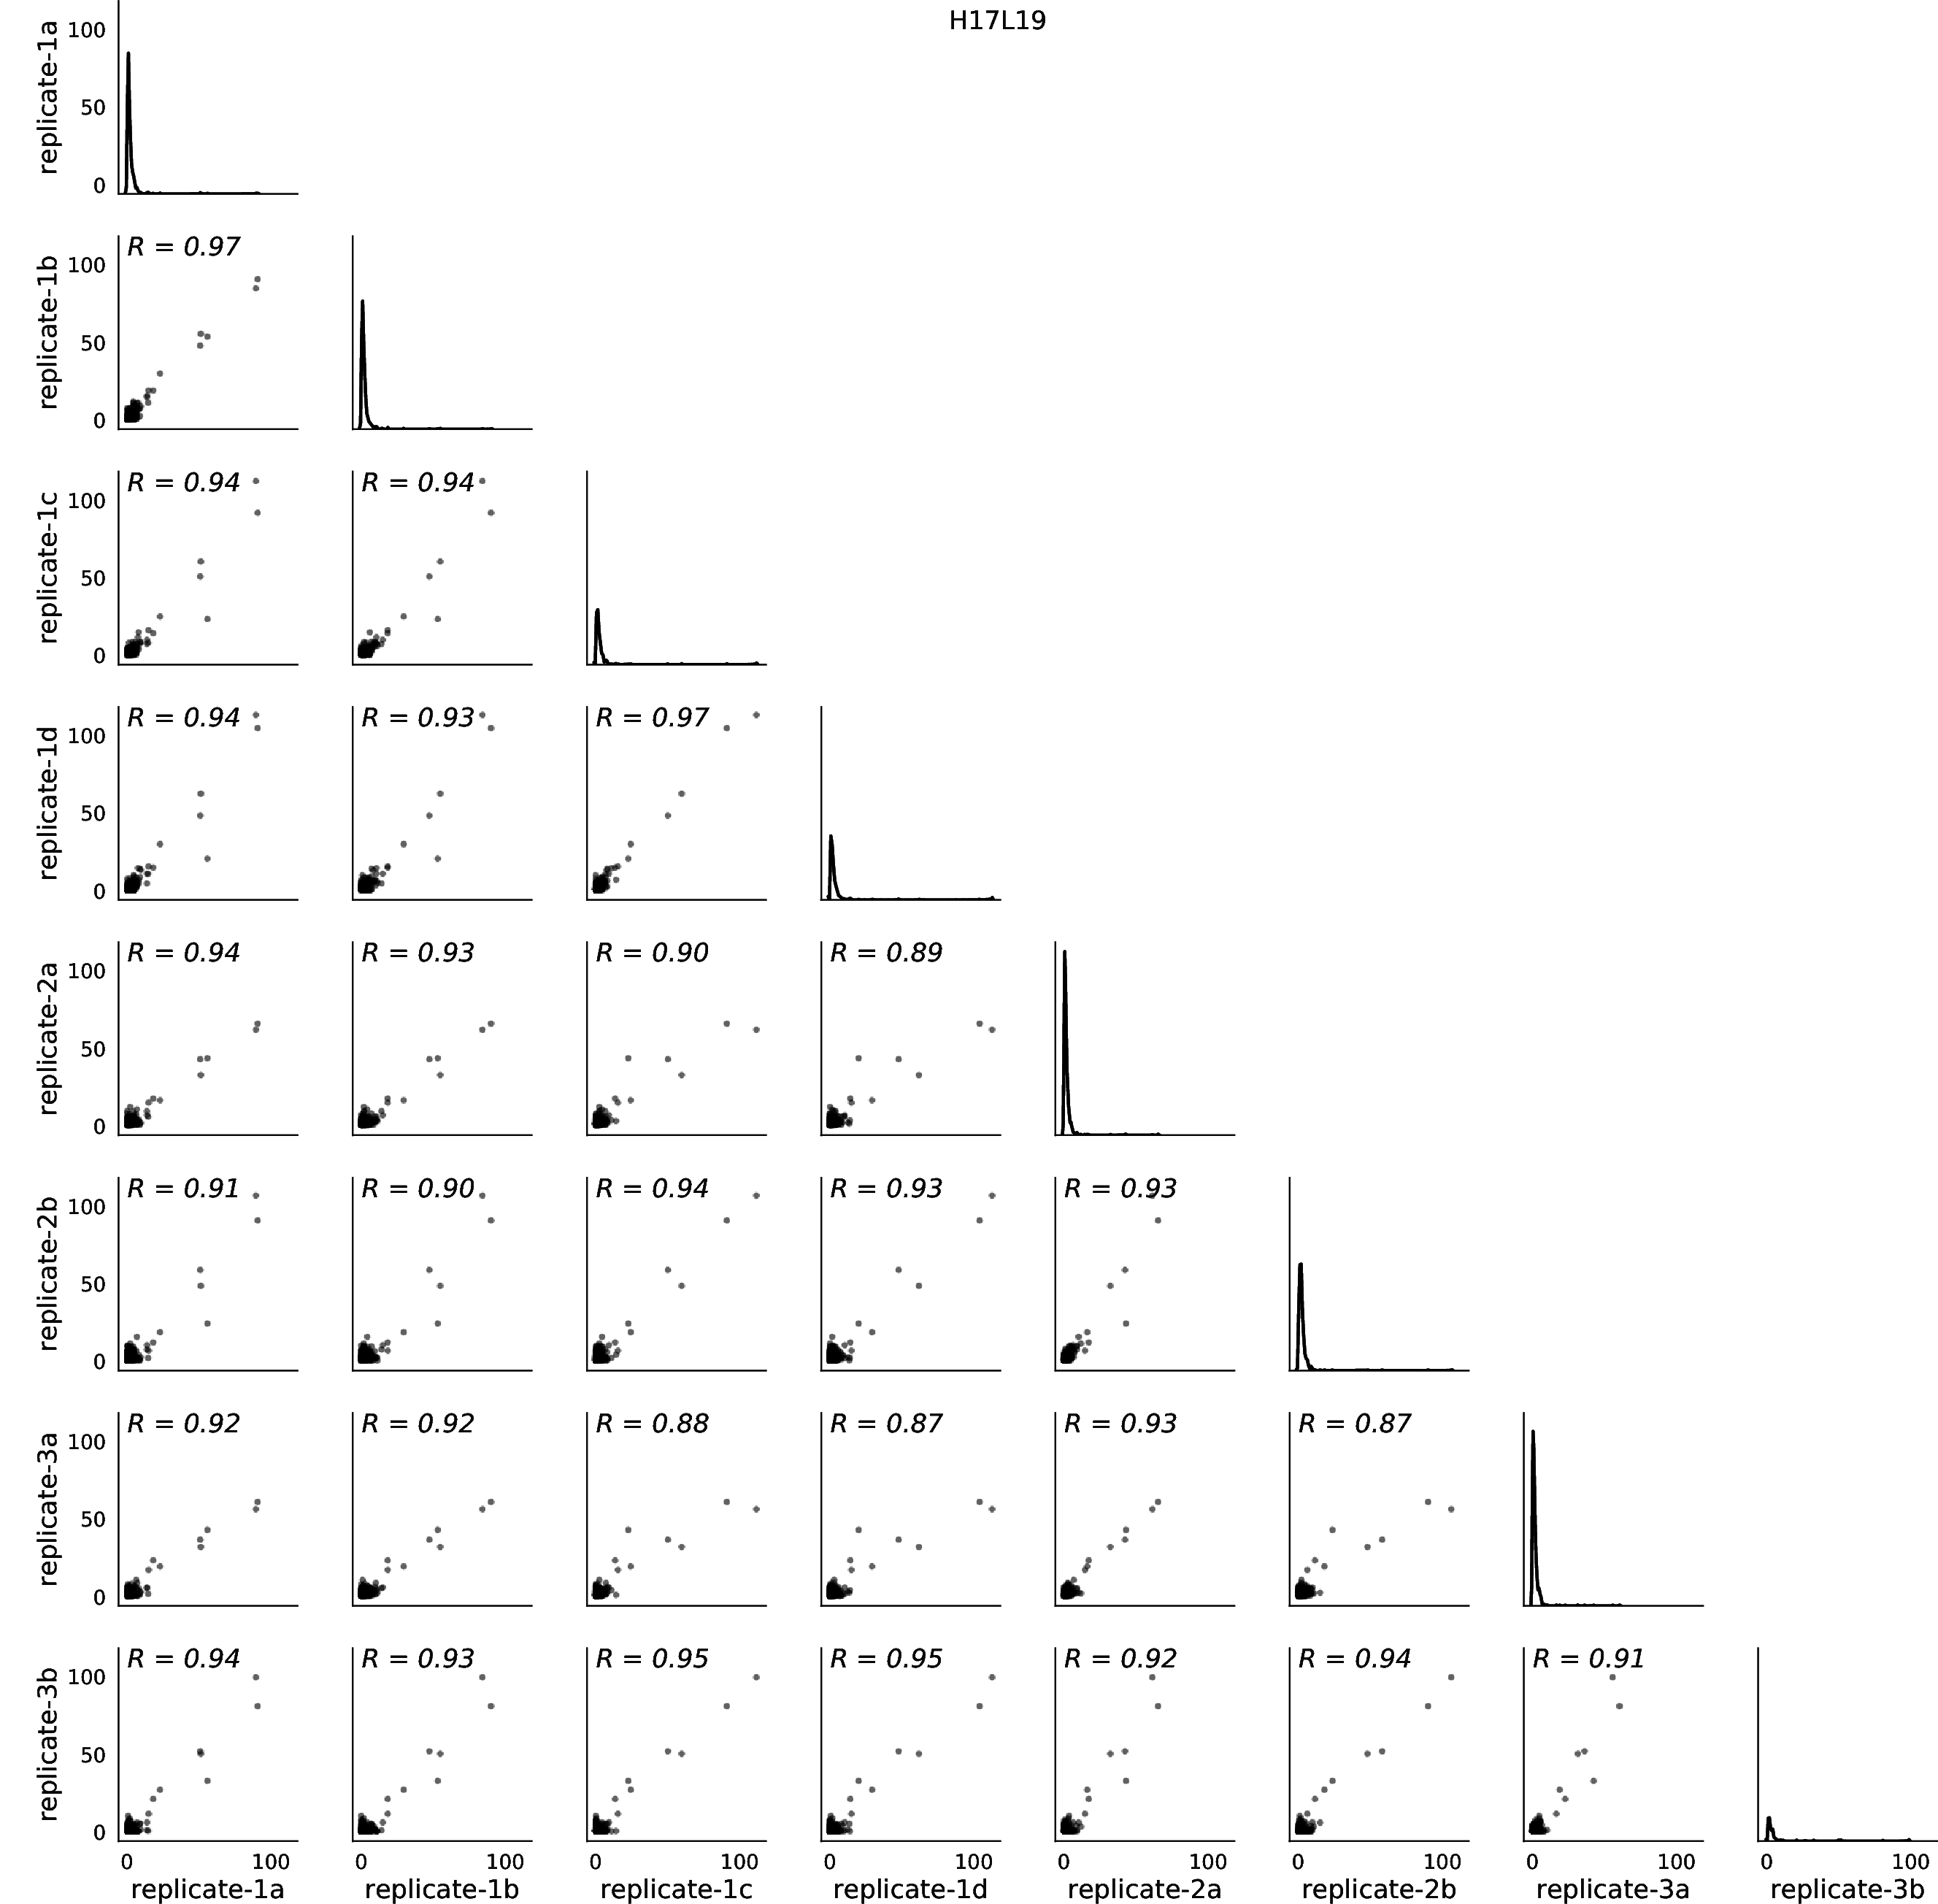

In [27]:
diffselprefix = os.path.join(diffseldir, 'summary_')
groups = diffselbatch['group'].unique()

for seltype in ['mutdiffsel', 'positivesitediffsel']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    for g in groups:
        plot = diffselprefix + g + '-' + seltype + 'corr.pdf'
        plots.append(plot)
    showPDF(plots[ : 3]) # show first 3 plots
    showPDF(plots[3 : 6]) # show next 3 plots
    showPDF(plots[6 : 7], width=800) # show C179 plot
    showPDF(plots[7 : 8], width=800) # show FI6v3 plot
    showPDF(plots[8 : ], width=800) # show remaining plots

The antibodies that are relatively 'easy to escape' from (namely S139/1 and H17L19), show good correlation for positive site differential selection between the various replicates.
However, the two stalk-targeting antibodies, FI6v3 and C179, show weak correlation between replicates for site differential selection.

### Show correlation between the different concentrations of S139/1

/home/jmlee34/.local/lib/python3.4/site-packages/matplotlib/tight_layout.py:226: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")
/home/jmlee34/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


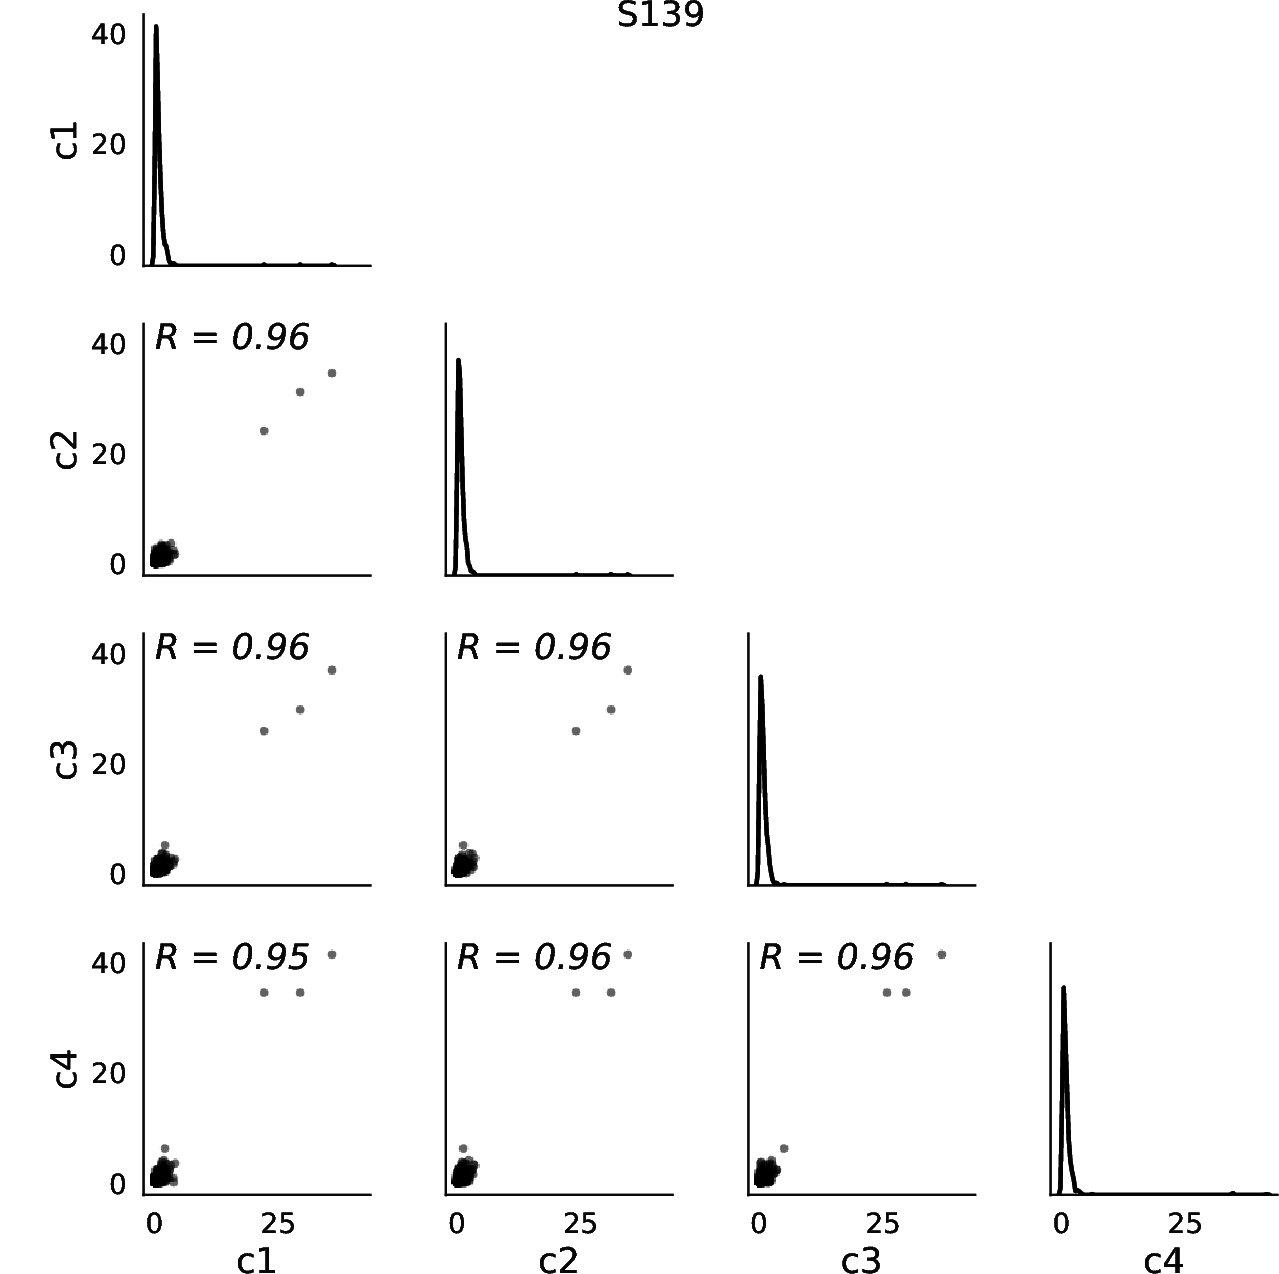

In [26]:
concs = ['c4', 'c3', 'c2', 'c1']
plotfile = diffselprefix + 'conc_corr_S139.pdf'
dms_tools2.plot.plotCorrMatrix(
        concs,
        [diffselprefix + 'S139-{0}-meansitediffsel.csv'.format(c) 
                for c in concs],
        plotfile, 'positive_diffsel', title='S139')
showPDF(plotfile)

In [27]:
!ls {diffseldir}/*diffsel.pdf

./results/differential_selections//summary_meanmaxdiffsel.pdf
./results/differential_selections//summary_meanminmaxdiffsel.pdf
./results/differential_selections//summary_meanpositivediffsel.pdf
./results/differential_selections//summary_meantotaldiffsel.pdf
./results/differential_selections//summary_medianmaxdiffsel.pdf
./results/differential_selections//summary_medianminmaxdiffsel.pdf
./results/differential_selections//summary_medianpositivediffsel.pdf
./results/differential_selections//summary_mediantotaldiffsel.pdf


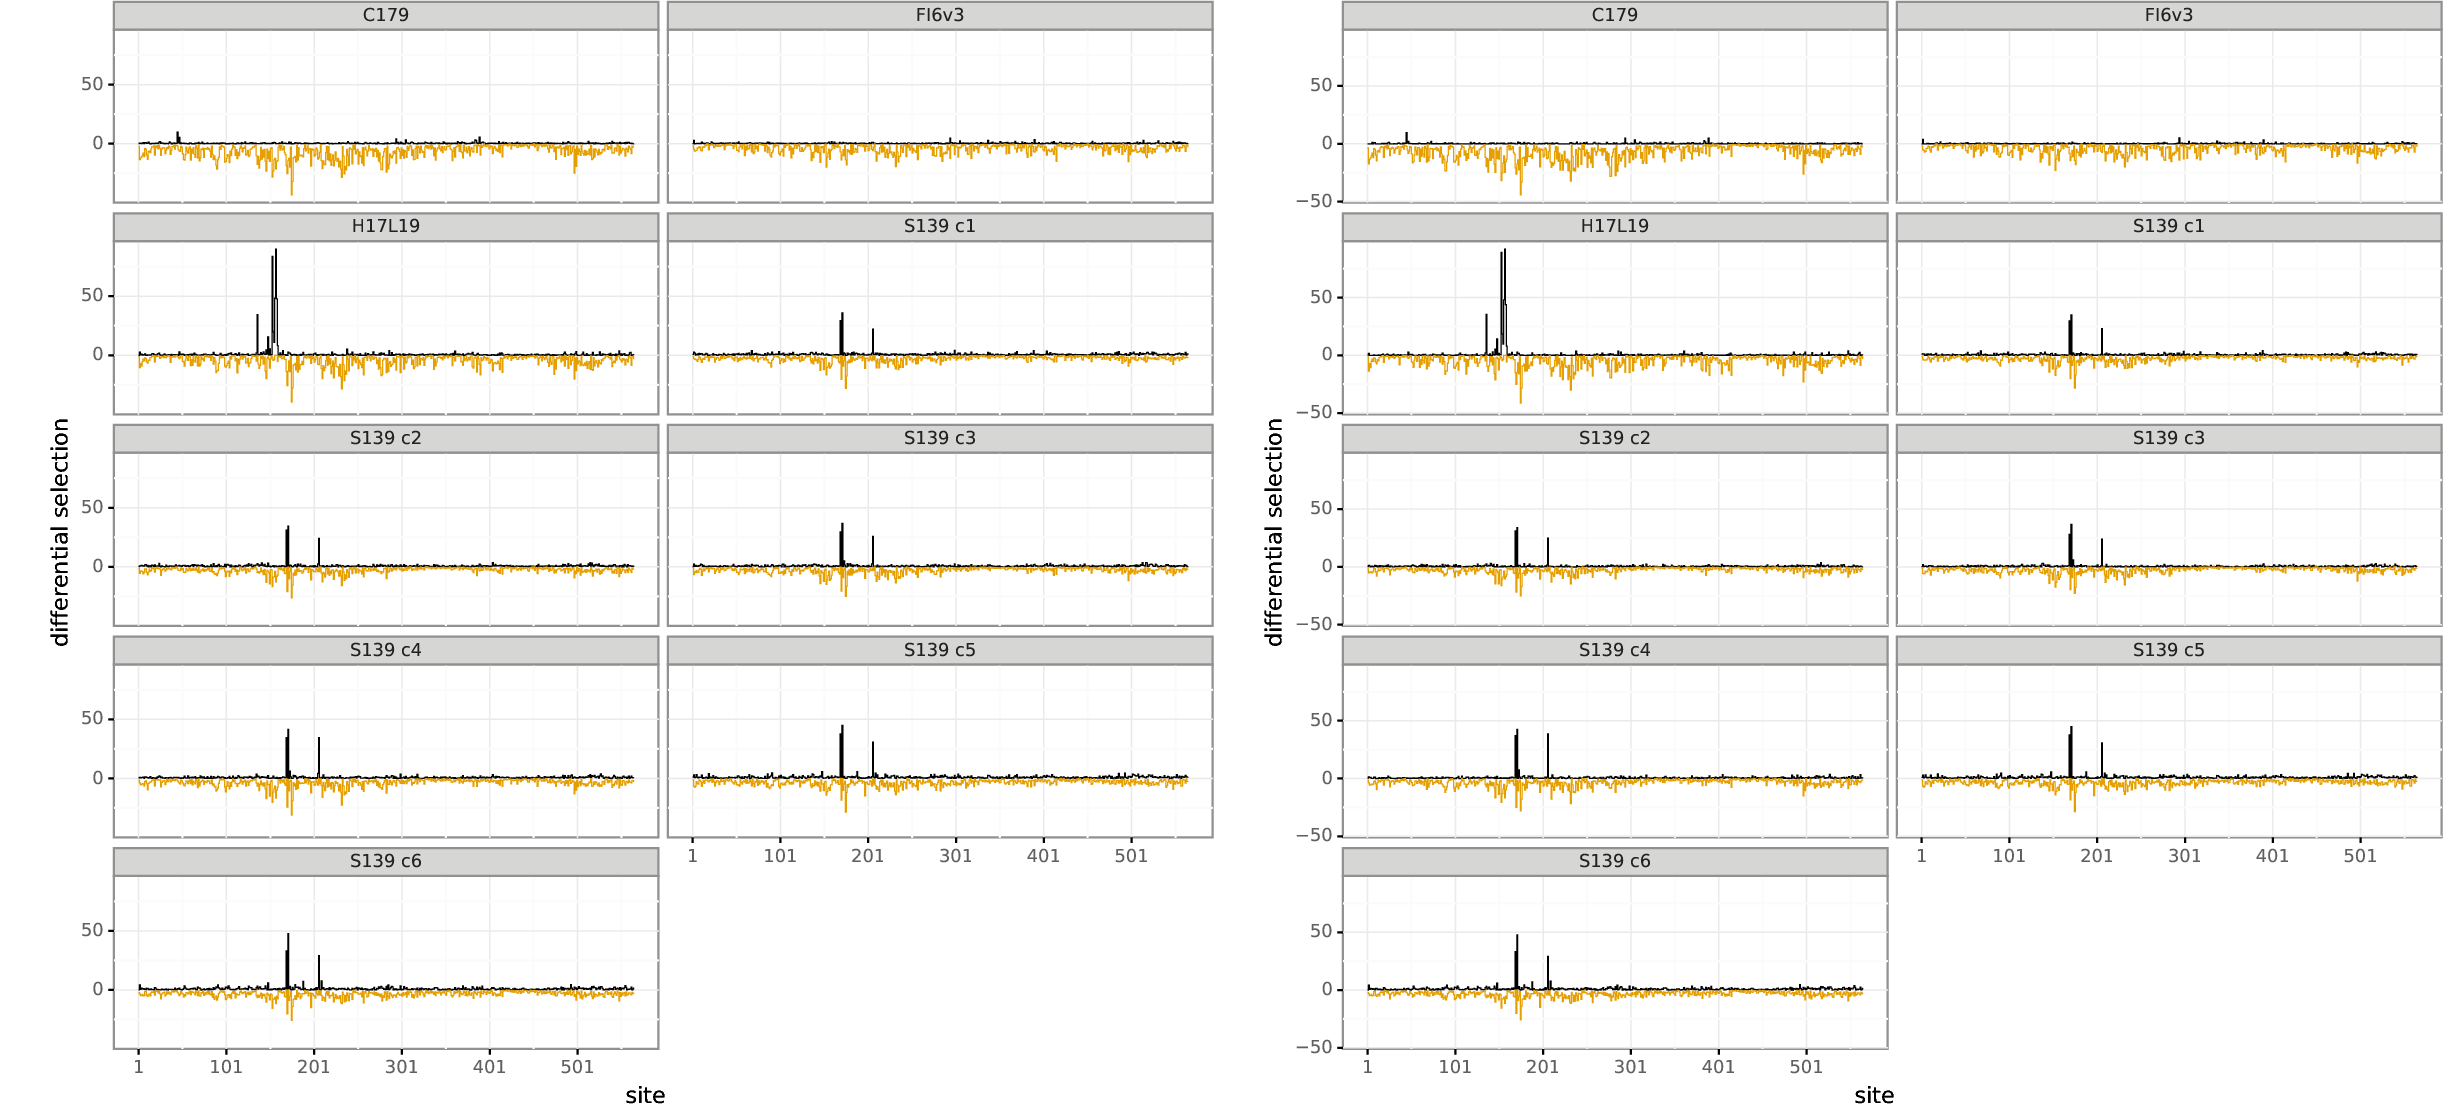

In [28]:
showPDF([diffselprefix + 'meantotaldiffsel.pdf', diffselprefix + 'mediantotaldiffsel.pdf'])

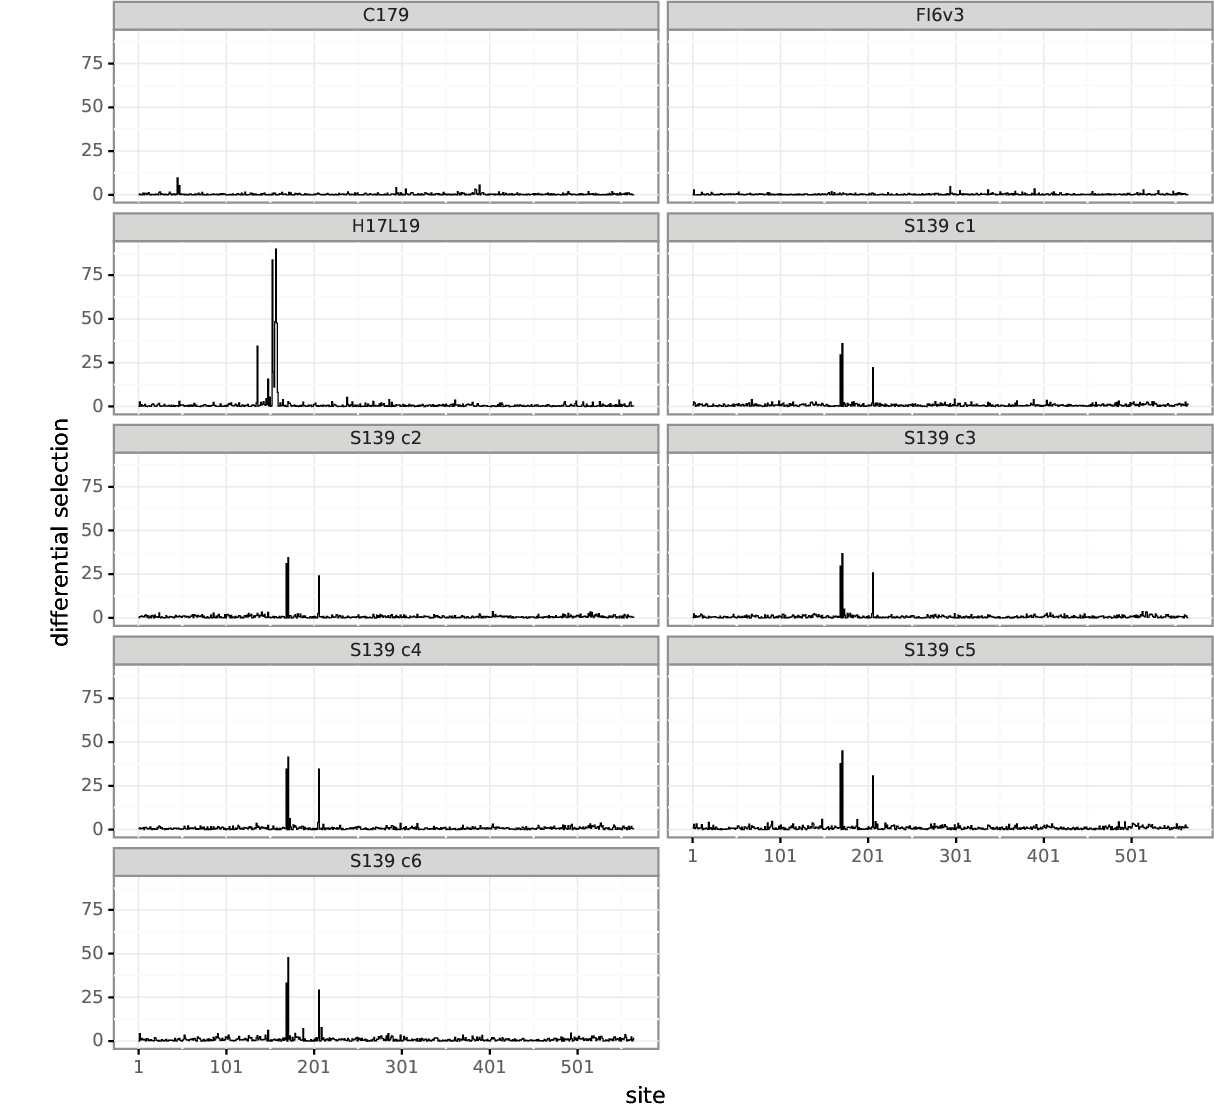

In [29]:
showPDF(diffselprefix + 'meanpositivediffsel.pdf', width=800)

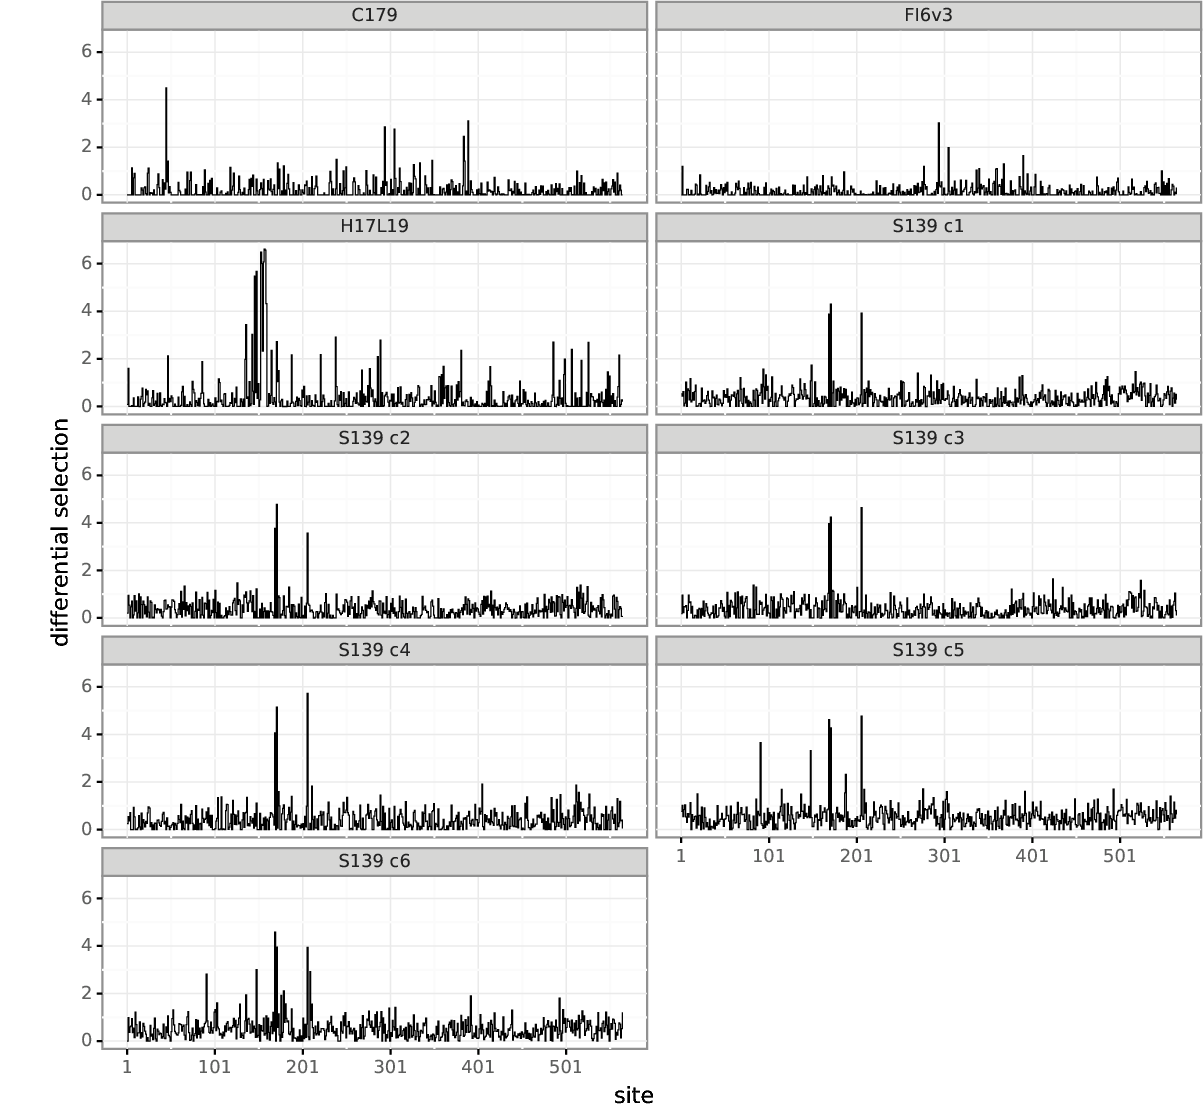

In [30]:
showPDF(diffselprefix + 'medianmaxdiffsel.pdf', width=800)

In [31]:
!head -9 {diffseldir}/summary_C179-medianmutdiffsel.csv

site,wildtype,mutation,mutdiffsel
45,H,S,4.49775701980248
389,N,R,3.1149167939624514
294,K,T,2.854586967645523
305,N,S,2.758756963344059
384,T,S,2.4565148964805035
294,K,S,2.130939689370205
45,H,G,1.9061324610126116
45,H,A,1.9036254935740438


In [32]:
!head -9 {diffseldir}/summary_FI6v3-medianmutdiffsel.csv

site,wildtype,mutation,mutdiffsel
294,K,S,3.023199201028552
294,K,T,2.0030720045573256
305,N,S,1.986606043960116
390,G,R,1.6470854027439472
368,H,Y,1.3028348502375577
277,F,N,1.2009139054660039
2,K,T,1.1963411580708139
340,I,K,1.1048271254386615


## Create logoplots of differential selection


Creating logo plot for S139-c4 from ./results/differential_selections/summary_S139-c4-medianmutdiffsel.csv


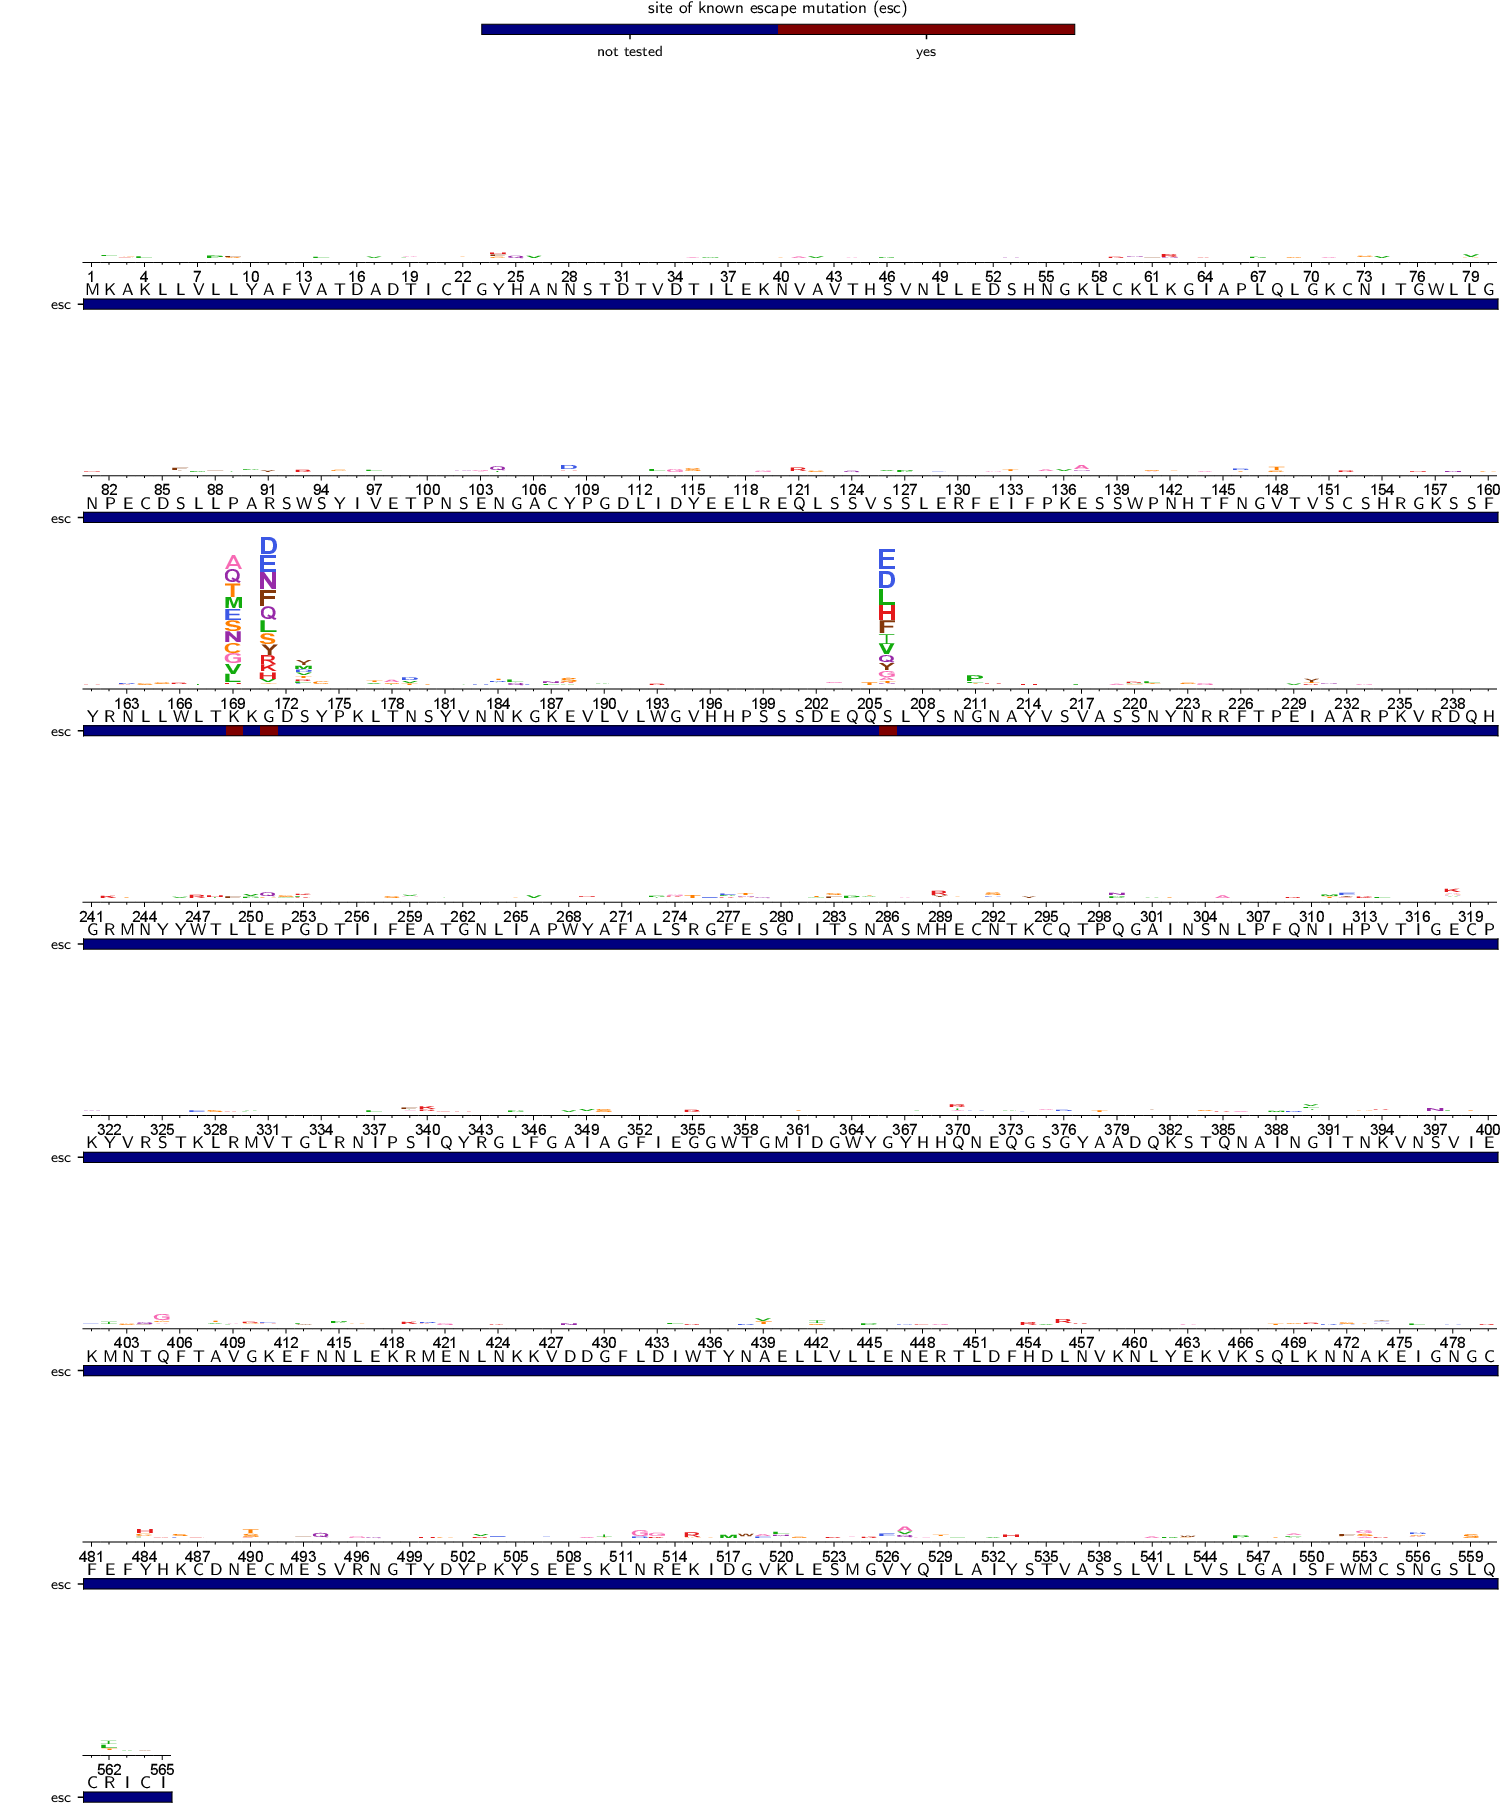


Creating logo plot for S139-c3 from ./results/differential_selections/summary_S139-c3-medianmutdiffsel.csv


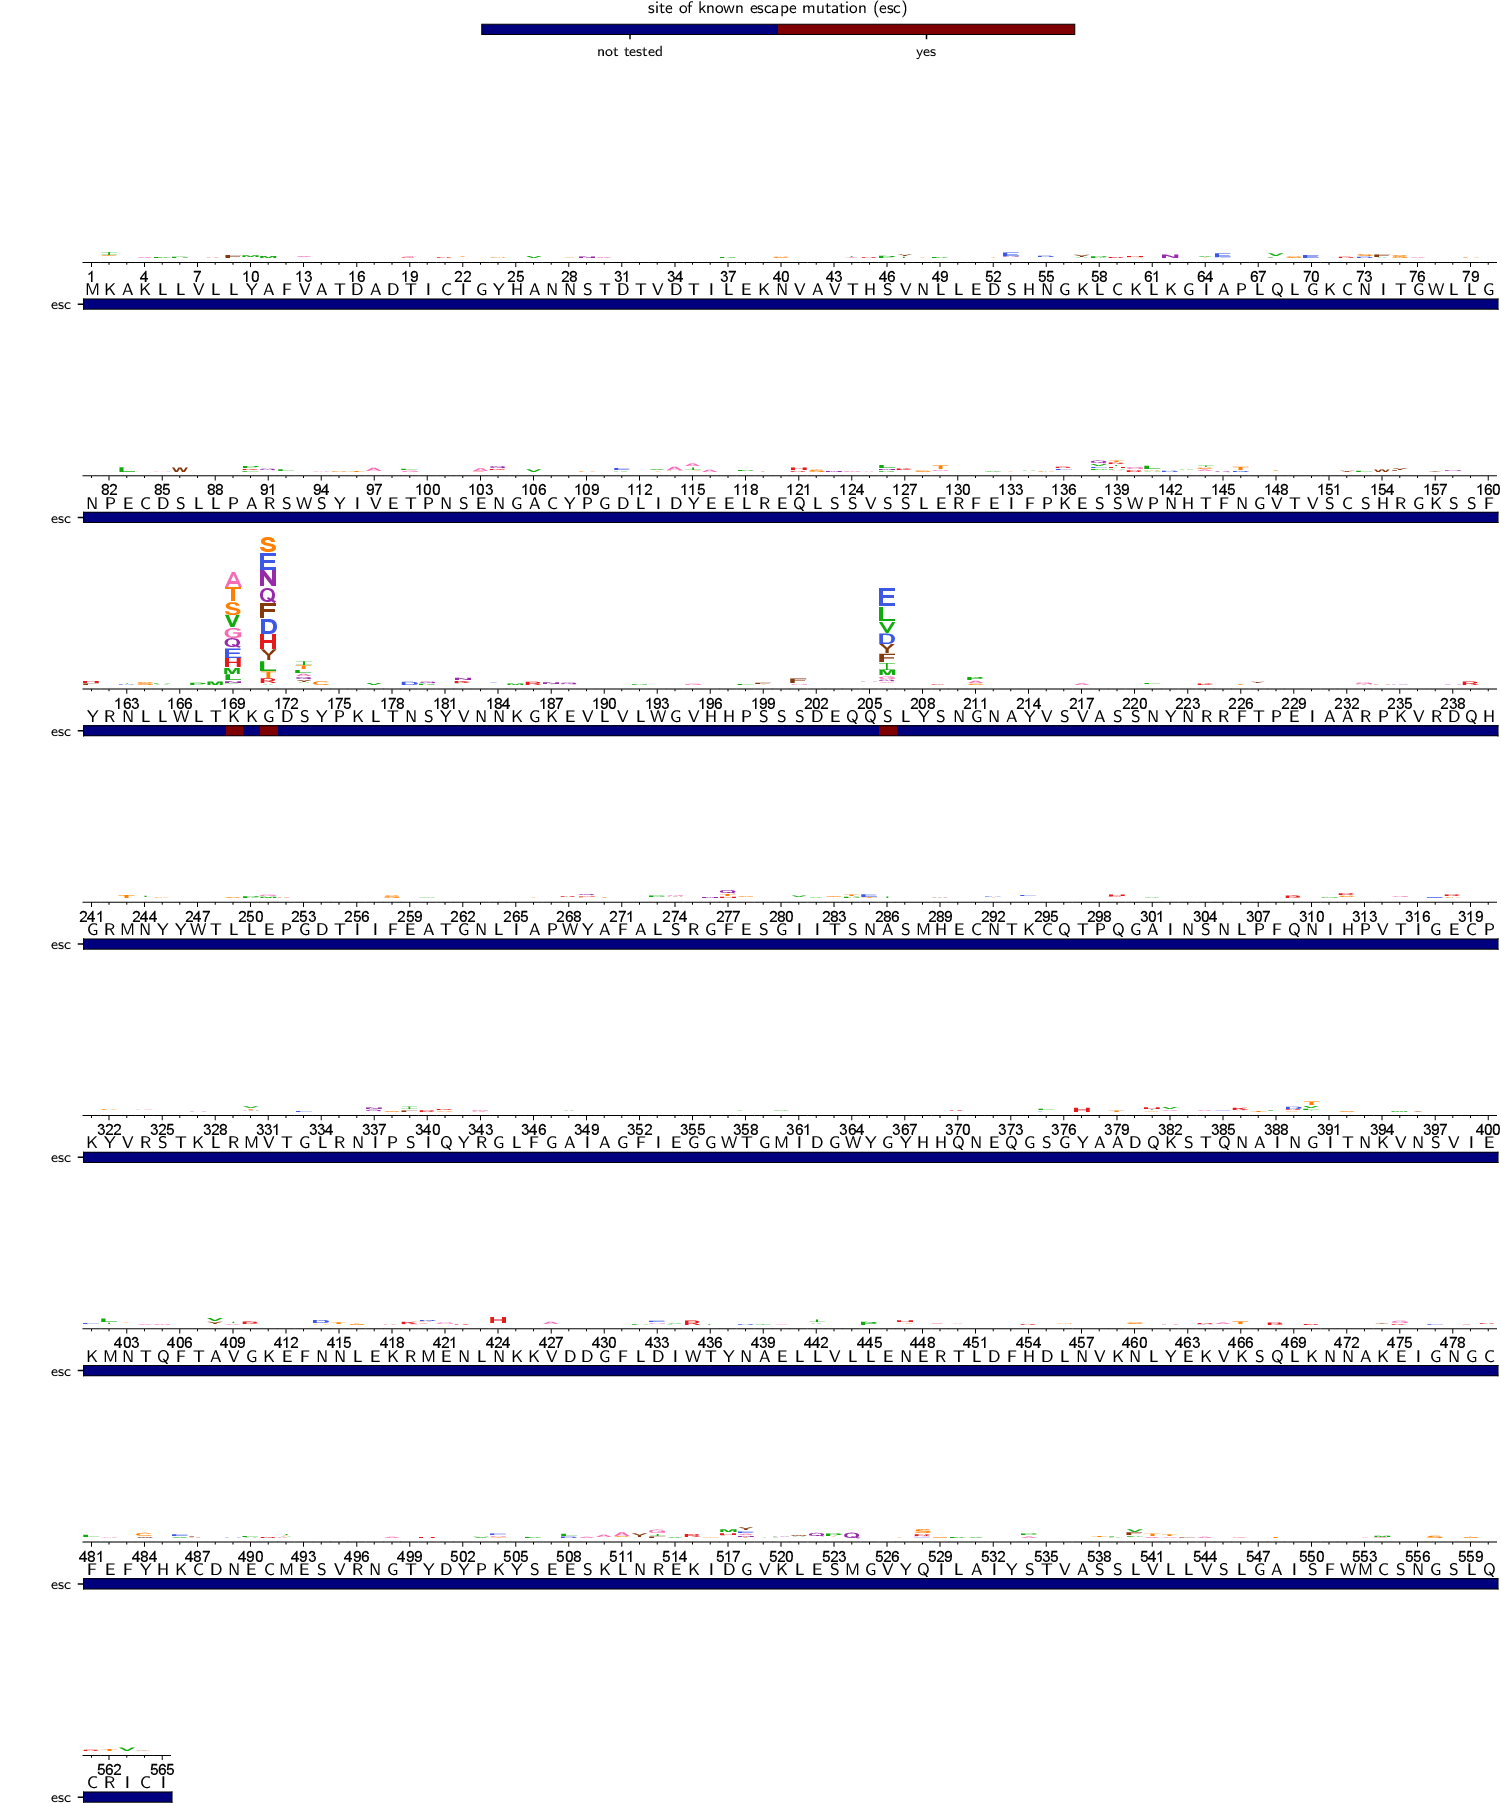

In [28]:
known = pd.read_csv('./inputs/known_escape.csv', index_col='site')

for antibody in ['S139-c4', 'S139-c3']:
    # mutdiffsel in this file
    mutdiffsel = diffselprefix + antibody + '-medianmutdiffsel.csv'
    
    # create known sites overlay file to pass to dms2_logoplot
    sites = pd.read_csv(mutdiffsel)['site'].unique()
    antibodyname = antibody.split('-')[0]
    knownsites = diffselprefix + '{0}_known_escape.csv'.format(antibodyname)
    (known.query('antibody == @antibodyname')
          .assign(esc='yes')
          .reindex(sites) # add entry for sites NOT known to mediate escape
          .reset_index()
          .drop_duplicates('site')
          .fillna('not tested')
          .to_csv(knownsites, index=False)
          )
    
    # now create the logo plot with the overlay
    logoplot = os.path.join(logodir, '{0}_diffsel.pdf'.format(antibody))
    print("\nCreating logo plot for {0} from {1}".format(
            antibody, mutdiffsel))
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {antibody} \
            --outdir {logodir} \
            --restrictdiffsel positive \
            --sepline no \
            --numberevery 3\
            --nperline 80 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --overlay2 {knownsites} esc "site of known escape mutation" \
            --underlay yes \
            --use_existing {use_existing}
    showPDF(logoplot)

These logoplots show strong differential selection at the three sites previously characterized as escape mutants by [Yoshida et al (2009)](http://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1000350) (see Figure 5): 156, 158, 193 in H3 numbering. These three sites are indicated in the underlay as known sites of escape. 


Creating logo plot for C179 from ./results/differential_selections/summary_C179-medianmutdiffsel.csv


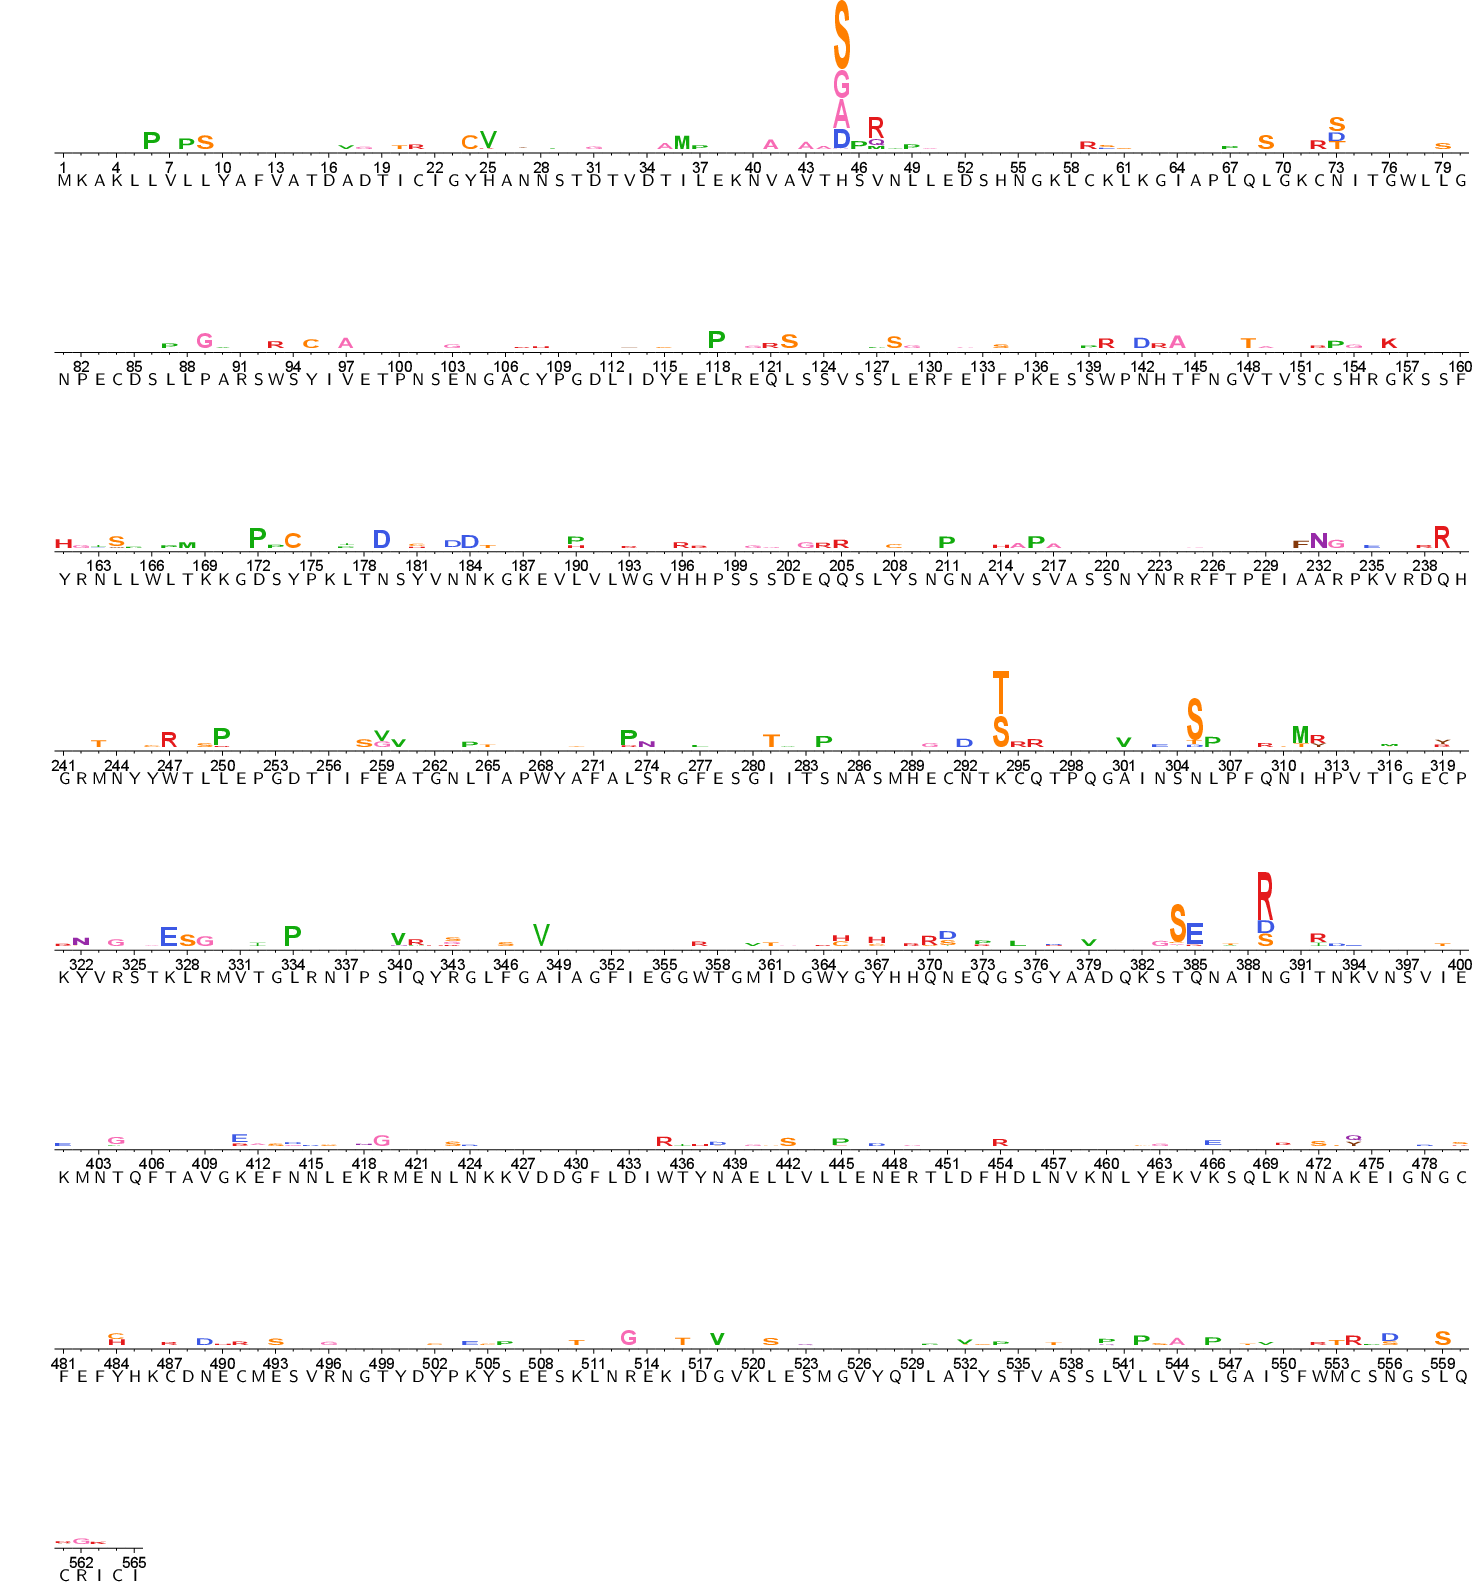


Creating logo plot for FI6v3 from ./results/differential_selections/summary_FI6v3-medianmutdiffsel.csv


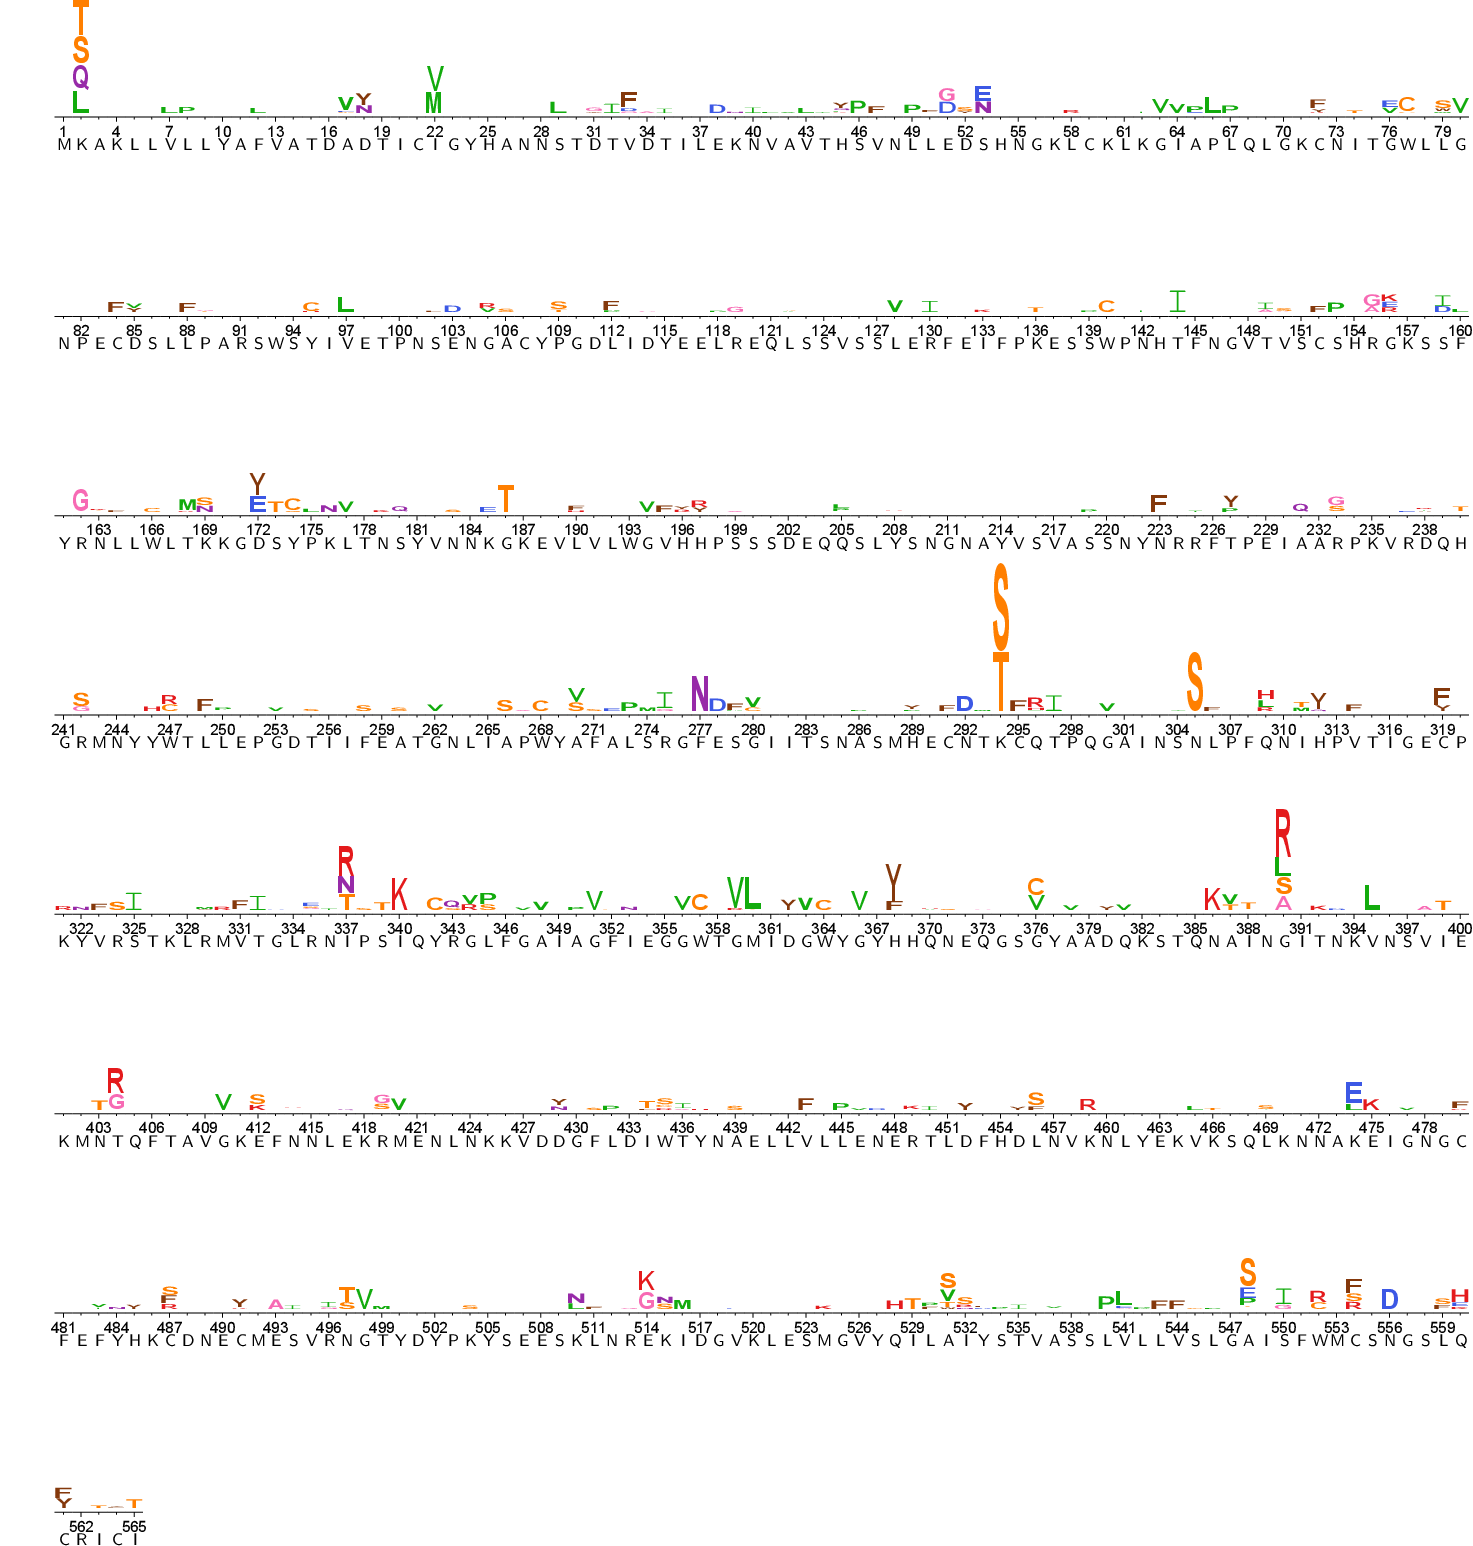


Creating logo plot for H17L19 from ./results/differential_selections/summary_H17L19-medianmutdiffsel.csv


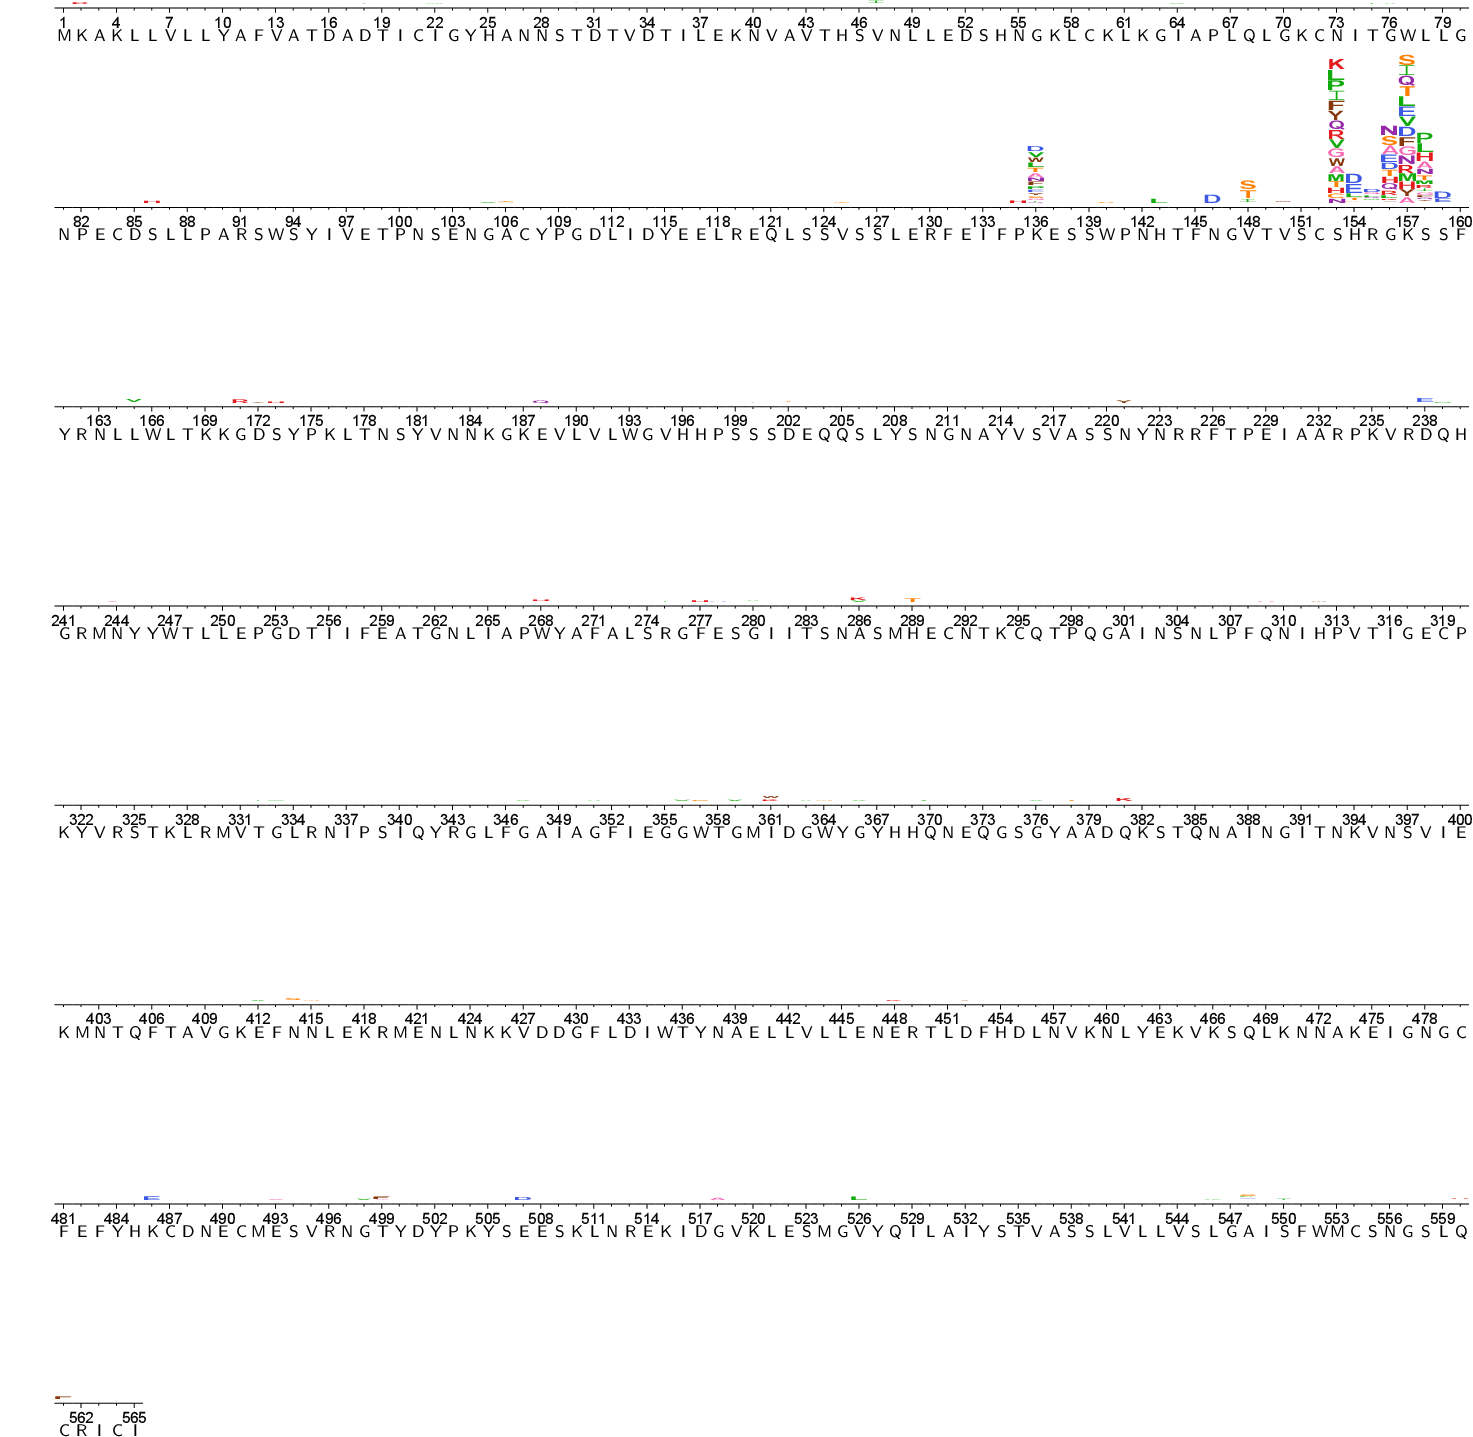

In [63]:
for antibody in ['C179', 'FI6v3', 'H17L19']:
    # mutdiffsel in this file
    mutdiffsel = diffselprefix + antibody + '-medianmutdiffsel.csv'
    
    # now create the logo plot with the overlay
    logoplot = os.path.join(logodir, '{0}_diffsel.pdf'.format(antibody))
    print("\nCreating logo plot for {0} from {1}".format(
            antibody, mutdiffsel))
    log = !dms2_logoplot \
            --diffsel {mutdiffsel} \
            --name {antibody} \
            --outdir {logodir} \
            --restrictdiffsel positive \
            --sepline no \
            --numberevery 3 \
            --nperline 80 \
            --overlay1 {mutdiffsel} wildtype wildtype \
            --underlay yes \
            --use_existing {use_existing}
    showPDF(logoplot)

# Quantifying the ease of escape from different antibodies

Here I will implement the `calculate_phi` function to evaluate the ease of escape from different antibodies using the $\phi$ statistic.

In [35]:
errorcontrolcounts = '{0}/WTplasmid_codoncounts.csv'.format(countsdir)

phis_errorcontrol_gammacorrect_files = {}

for mab in ['S139', 'C179', 'FI6v3', 'H17L19']:
    antibody_samples = [s for s in samples if mab in s and 'mock' not in s]
    for antibody_sample in antibody_samples:
        mock_sample = diffselbatch[diffselbatch['sel'] == antibody_sample]['mock'].item()
        pctgamma = exp_list[exp_list['name'] == antibody_sample]['percent_infectivity']
        gamma = pctgamma/100
        mock_counts = '{0}/{1}_codoncounts.csv'.format(countsdir, mock_sample)
        antibody_counts = '{0}/{1}_codoncounts.csv'.format(countsdir, antibody_sample)
        outfile = '{0}/{1}_phis_gammacorrected.txt'.format(phidir, antibody_sample)
        args = {'gamma': gamma, 
                'mockcounts': mock_counts, 
                'selectedcounts': antibody_counts,
                'outfile': outfile, 
                'errorcontrolcounts': errorcontrolcounts, 
                'gammacorrect': True, 
                'pseudocount': 5.0}
        calculate_phi(args)
        phis_errorcontrol_gammacorrect_files[antibody_sample] = outfile

In [36]:
median_phi_files = []

for mab in ['S139', 'C179', 'FI6v3', 'H17L19']:
    antibody_samples = [s for s in samples if mab in s and 'mock' not in s]
    phis_files = [phis_errorcontrol_gammacorrect_files[sample] for sample in antibody_samples]
    median_phi_stdev_file = '{0}/{1}_median_phigammacorrected_stdev.txt'.format(phidir, mab)
    median_phi_file = '{0}/{1}_median_phigammacorrected.txt'.format(phidir, mab)
    median_phi_files.append(median_phi_stdev_file)
    AvgAndStDevDiffsel(phis_files, median_phi_stdev_file, method='median')
    AvgAndStDevDiffsel(phis_files, median_phi_file, method='median', include_stdev=False)
    

median_diffsel_files = []

for mab in ['S139', 'C179', 'FI6v3', 'H17L19']:
    mutdiffsel_files = glob.glob('{0}/{1}-*_mutdiffsel.csv'.format(diffseldir, mab))
    median_diffsel_stdev_file = '{0}/{1}_median_mutdiffsel_stdev.txt'.format(diffseldir, mab)
    median_diffsel_files.append(median_diffsel_stdev_file)
    AvgAndStDevDiffsel(mutdiffsel_files, median_diffsel_stdev_file, method='median')

Showing top 100 mutations for phi statistic, +/- standard deviation:



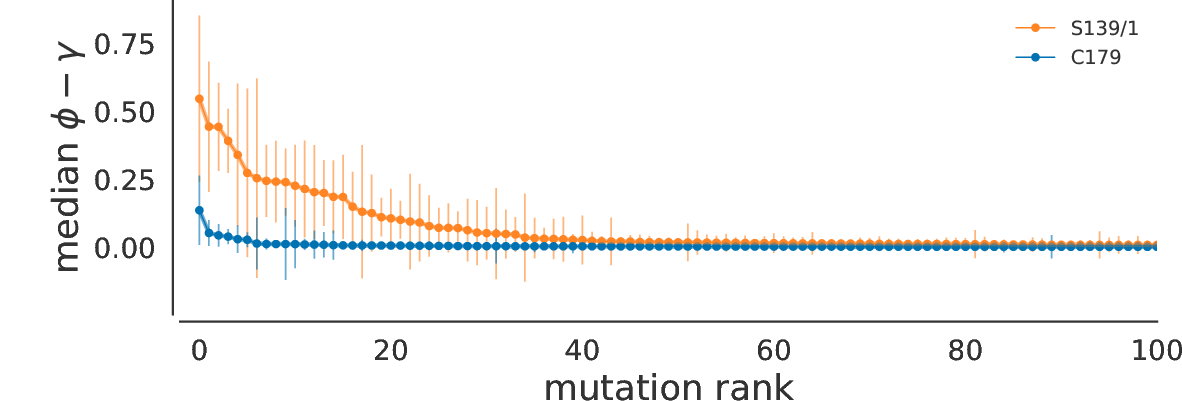

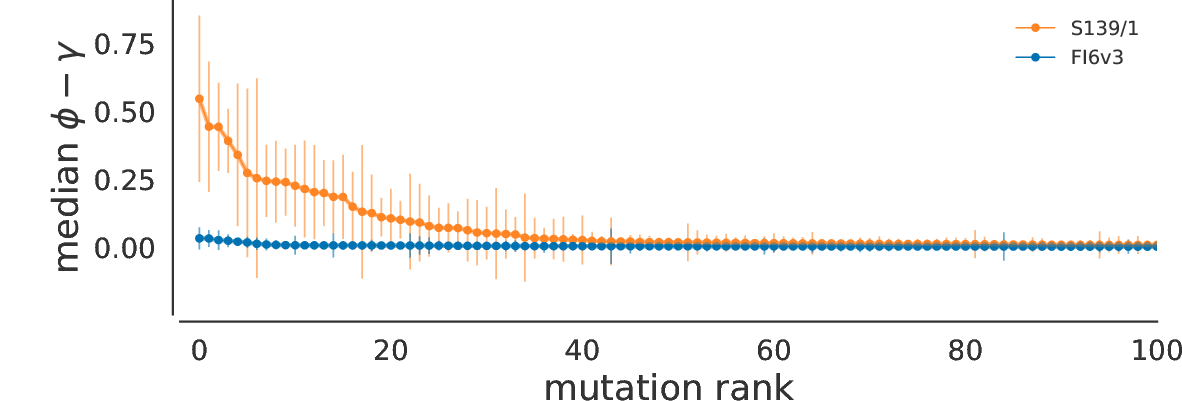

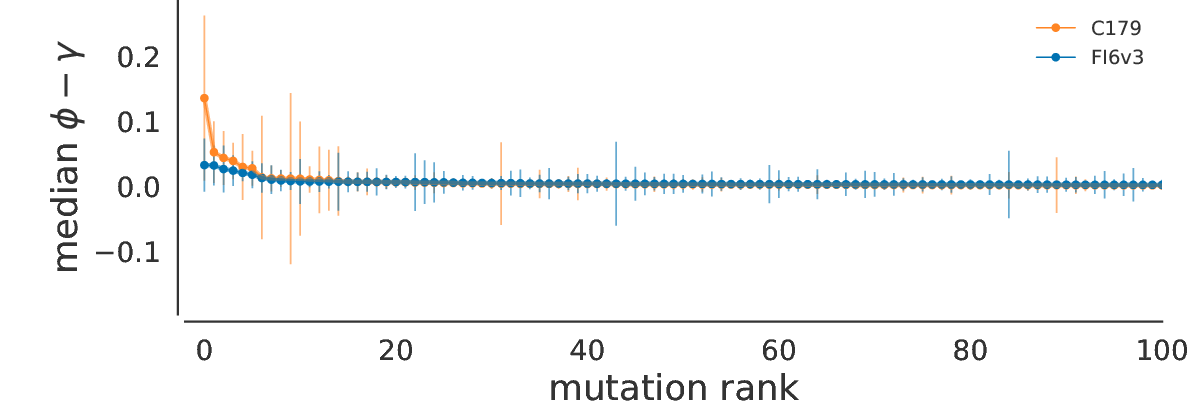

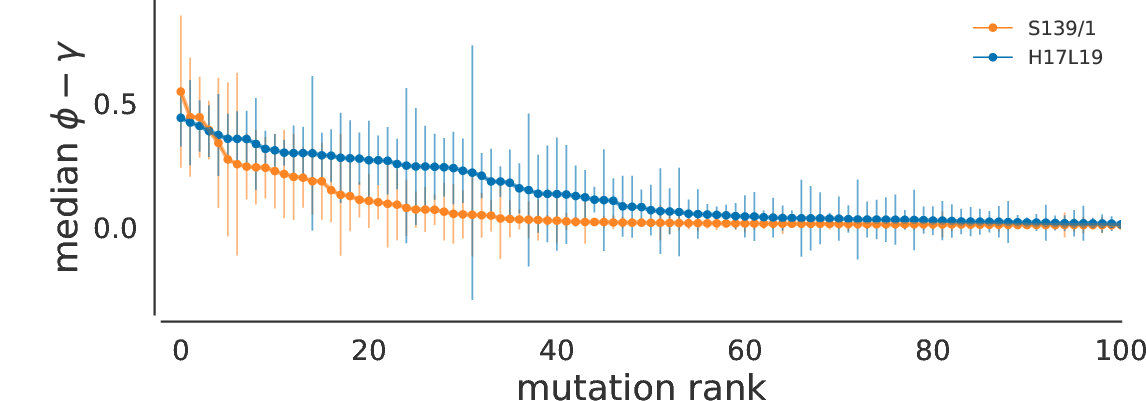

In [37]:
colorcycle = [lightvermillion, blue]

print ('Showing top 100 mutations for phi statistic, +/- standard deviation:\n')

labels_files = [('S139/1', '{0}/S139_median_phigammacorrected_stdev.txt'.format(phidir)), 
                ('C179', '{0}/C179_median_phigammacorrected_stdev.txt'.format(phidir))]
PlotRankedMutations(labels_files, '{0}/temp_S139vsC179_phi'.format(plotsdir), 
                    rank_lims=(-2, 100), title='', make_legend=True, figsize=(9,3.5), 
                    ylabel='median $\phi-\gamma$', include_stdev=True, colorcycle=colorcycle)
showPDF(['{0}/temp_S139vsC179_phi.pdf'.format(plotsdir)])

labels_files = [('S139/1', '{0}/S139_median_phigammacorrected_stdev.txt'.format(phidir)), 
                ('FI6v3', '{0}/FI6v3_median_phigammacorrected_stdev.txt'.format(phidir))]
PlotRankedMutations(labels_files, '{0}/temp_S139vsFI6v3_phi'.format(plotsdir), 
                    rank_lims=(-2, 100), title='', make_legend=True, figsize=(9,3.5), 
                    ylabel='median $\phi-\gamma$', include_stdev=True, colorcycle=colorcycle)
showPDF(['{0}/temp_S139vsFI6v3_phi.pdf'.format(plotsdir)])

labels_files = [('C179', '{0}/C179_median_phigammacorrected_stdev.txt'.format(phidir)), 
                ('FI6v3', '{0}/FI6v3_median_phigammacorrected_stdev.txt'.format(phidir))]
PlotRankedMutations(labels_files, '{0}/temp_C179vsFI6v3_phi'.format(plotsdir), 
                    rank_lims=(-2, 100), title='', make_legend=True, figsize=(9,3.5), 
                    ylabel='median $\phi-\gamma$', include_stdev=True, colorcycle=colorcycle)
showPDF(['{0}/temp_C179vsFI6v3_phi.pdf'.format(plotsdir)])

labels_files = [('S139/1', '{0}/S139_median_phigammacorrected_stdev.txt'.format(phidir)), 
                ('H17L19', '{0}/H17L19_median_phigammacorrected_stdev.txt'.format(phidir))]
PlotRankedMutations(labels_files, '{0}/temp_S139vsH17L19_phi'.format(plotsdir), 
                    rank_lims=(-2, 100), title='', make_legend=True, figsize=(9,3.5), 
                    ylabel='median $\phi-\gamma$', include_stdev=True, colorcycle=colorcycle)
showPDF(['{0}/temp_S139vsH17L19_phi.pdf'.format(plotsdir)])

The median $\phi$ shows a striking difference between S139/1 and C179. Similar to the difference between H17-L19 and FI6v3, escape mutations are fewer and smaller in effect size for C179 compared to escape mutations from S139/1. 

The top five mutations for C179 exhibit a larger median $\phi$ value than the top five mutations of FI6v3, suggesting that although escape mutations from these two stalk-targeting antibodies are smaller in effect size compared to "easier to escape from" head-targeting antibodies, that escape mutations are slightly larger in effect size compared to escape mutations from FI6v3. This somewhat makes sense given that FI6v3 is much more broadly neutralizing compared to C179. 

Interestingly, the top 3 mutations for S139/1 have a slightly higher median $\phi$ value compared to the top 3 mutations for H17L19. Even though S139/1 has what is described as "broadly-neutralizing" activity, some of the top escape mutations may be slightly greater in effect in conferring escape compared to an antibody with a narrow binding and neutralization profile.

In [39]:
!head -5 {phidir}/S139_median_phigammacorrected_stdev.txt

site,wildtype,mutation,mutdiffsel,stdev
205,S,E,0.5455732356735866,0.3054874210731211
170,G,E,0.4430007171332391,0.23940900978701757
170,G,N,0.4423165776469953,0.16219692499723878
170,G,D,0.3910542187867998,0.11778777345699008


Showing top 100 mutations for mutation differential selection, +/- standard deviation:



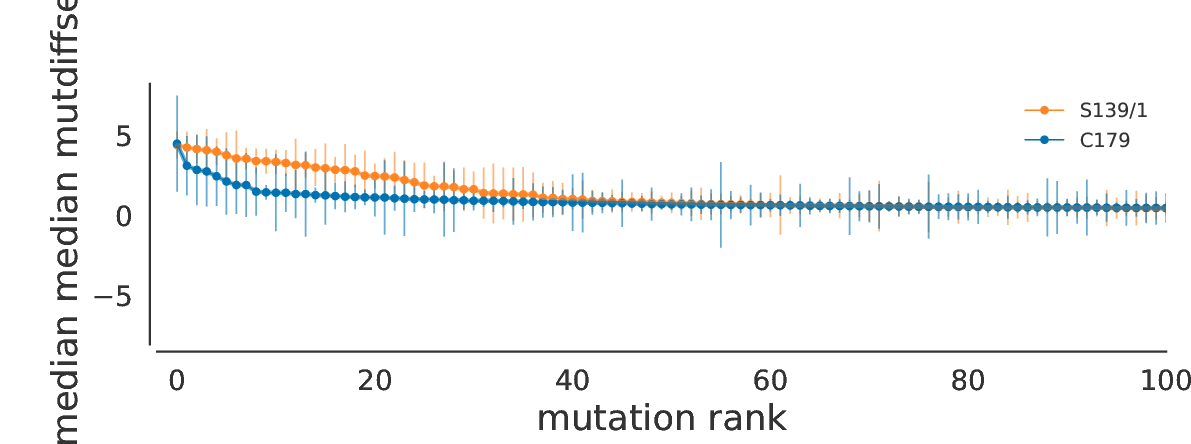

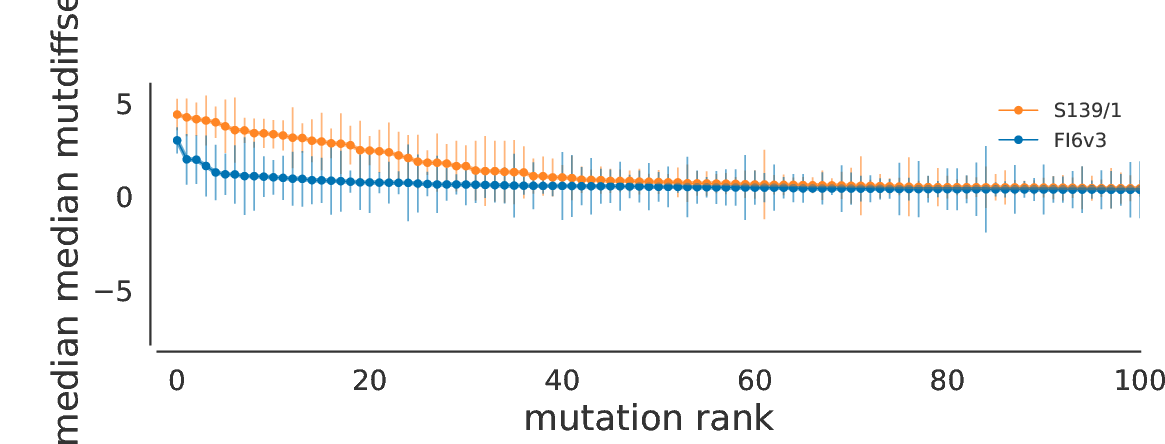

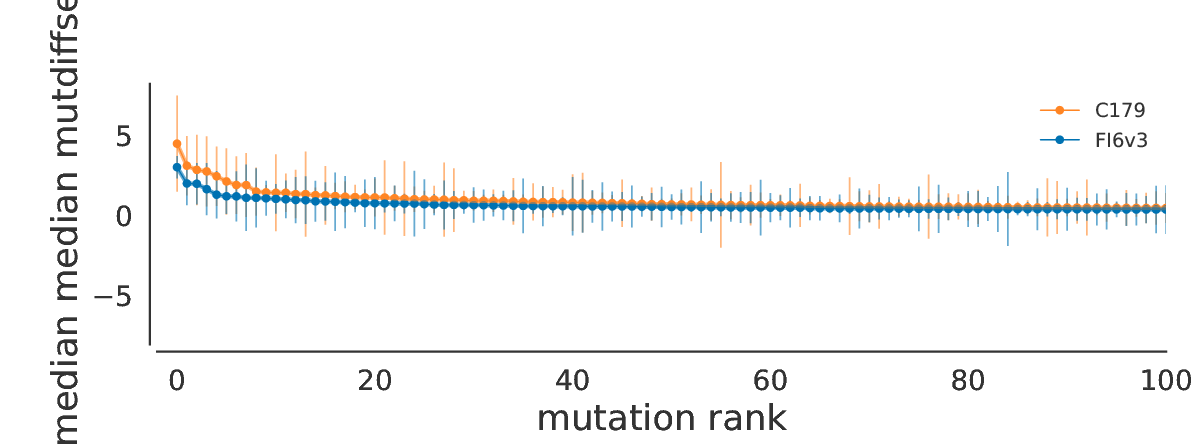

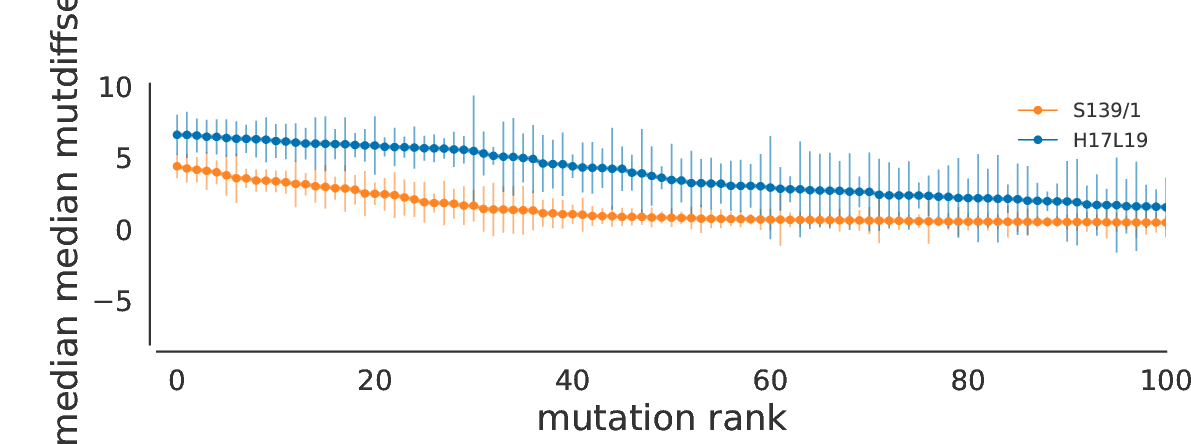

In [40]:
colorcycle = [lightvermillion, blue]

print ('Showing top 100 mutations for mutation differential selection, +/- standard deviation:\n')

labels_files = [('S139/1', '{0}/S139_median_mutdiffsel_stdev.txt'.format(diffseldir)), 
                ('C179', '{0}/C179_median_mutdiffsel_stdev.txt'.format(diffseldir))]
PlotRankedMutations(labels_files, '{0}/temp_S139vsC179_mutdiffsel'.format(plotsdir), 
                    rank_lims=(-2, 100), title='', make_legend=True, figsize=(9,3.5), 
                    ylabel='median median mutdiffsel', include_stdev=True, colorcycle=colorcycle)
showPDF(['{0}/temp_S139vsC179_mutdiffsel.pdf'.format(plotsdir)])

labels_files = [('S139/1', '{0}/S139_median_mutdiffsel_stdev.txt'.format(diffseldir)), 
                ('FI6v3', '{0}/FI6v3_median_mutdiffsel_stdev.txt'.format(diffseldir))]
PlotRankedMutations(labels_files, '{0}/temp_S139vsFI6v3_mutdiffsel'.format(plotsdir), 
                    rank_lims=(-2, 100), title='', make_legend=True, figsize=(9,3.5), 
                    ylabel='median median mutdiffsel', include_stdev=True, colorcycle=colorcycle)
showPDF(['{0}/temp_S139vsFI6v3_mutdiffsel.pdf'.format(plotsdir)])

labels_files = [('C179', '{0}/C179_median_mutdiffsel_stdev.txt'.format(diffseldir)), 
                ('FI6v3', '{0}/FI6v3_median_mutdiffsel_stdev.txt'.format(diffseldir))]
PlotRankedMutations(labels_files, '{0}/temp_C179vsFI6v3_mutdiffsel'.format(plotsdir), 
                    rank_lims=(-2, 100), title='', make_legend=True, figsize=(9,3.5), 
                    ylabel='median median mutdiffsel', include_stdev=True, colorcycle=colorcycle)
showPDF(['{0}/temp_C179vsFI6v3_mutdiffsel.pdf'.format(plotsdir)])

labels_files = [('S139/1', '{0}/S139_median_mutdiffsel_stdev.txt'.format(diffseldir)), 
                ('H17L19', '{0}/H17L19_median_mutdiffsel_stdev.txt'.format(diffseldir))]
PlotRankedMutations(labels_files, '{0}/temp_S139vsH17L19_mutdiffsel'.format(plotsdir), 
                    rank_lims=(-2, 100), title='', make_legend=True, figsize=(9,3.5), 
                    ylabel='median median mutdiffsel', include_stdev=True, colorcycle=colorcycle)
showPDF(['{0}/temp_S139vsH17L19_mutdiffsel.pdf'.format(plotsdir)])


Creating logo plot for S139 from ./results/phi/S139_median_phigammacorrected.txt


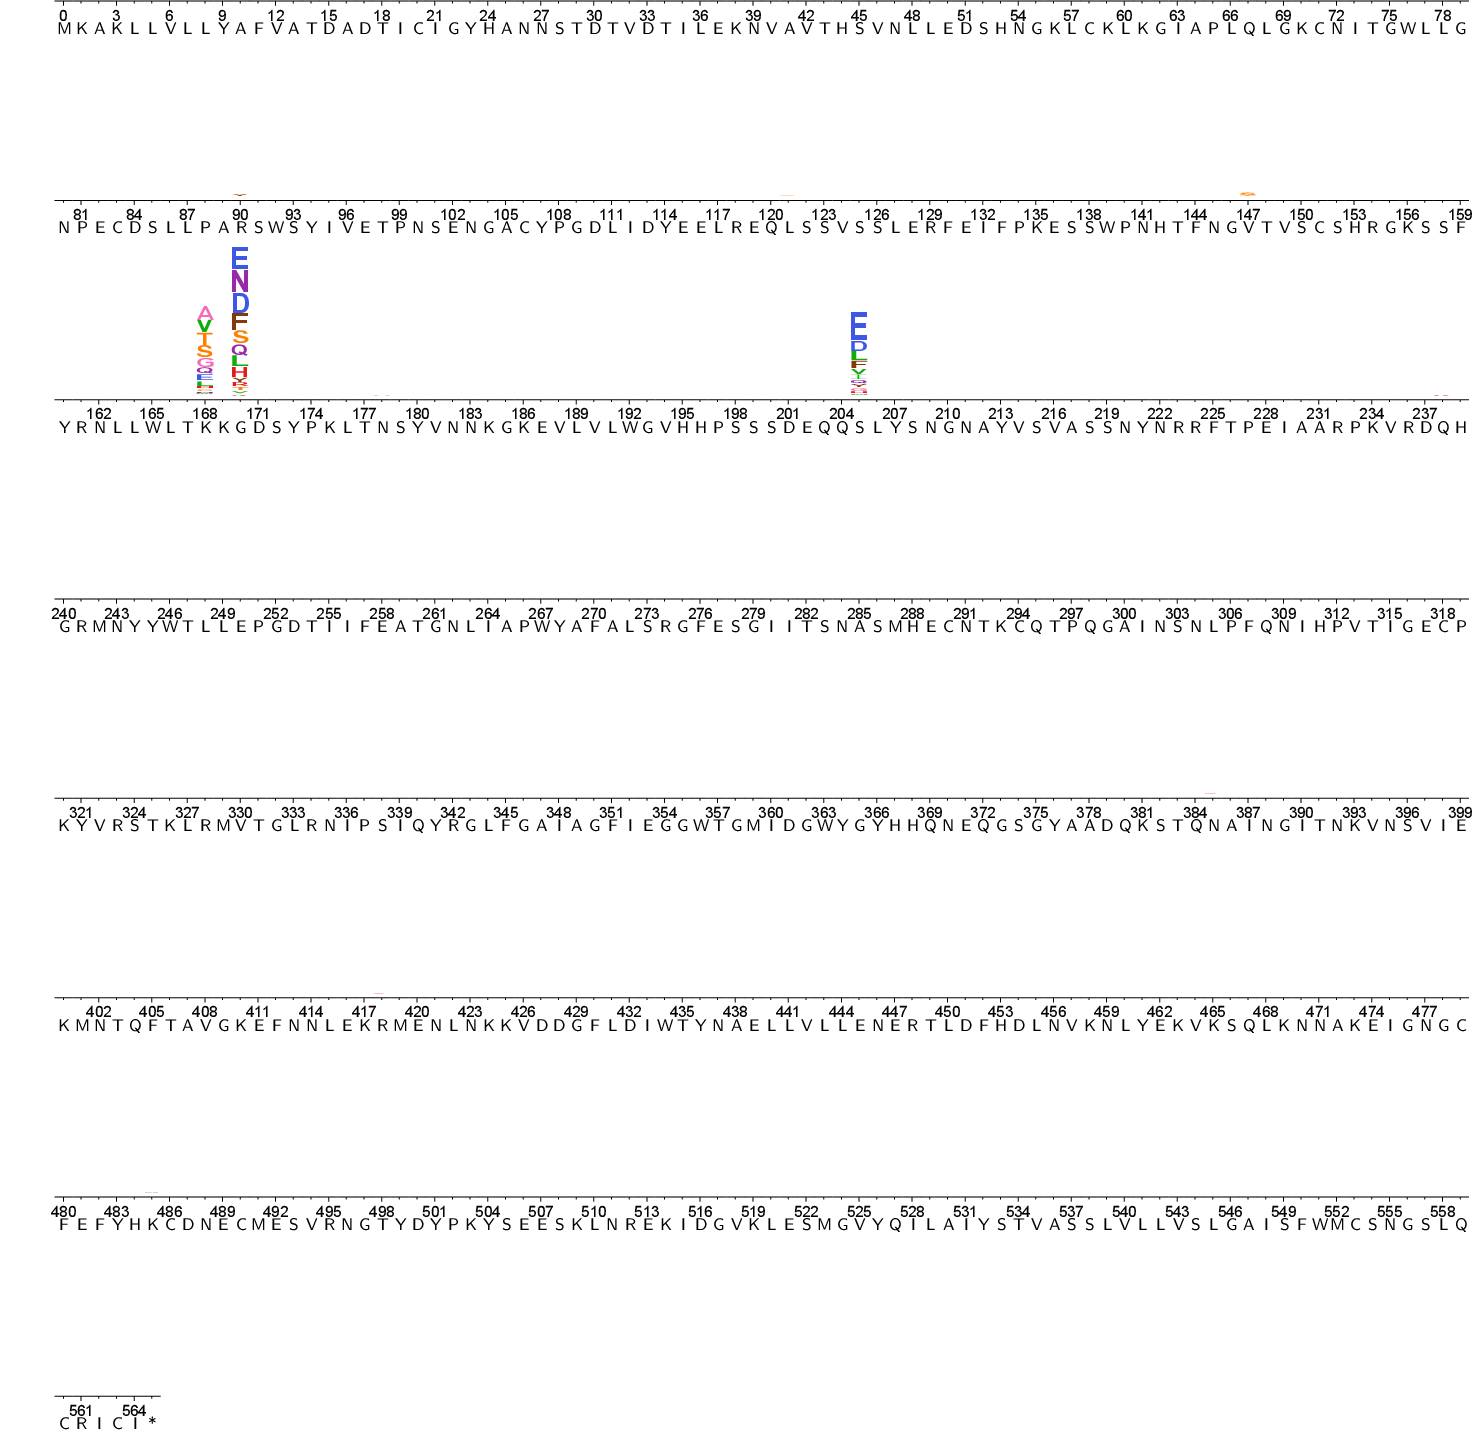


Creating logo plot for C179 from ./results/phi/C179_median_phigammacorrected.txt


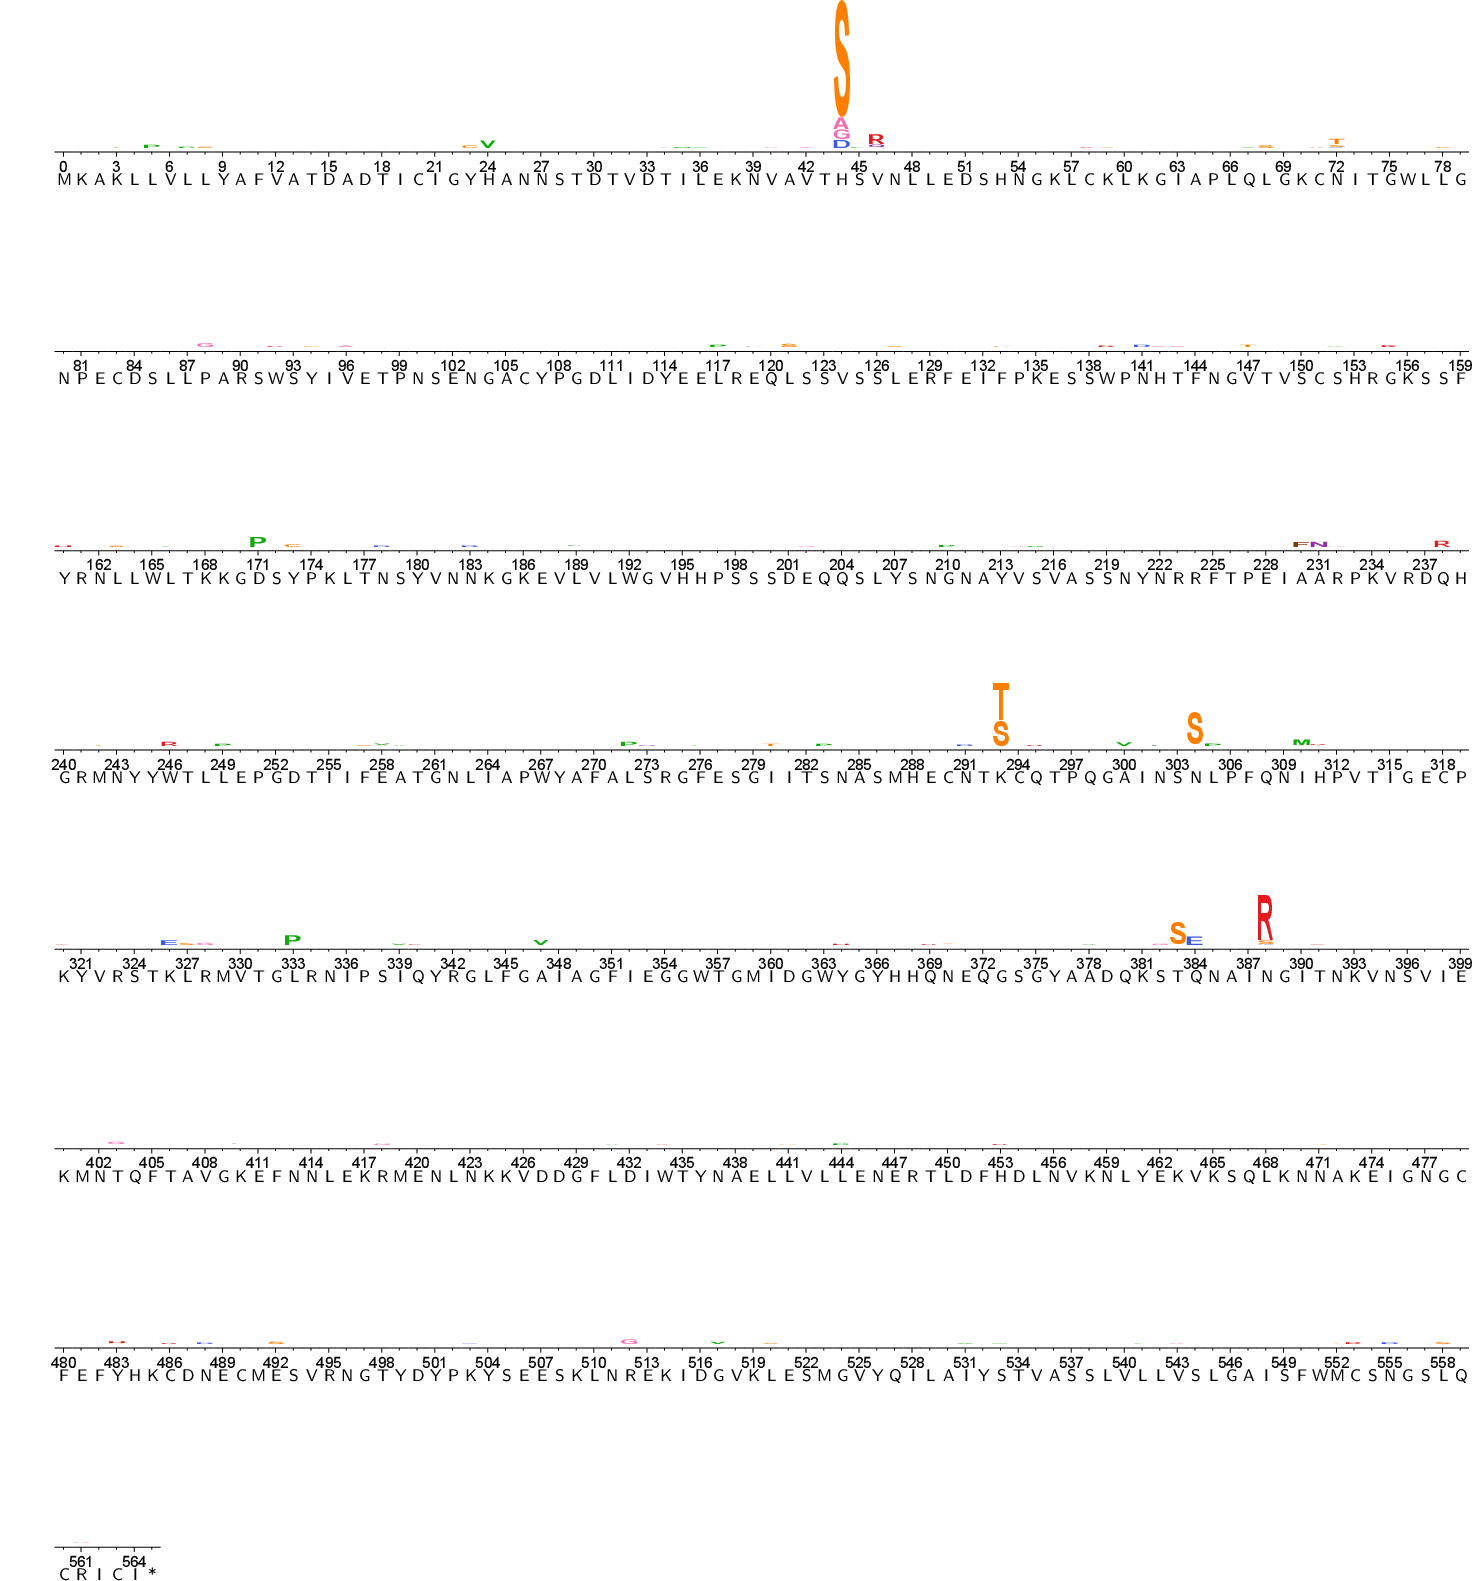


Creating logo plot for FI6v3 from ./results/phi/FI6v3_median_phigammacorrected.txt


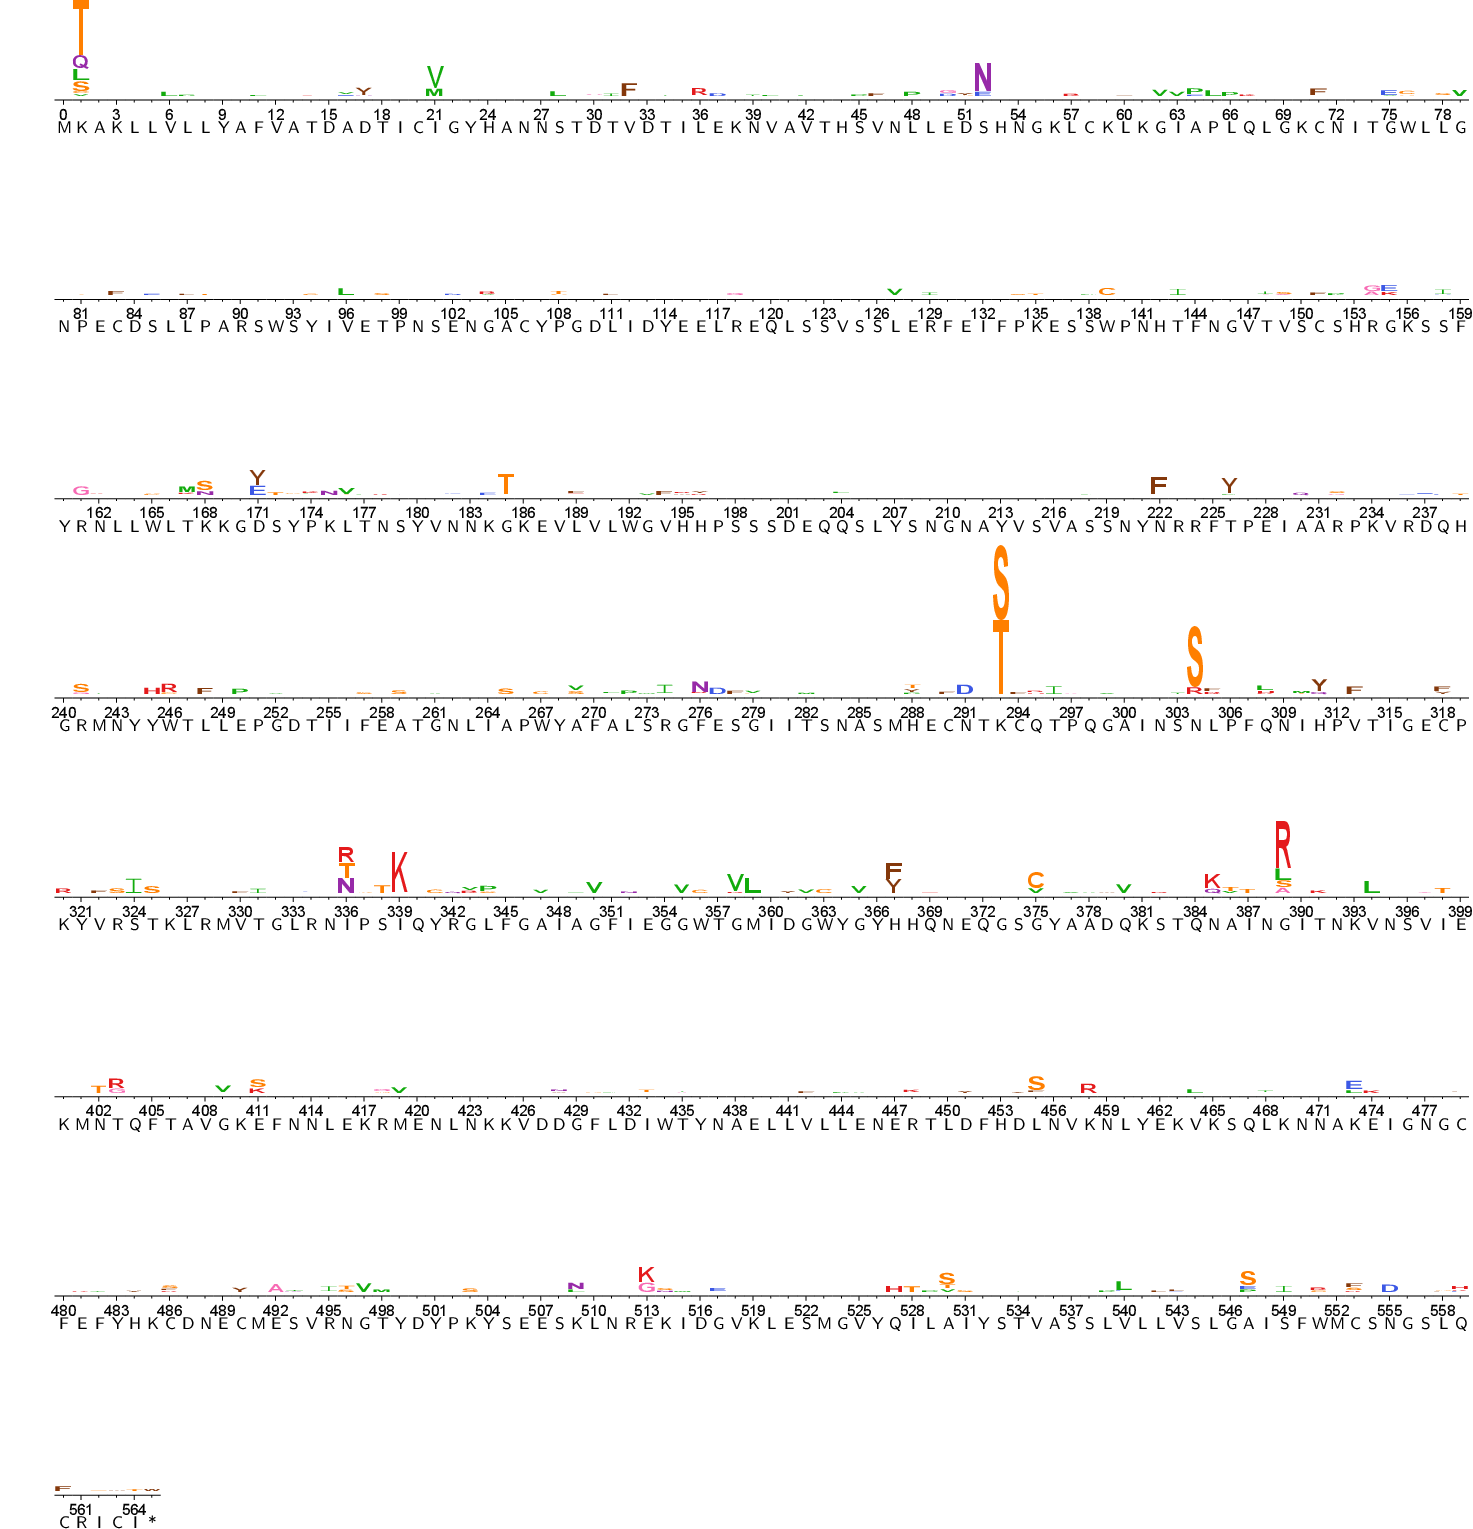

In [107]:
# Logoplot using phi
for antibody in ['S139', 'C179', 'FI6v3']:
    # mutdiffsel in this file
    phidiffsel = phidir + antibody + '_median_phigammacorrected.txt'
    
    # now create the logo plot with the overlay
    logoplot = os.path.join(logodir, '{0}-phi_diffsel.pdf'.format(antibody))
    outprefix = antibody + '-phi'
    print("\nCreating logo plot for {0} from {1}".format(
            antibody, phidiffsel))
    log = !dms2_logoplot \
            --diffsel {phidiffsel} \
            --name {outprefix} \
            --outdir {logodir} \
            --restrictdiffsel positive \
            --sepline no \
            --numberevery 3 \
            --nperline 80 \
            --overlay1 {phidiffsel} wildtype wildtype \
            --underlay yes \
            --use_existing {use_existing}
    showPDF(logoplot)

## Make pymol scripts to map differential selection onto `1RVX pdb` structure

In [41]:
colors = ('#fafafa', '#ff0000')

diffselfile = ['{0}/summary_S139-c4-medianmutdiffsel.csv'.format(diffseldir), 
               '{0}/summary_C179-medianmutdiffsel.csv'.format(diffseldir), 
               '{0}/summary_FI6v3-medianmutdiffsel.csv'.format(diffseldir)]
scriptf = ['{0}/S139-c4-medianmutdiffsel.py'.format(pymoldir), 
           '{0}/C179-medianmutdiffsel.py'.format(pymoldir), 
           '{0}/FI6v3-medianmutdiffsel.py'.format(pymoldir)]

for x in range(len(diffselfile)):
    MapDiffselColorToSite(diffselfile[x], scriptf[x], script_type='pymol', 
                          map_type='max_pos_mutdiffsel', colors = colors, sitecolorfile=None,
                          script_preamble=False, restrict_to_chain=False, prefsfile=None)

# Make logoplots for single sites

In [43]:
common_diffsel_sites = [294, 305, 388, 389]

all_site_outfiles = []

for mab in ['C179', 'FI6v3']:
    for site in common_diffsel_sites:
        infile = '{0}/summary_{1}-medianmutdiffsel.csv'.format(diffseldir, mab)
        outfile = '{0}/{1}-medianmutdiffsel-site{2}.csv'.format(diffseldir, mab, site)
        make_single_site_mutdiffselfile(infile, site, outfile)
        all_site_outfiles.append(outfile)

In [ ]:
import ftplib

def main():
    """Main body of script."""
    filename = './SRAupload/WSN_HA_bnAb_selection.tar'
    print "Starting FTP transfer..."
    ftp = ftplib.FTP('ftp-private.ncbi.nih.gov')
    ftp.login(user='sra', passwd='Qrjo6iJ4')
    print "Successfully connected..."
    ftp.storbinary("STOR " + filename, open(filename, 'rb'))
    ftp.close()
    print "Closed connection successfully."

main() # run the script